In [1]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
import statistics
import glob
import pandas_profiling
import geopandas as gpd
from shapely.affinity import translate
from io import BytesIO
import zipfile
import tempfile
import os
import shutil
from io import StringIO
import gdown

/tmp/ipykernel_6520/1082192247.py:18: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# EFAT MODEL & CONCLUSIONS

In this notebook we are compiling all the analysis we have made along the different notebooks related to each technology -in which we have considered only 2014 for the analysis as a naive approach to a better understanding of the files- and we are including also the information related to the 'Provincias' in order to create the final model we were looking for. 
The notebook will analyze the different tchnologies separately as they are not directly related and the variables including in the study affect in a different manner to the different targets.
In this analysis we will use information related to:

    - Energetic Generation: extracted from Red Eléctrica de España (REE) website in several files (on a yearly basis)
    - Weather historical data: from AEMET API, it contains information related to the meteo stations of the whole country.
    - Provincias: As we want to take into consideration geo data but it is complicated to have all the detail, we are considering 'Provincias' as geo reference for the data we are analyzing.
    - Power Installed: It's a critical variable and it is provided also by REE in a monthly basis.
    - Weather_Predictions: It will be the 'food' for the model to work. The test data that we want to predict.
    - 'Embalses / Dams' Info: Critical for hidroelectric production.


All the data will be analyzed from 2015 to 2022 in order to include the info related to PowerInstalled(only available from 2015 onwards). It would be interesting to analyze if 2020 can be removed as it is highly affected by COVID-19 crisis.
The data we are working with in the notebook have been uploaded to a Google Drive Public folder:

https://drive.google.com/drive/folders/1Y36_4Z-JY7Ig6lpNZeMfToooRL12pdvo

The main files that we are going to use in this notebook are the following ones:
- Energetic Generation by technogogy in a daily basis data 2014-2022, Red Eléctrica Española (REE) : https://drive.google.com/file/d/1CKWK6ikb_qLquuIpnUSTYtqmwRxX4N9J/view?usp=drive_lin
- Energetic Generation data by CCAA in a monthly basis 2014-2022, REE: 'https://drive.google.com/file/d/1Zhaf_jFYweVZ9iixT-Q5eB6_4RzXOewZ/view?usp=drive_link'
- Energetic Demand in a daily basis, REE: https://drive.google.com/file/d/1f0VtPLUQtxXNr7M1YDWZtsiyecBy238P/view?usp=drive_link
- Energetic Demand in a monthly basis by CCAA, REE: https://drive.google.com/file/d/1YGsqSUgKPtmJMe1Xch9A_C3rAMy0udSK/view?usp=drive_link
- Weather metada (in order to understand weather information), Agencia Española de Meteorología (AEMET): 'https://drive.google.com/file/d/1l3bYxhw4XeGlEfsu1F4ptCqDWYl2a64x/view?usp=drive_link'
- Weather data from AEMET 2014-2022: 'https://drive.google.com/file/d/1FJ2dPeL-qrTYLALtEI_m4q3cP2M0oBYK/view?usp=drive_link'
- Information regarding the Spanish water reservoir status, MInisterio para la Transición Ecológica y el Reto Demográfico (MITECO): https://docs.google.com/spreadsheets/d/1rcwa4zVO7rCHH6YjcH37rd5YA5wPUhFw/edit?usp=drive_link&ouid=104422625489291627517&rtpof=true&sd=true
- 'Presas' file with the information of the province in which all the dams are located, provided by MITECO: https://drive.google.com/file/d/1Iyklyh-5QscQBEycehovyTqadiTZSZrI/view?usp=drive_link
- 'Provincias' mapping table, from Instituto Nacional de Estadística (INE): https://drive.google.com/file/d/1892NArUsU5bLbfsqLY1SoePvj5HpA9Tw/view?usp=drive_link
- Spain Administrative geodata, GADM, in order to plot within a map as template: https://drive.google.com/file/d/1dbg1q8-7fh1rPh7l2rS_Pcmt3YCIFP7C/view?usp=drive_link
- Municipios database from AEMET -mapping table with the information of AEMET 'municipios' database: https://drive.google.com/file/d/1cNopbkCfEljsabdkDtWpdzNRaMCf48qH/view?usp=drive_link
-'Estado_cielo' mapping table, in order to map the predictions info format from AEMET with our codiffication: https://drive.google.com/file/d/1tv7PGRC6tF_R5zoeAfnkzcDb3NKYnXFd/view?usp=drive_link


Apart from the TFM_EFAT memory, REE also provides a detailed pdf document in which a explanation about the files we are using  and the variables that affect to the energetic production and demand. It can be found also in the Google Drive folder: https://drive.google.com/file/d/1P_9ZlNQWv0ZJ3ti7c-jLAdKNSb8yW2fr/view?usp=drive_link It is very complete and can be useful to achieve a better understanding of the datasets.

In [2]:
#Let's traduce these links into variables that we can use afterwards to download the data:

url_generation = 'https://drive.google.com/file/d/1CKWK6ikb_qLquuIpnUSTYtqmwRxX4N9J/view?usp=drive_lin'
url_generation_by_ccaa =  'https://drive.google.com/file/d/1Zhaf_jFYweVZ9iixT-Q5eB6_4RzXOewZ/view?usp=drive_link'
url_powerinstalled_by_ccaa = 'https://drive.google.com/file/d/1gAbVa52H5gXE2mSmAkKjnAyVCnmI88vW/view?usp=drive_link'
url_demand = 'https://drive.google.com/file/d/1f0VtPLUQtxXNr7M1YDWZtsiyecBy238P/view?usp=drive_link'
url_demand_by_ccaa = 'https://drive.google.com/file/d/1YGsqSUgKPtmJMe1Xch9A_C3rAMy0udSK/view?usp=drive_link'
url_weather_meta = 'https://drive.google.com/file/d/1l3bYxhw4XeGlEfsu1F4ptCqDWYl2a64x/view?usp=drive_link'
url_weather_data = 'https://drive.google.com/file/d/1FJ2dPeL-qrTYLALtEI_m4q3cP2M0oBYK/view?usp=drive_link'
url_embalses = 'https://docs.google.com/spreadsheets/d/1rcwa4zVO7rCHH6YjcH37rd5YA5wPUhFw/edit?usp=drive_link&ouid=104422625489291627517&rtpof=true&sd=true'
url_presas = 'https://drive.google.com/file/d/1Iyklyh-5QscQBEycehovyTqadiTZSZrI/view?usp=drive_link'
url_provincias = 'https://drive.google.com/file/d/1892NArUsU5bLbfsqLY1SoePvj5HpA9Tw/view?usp=drive_link'
url_map = 'https://drive.google.com/file/d/1G0YE63B11fjXXNvByeNDO99o0yvdY1uw/view?usp=drive_link'
url_municipios = 'https://drive.google.com/file/d/1cNopbkCfEljsabdkDtWpdzNRaMCf48qH/view?usp=drive_link'
url_estado_cielo = 'https://drive.google.com/file/d/1tv7PGRC6tF_R5zoeAfnkzcDb3NKYnXFd/view?usp=drive_link'

In [4]:
pd.set_option('display.float_format', '{:.3f}'.format) #In order to have the same format in the whole notebook

## 1.Exploratory Data Analysis (EDA)

An EDA has been developed already n the other notebooks of this project with the 2014 example. All the steps are going to be compile and reused here for the complete datasets.
It include the collection and understanding of the datasets, the mix between the datasets coming from different resources. The data need also some preproccessing or cleaning, and this step will help also to already find relations between the variables and some patterns or trends in data.

### 1.1 Generation File

This file only has the information of the energetic generation in MWh ('value') in Spain each day ('datetime') per technology ('type'). In the end, it will be target of the models we are building.
For the other notebooks we have used only the generation file from 2014. However, for creating the final model we need the data from 2015 to 2022 (2014 info per CCAA is not available so in REE so we are not using it). Firstly, it is necessary to create a 'csv' containing all the information:

In [5]:
#Let's take a quick view on the data vbefore starting to transform it:
#Red Electrica only allowed us to download the information on a yearly basis. Therefore, we have to compile all the different files. Glob would help us to identify the files we want in the folder and save the total data in a unique file.
def create_generation_total():
    generation_files = glob.glob('./Data/Generation/Generation_20*')
    #An empty dataframe is created which will be ammendmed with all the years:
    generation_info = pd.DataFrame(columns = ['value', 'percentage', 'datetime', 'Type'])
    for file in generation_files:
        df = pd.read_csv(file)
        generation_info = pd.concat([generation_info, df], ignore_index = True)
        generation_info.to_csv('./Data/Generation/Generation_2014_2022.csv')

The file has been already created in order to make faster the data process, and it can be downloaded from the public folder we are using to save data:


In [3]:
def drive_read_file(url):
    for retry in range(3):
        try:
            # Generate the Google Drive download URL
            download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
            
            # Download the file using gdown
            file_path = gdown.download(download_url, quiet=False)
            
            if file_path is not None:
                # Read the file directly into a pandas DataFrame
                df = pd.read_csv(file_path)
                
                # Delete the downloaded file
                os.remove(file_path)
                
                return df
            else:
                print("Download failed. Trying again...")
                time.sleep(5.0)  # Wait for another retry
        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry
    print("Unable to download. Please try again later.")
    return None

In [4]:
generation_info = drive_read_file(url_generation)

Downloading...
From: https://drive.google.com/uc?id=1CKWK6ikb_qLquuIpnUSTYtqmwRxX4N9J
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Generation_2014_2022.csv
100%|██████████| 4.43M/4.43M [00:00<00:00, 4.59MB/s]


In [9]:
generation_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56034 entries, 0 to 56033
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  56034 non-null  int64  
 1   value       56034 non-null  float64
 2   percentage  56034 non-null  float64
 3   datetime    56034 non-null  object 
 4   Type        56034 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.1+ MB


In [10]:
generation_info.head()

Unnamed: 0     value  percentage                       datetime        Type
0           0 41132.429       0.065  2018-01-01T00:00:00.000+01:00  Hidráulica
1           1 52707.752       0.072  2018-01-02T00:00:00.000+01:00  Hidráulica
2           2 63514.750       0.085  2018-01-03T00:00:00.000+01:00  Hidráulica
3           3 64639.179       0.086  2018-01-04T00:00:00.000+01:00  Hidráulica
4           4 75027.418       0.107  2018-01-05T00:00:00.000+01:00  Hidráulica

In [11]:
generation_info['Type'].unique() #We won't need all of these. Let's use a funtion to automaically download and clean the data we don't need.

array(['Hidráulica', 'Turbinación bombeo', 'Nuclear', 'Carbón',
       'Fuel + Gas', 'Motores diésel', 'Turbina de gas',
       'Turbina de vapor', 'Ciclo combinado', 'Hidroeólica', 'Eólica',
       'Solar fotovoltaica', 'Solar térmica', 'Otras renovables',
       'Cogeneración', 'Residuos no renovables', 'Residuos renovables',
       'Generación total'], dtype=object)

In [12]:
def generation_total(generation_file):


    #Let's eliminate the column 'Unamed: 0' which was created when consolidating the data.

    generation_df = generation_file.drop(columns = 'Unnamed: 0')
    
    #We are going to use only the information related to some specific technologies, don't care about the others:

    technologies_to_use = ['Solar térmica','Hidráulica','Solar fotovoltaica','Eólica']
    generation_df = generation_df[generation_df['Type'].isin(technologies_to_use)]

    return generation_df
                                
                                  

In [13]:
generation_total = generation_total(generation_info)

In [14]:
generation_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13144 entries, 0 to 54203
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       13144 non-null  float64
 1   percentage  13144 non-null  float64
 2   datetime    13144 non-null  object 
 3   Type        13144 non-null  object 
dtypes: float64(2), object(2)
memory usage: 513.4+ KB


As we have mentioned before, we are not using 2014 information for this exercise. Also, some of the columns have to be adjusted:

In [15]:
def generation_clean_datetime (generation_df):

    #In order to have a 'cleaner' and sorted datetime and to order it by datetime:

    generation_df['fecha'] = generation_df['datetime'].str[:10]
    generation_df['fecha'] = pd.to_datetime(generation_df['fecha'])
    generation_df = generation_df.sort_values(by = 'fecha', ignore_index = True)

    #As we have 'fecha' we do not need 'datetime' anymore. The same with 'percentage', as it is not worthy to know the % of the total per technology.

    generation_df = generation_df.drop(['datetime', 'percentage'], axis = 1)

    #We are not including 2014 in the analysis as we want to have 'Power installed' in the analysis:

    generation_df = generation_df[generation_df['fecha'].dt.year != 2014]
    generation_df = generation_df.reset_index(drop = True)

    return generation_df

In [16]:
generation_total = generation_clean_datetime(generation_total)

In [17]:
generation_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   value   11684 non-null  float64       
 1   Type    11684 non-null  object        
 2   fecha   11684 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.0+ KB


In [18]:
generation_total.head(18)

value                Type      fecha
0   71096.101          Hidráulica 2015-01-01
1   87789.031              Eólica 2015-01-01
2   19649.742  Solar fotovoltaica 2015-01-01
3    8548.067       Solar térmica 2015-01-01
4  101890.114          Hidráulica 2015-01-02
5   55056.104              Eólica 2015-01-02
6    8283.537       Solar térmica 2015-01-02
7   18686.983  Solar fotovoltaica 2015-01-02
8   20239.403  Solar fotovoltaica 2015-01-03
9   82919.726          Hidráulica 2015-01-03
10  86066.315              Eólica 2015-01-03
11   8520.620       Solar térmica 2015-01-03
12   9279.768       Solar térmica 2015-01-04
13  19884.029  Solar fotovoltaica 2015-01-04
14  69056.368          Hidráulica 2015-01-04
15  99284.874              Eólica 2015-01-04
16  34499.671              Eólica 2015-01-05
17   7636.251       Solar térmica 2015-01-05

2014 is not part of the analysis, so it has been removed from the dataset.

We have the production per technology in total, but we are going to need the information per CCAA (Comunidad Autónoma), at least, as the information per 'Provincia' is not provided by REE.
The information of the production per CCAA is provided in a monthly basis, which is not meaningful for the study as it is on a daily basis.
Therefore, we will take a roundabout, consisting in applying the % od production per CCAA/month/technology that REE provides and apply it to every days on that month as a way to split the total generation into daily generation by CCAA.First of all, we have to create a similar file or variable to what we already have for the daily generation file:


In [19]:
generation_by_ccaa_file = drive_read_file(url_generation_by_ccaa)

Downloading...
From: https://drive.google.com/uc?id=1Zhaf_jFYweVZ9iixT-Q5eB6_4RzXOewZ
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Generation_by_CCAA_2014_2022
100%|██████████| 597k/597k [00:00<00:00, 4.47MB/s]


In [20]:
def generation_CCAA(generation_by_ccaa_file):

    """
    Proccess the generation_by_ccaa file, removing nn necessary columns and selecting the technologies we need.
    """

    #Let's eliminate the column 'Unamed: 0' which was created when consolidating the data.

    generation_by_ccaa = generation_by_ccaa_file.drop(columns = 'Unnamed: 0')

    #We are going to use only the information related to some specific technologies, don't care about the others:

    technologies_to_use = ['Solar térmica','Hidráulica','Solar fotovoltaica','Eólica']
    generation_by_ccaa = generation_by_ccaa[generation_by_ccaa['type'].isin(technologies_to_use)]
    
    return generation_by_ccaa

In [21]:
generation_by_CCAA = generation_CCAA(generation_by_ccaa_file)

In [22]:
#In case it is updated:
#generation_by_CCAA.to_csv('./Data/Generation/Generation_by_CCAA/Generation_by_CCAA_2014_2022')

In [23]:
generation_by_CCAA.head(5)

ccaa  month        type      value                       datetime  \
0     0      1  Hidráulica  57178.461  2014-01-01T00:00:00.000+01:00   
1     0      2  Hidráulica 137840.605  2014-02-01T00:00:00.000+01:00   
2     0      3  Hidráulica 118651.997  2014-03-01T00:00:00.000+01:00   
3     0      4  Hidráulica  81194.677  2014-04-01T00:00:00.000+02:00   
4     0      5  Hidráulica  80237.089  2014-05-01T00:00:00.000+02:00   

   percentage  geo_id community_name  
0       0.022       4      Andalucía  
1       0.064       4      Andalucía  
2       0.049       4      Andalucía  
3       0.039       4      Andalucía  
4       0.029       4      Andalucía

We have a file called 'percentage' but it's a false friend: it is the % by comunidad autónoma, not by type which is the one that interests us.

In [24]:
generation_by_CCAA['type'].unique()
#There are several types that we can remmove in order to mak the variable lest heavy, as we are focusing in the main ones:

array(['Hidráulica', 'Eólica', 'Solar fotovoltaica', 'Solar térmica'],
      dtype=object)

In [25]:
generation_by_CCAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ccaa            5982 non-null   int64  
 1   month           5982 non-null   int64  
 2   type            5982 non-null   object 
 3   value           5982 non-null   float64
 4   datetime        5982 non-null   object 
 5   percentage      5982 non-null   float64
 6   geo_id          5982 non-null   int64  
 7   community_name  5982 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 374.0+ KB


In [26]:
generation_by_CCAA['ccaa'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [27]:
generation_by_CCAA_X = generation_by_CCAA.groupby(['datetime', 'type', 'community_name'], as_index = False)['value'].sum()


In [28]:
generation_by_CCAA_Y = generation_by_CCAA.groupby(['datetime', 'type'], as_index = False)['value'].sum()

In [29]:
generation_by_CCAA_Z = pd.merge(generation_by_CCAA_X, generation_by_CCAA_Y, how = 'left', on = ['datetime', 'type'])

In [30]:
generation_by_CCAA_Z['percentage'] = generation_by_CCAA_Z['value_x']/generation_by_CCAA_Z['value_y']
generation_by_CCAA_Z

datetime           type        community_name  \
0     2014-01-01T00:00:00.000+01:00         Eólica             Andalucía   
1     2014-01-01T00:00:00.000+01:00         Eólica                Aragón   
2     2014-01-01T00:00:00.000+01:00         Eólica             Cantabria   
3     2014-01-01T00:00:00.000+01:00         Eólica       Castilla y León   
4     2014-01-01T00:00:00.000+01:00         Eólica   Castilla- La Mancha   
...                             ...            ...                   ...   
5977  2022-12-01T00:00:00.000+01:00  Solar térmica   Castilla- La Mancha   
5978  2022-12-01T00:00:00.000+01:00  Solar térmica              Cataluña   
5979  2022-12-01T00:00:00.000+01:00  Solar térmica  Comunidad Valenciana   
5980  2022-12-01T00:00:00.000+01:00  Solar térmica           Extremadura   
5981  2022-12-01T00:00:00.000+01:00  Solar térmica      Región de Murcia   

         value_x     value_y  percentage  
0     718193.982 6570961.682       0.109  
1     428104.510 6570961.682       0.065  
2      12641.086 6570961.682       0.002  
3    1672953.906 6570961.682       0.255  
4    1230465.306 6570961.682       0.187  
...          ...         ...         ...  
5977    6581.571   59778.183       0.110  
5978    1801.130   59778.183       0.030  
5979    1257.509   59778.183       0.021  
5980   17158.906   59778.183       0.287  
5981     530.291   59778.183       0.009  

[5982 rows x 6 columns]

In [31]:
generation_by_CCAA_Z.groupby(['datetime', 'type'])['percentage'].sum()
#Et voilá! Now we would have true percentage by comunidad autónoma. It is time ti apply it in a function.

datetime                       type              
2014-01-01T00:00:00.000+01:00  Eólica               1.000
                               Hidráulica           1.000
                               Solar fotovoltaica   1.000
                               Solar térmica        1.000
2014-02-01T00:00:00.000+01:00  Eólica               1.000
                                                     ... 
2022-11-01T00:00:00.000+01:00  Solar térmica        1.000
2022-12-01T00:00:00.000+01:00  Eólica               1.000
                               Hidráulica           1.000
                               Solar fotovoltaica   1.000
                               Solar térmica        1.000
Name: percentage, Length: 432, dtype: float64

Some processing is going to be needed in this file before merging it witth the daily generation file:

    - Some of the column types have to be modified into int or float64.
    - 'ccaa' is not the same code than the information available on Instituto Nacionalde Estadística (INE). It has to be transformed -we will comeback to this point later-.

In [32]:
def generation_CCAA_process(gener_by_ccaa):
        """
        Processing the generation_by_cca file:
        - Transforming date information into a friendly format
        - Decoding text to have it in the same format as  other files we are using.
        - Calculating the % of each technology: percent by ccaa for an specific technology.
        """
        

        #As we have made for the generation_total file, we need the period to cross data instead of just 'month':

        gener_by_ccaa['datetime'] = gener_by_ccaa['datetime'].str[:10]
        gener_by_ccaa['datetime'] = pd.to_datetime(gener_by_ccaa['datetime'])

        gener_by_ccaa['month'] = gener_by_ccaa['datetime'].dt.to_period('M')

        #Removing 2014 data:

        gener_by_ccaa = gener_by_ccaa[gener_by_ccaa['datetime'].dt.year != 2014]

        #We are eliminating also some columns we do not need:

        gener_by_ccaa = gener_by_ccaa.drop(columns = ['ccaa', 'geo_id', 'datetime', 'percentage'])

        #In order to cross with other files by community name:

        gener_by_ccaa['community_name'] = gener_by_ccaa['community_name'].apply(unidecode).str.upper()
        gener_by_ccaa = gener_by_ccaa.rename(columns = {'community_name' : 'comunidad_autonoma'})

        #'type' column has to be renamed also:

        gener_by_ccaa = gener_by_ccaa.rename(columns={'type': 'Type'})

        #Now it is time to substitute 'percentage' with the percentage of each technology per comunidad autónoma:

        gener_by_ccaa_a = gener_by_ccaa.groupby(['month', 'Type', 'comunidad_autonoma'], as_index = False)['value'].sum()
        gener_by_ccaa_b = gener_by_ccaa.groupby(['month', 'Type'], as_index= False)['value'].sum()
        gener_by_ccaa_c = pd.merge(gener_by_ccaa_a, gener_by_ccaa_b, how = 'left', on =['month', 'Type'])
        gener_by_ccaa_c= gener_by_ccaa_c.rename(columns = {'value_x': 'value_monthly_ccaa', 'value_y': 'value_monthly_total'})
        gener_by_ccaa_c['percentage'] = (gener_by_ccaa_c['value_monthly_ccaa']/gener_by_ccaa_c['value_monthly_total']).round(3)

        
        return gener_by_ccaa_c




In [33]:
generation_by_CCAA = generation_CCAA_process(generation_by_CCAA)

In [34]:
generation_by_CCAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5322 entries, 0 to 5321
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   month                5322 non-null   period[M]
 1   Type                 5322 non-null   object   
 2   comunidad_autonoma   5322 non-null   object   
 3   value_monthly_ccaa   5322 non-null   float64  
 4   value_monthly_total  5322 non-null   float64  
 5   percentage           5322 non-null   float64  
dtypes: float64(3), object(2), period[M](1)
memory usage: 249.6+ KB


In [35]:
#Let's take a lookat the new file:
generation_by_CCAA.head(10)



month    Type    comunidad_autonoma  value_monthly_ccaa  \
0  2015-01  Eólica             ANDALUCIA          609617.020   
1  2015-01  Eólica                ARAGON          520478.961   
2  2015-01  Eólica             CANTABRIA            4938.689   
3  2015-01  Eólica       CASTILLA Y LEON         1004888.307   
4  2015-01  Eólica   CASTILLA- LA MANCHA          843910.618   
5  2015-01  Eólica              CATALUNA          361144.539   
6  2015-01  Eólica  COMUNIDAD DE NAVARRA          267116.883   
7  2015-01  Eólica  COMUNIDAD VALENCIANA          320828.780   
8  2015-01  Eólica               GALICIA          657535.626   
9  2015-01  Eólica        ISLAS BALEARES             602.192   

   value_monthly_total  percentage  
0          4954530.712       0.123  
1          4954530.712       0.105  
2          4954530.712       0.001  
3          4954530.712       0.203  
4          4954530.712       0.170  
5          4954530.712       0.073  
6          4954530.712       0.054  
7          4954530.712       0.065  
8          4954530.712       0.133  
9          4954530.712       0.000

In [36]:
generation_by_CCAA.groupby(['month', 'Type'])['percentage'].sum()  #It is 1; differences due to rounding.

month    Type              
2015-01  Eólica               1.000
         Hidráulica           1.003
         Solar fotovoltaica   0.999
         Solar térmica        0.999
2015-02  Eólica               1.001
                               ... 
2022-11  Solar térmica        1.001
2022-12  Eólica               1.000
         Hidráulica           1.001
         Solar fotovoltaica   1.001
         Solar térmica        1.000
Name: percentage, Length: 384, dtype: float64

In [37]:
generation_by_CCAA['comunidad_autonoma'].unique()

array(['ANDALUCIA', 'ARAGON', 'CANTABRIA', 'CASTILLA Y LEON',
       'CASTILLA- LA MANCHA', 'CATALUNA', 'COMUNIDAD DE NAVARRA',
       'COMUNIDAD VALENCIANA', 'GALICIA', 'ISLAS BALEARES',
       'ISLAS CANARIAS', 'LA RIOJA', 'PAIS VASCO',
       'PRINCIPADO DE ASTURIAS', 'REGION DE MURCIA',
       'COMUNIDAD DE MADRID', 'EXTREMADURA', 'COMUNIDAD MELILLA'],
      dtype=object)

In [38]:
generation_by_CCAA[generation_by_CCAA['Type'] == 'Hidráulica']['comunidad_autonoma'].unique()

array(['ANDALUCIA', 'ARAGON', 'CANTABRIA', 'CASTILLA Y LEON',
       'CASTILLA- LA MANCHA', 'CATALUNA', 'COMUNIDAD DE MADRID',
       'COMUNIDAD DE NAVARRA', 'COMUNIDAD VALENCIANA', 'EXTREMADURA',
       'GALICIA', 'ISLAS CANARIAS', 'LA RIOJA', 'PAIS VASCO',
       'PRINCIPADO DE ASTURIAS', 'REGION DE MURCIA'], dtype=object)

We have the information related to the total generation per day and the split per 'comunidad autónoma' monthly. It is time to merge both files:

In [39]:
def merge_generation_files(generation_total_file, generation_by_CCAA_file):

    """
    Merging both files: generation daily & monthy% of technology per CCAA to have the information of the daily production per CCAA.
    """

    #We are creating a dictionary with the information of the CCAA per technolgy:
    detail_dict = {}

    for type in generation_by_CCAA_file['Type'].unique():
        detail_dict[type] = list(generation_by_CCAA_file[generation_by_CCAA_file['Type'] == type]['comunidad_autonoma'].unique())

    range_dates = pd.date_range(generation_total_file['fecha'].min(), generation_total_file['fecha'].max(), freq= 'd')

    #For each day we are creating a new dataframe with several rows based on technogloy and CCAA:
    new_list = []

    for fecha in range_dates:
        for technology in detail_dict.keys():
            for ccaa in detail_dict[technology]:
                new_list.append({'fecha': fecha, 'Type': technology, 'comunidad_autonoma': ccaa})

    generation_file = pd.DataFrame(new_list)

    generation_file['month'] = generation_file['fecha'].dt.to_period('M')

    #The template with the columns to fulfilled has been created. Now we have to match it with the other files:

    generation_file = pd.merge(generation_file, generation_total_file, how = 'left', on = ['fecha','Type'])
    generation_file = pd.merge(generation_file, generation_by_CCAA_file, how = 'left', on = ['Type', 'comunidad_autonoma','month'])
    generation_file['value_ccaa'] = (generation_file['percentage']*generation_file['value']).round(3)

    

    return generation_file

    
    

In [40]:
generation_total_by_ccaa = merge_generation_files(generation_total, generation_by_CCAA)

In [41]:
generation_total_by_ccaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163632 entries, 0 to 163631
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha                163632 non-null  datetime64[ns]
 1   Type                 163632 non-null  object        
 2   comunidad_autonoma   163632 non-null  object        
 3   month                163632 non-null  period[M]     
 4   value                163608 non-null  float64       
 5   value_monthly_ccaa   161993 non-null  float64       
 6   value_monthly_total  161993 non-null  float64       
 7   percentage           161993 non-null  float64       
 8   value_ccaa           161969 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2), period[M](1)
memory usage: 11.2+ MB


In [42]:
#let's fullfill NAs values with 0 as it is related to some days with not production for some categories:

def fillna(df):
    columns = df.select_dtypes(include = ['float64']).columns
    df[columns] = df[columns].fillna(0)
    return df

fillna(generation_total_by_ccaa)
generation_total_by_ccaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163632 entries, 0 to 163631
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha                163632 non-null  datetime64[ns]
 1   Type                 163632 non-null  object        
 2   comunidad_autonoma   163632 non-null  object        
 3   month                163632 non-null  period[M]     
 4   value                163632 non-null  float64       
 5   value_monthly_ccaa   163632 non-null  float64       
 6   value_monthly_total  163632 non-null  float64       
 7   percentage           163632 non-null  float64       
 8   value_ccaa           163632 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2), period[M](1)
memory usage: 11.2+ MB


In [43]:
generation_total_by_ccaa.head(20)

fecha        Type      comunidad_autonoma    month     value  \
0  2015-01-01      Eólica               ANDALUCIA  2015-01 87789.031   
1  2015-01-01      Eólica                  ARAGON  2015-01 87789.031   
2  2015-01-01      Eólica               CANTABRIA  2015-01 87789.031   
3  2015-01-01      Eólica         CASTILLA Y LEON  2015-01 87789.031   
4  2015-01-01      Eólica     CASTILLA- LA MANCHA  2015-01 87789.031   
5  2015-01-01      Eólica                CATALUNA  2015-01 87789.031   
6  2015-01-01      Eólica    COMUNIDAD DE NAVARRA  2015-01 87789.031   
7  2015-01-01      Eólica    COMUNIDAD VALENCIANA  2015-01 87789.031   
8  2015-01-01      Eólica                 GALICIA  2015-01 87789.031   
9  2015-01-01      Eólica          ISLAS BALEARES  2015-01 87789.031   
10 2015-01-01      Eólica          ISLAS CANARIAS  2015-01 87789.031   
11 2015-01-01      Eólica                LA RIOJA  2015-01 87789.031   
12 2015-01-01      Eólica              PAIS VASCO  2015-01 87789.031   
13 2015-01-01      Eólica  PRINCIPADO DE ASTURIAS  2015-01 87789.031   
14 2015-01-01      Eólica        REGION DE MURCIA  2015-01 87789.031   
15 2015-01-01      Eólica             EXTREMADURA  2015-01 87789.031   
16 2015-01-01  Hidráulica               ANDALUCIA  2015-01 71096.101   
17 2015-01-01  Hidráulica                  ARAGON  2015-01 71096.101   
18 2015-01-01  Hidráulica               CANTABRIA  2015-01 71096.101   
19 2015-01-01  Hidráulica         CASTILLA Y LEON  2015-01 71096.101   

    value_monthly_ccaa  value_monthly_total  percentage  value_ccaa  
0           609617.020          4954530.712       0.123   10798.051  
1           520478.961          4954530.712       0.105    9217.848  
2             4938.689          4954530.712       0.001      87.789  
3          1004888.307          4954530.712       0.203   17821.173  
4           843910.618          4954530.712       0.170   14924.135  
5           361144.539          4954530.712       0.073    6408.599  
6           267116.883          4954530.712       0.054    4740.608  
7           320828.780          4954530.712       0.065    5706.287  
8           657535.626          4954530.712       0.133   11675.941  
9              602.192          4954530.712       0.000       0.000  
10           41468.698          4954530.712       0.008     702.312  
11          129015.928          4954530.712       0.026    2282.515  
12           28346.676          4954530.712       0.006     526.734  
13          103831.214          4954530.712       0.021    1843.570  
14           60806.581          4954530.712       0.012    1053.468  
15               0.000                0.000       0.000       0.000  
16           37843.156          2554830.457       0.015    1066.442  
17          231539.730          2554830.457       0.091    6469.745  
18           30149.728          2554830.457       0.012     853.153  
19          637510.904          2554830.457       0.250   17774.025

Now that we have the information we need, we are going to include 'Type' as columns in order to make more simple the model afterwards. Some new 'NA ' values will appear for those ccaa that have not production of several technologies. We will correct it also.

In [58]:
def pivot_table_generation_by_ccaa(generation_total_by_ccaa_file):
    """
    Transposing the category column 'type' into several columns with 'value_ccaa' as values.
    """

    #We create the pivot table: only with the columnd we are interested in:
    generation_total_by_ccaa_file =  generation_total_by_ccaa_file.pivot_table(index = ['fecha', 'comunidad_autonoma'],
                                                            columns = 'Type',
                                                            values = 'value_ccaa',
                                                            fill_value = 0).reset_index()
    

    #In order to remove 'Type' index column that has been inserted automatically with the pivot table:

    generation_total_by_ccaa_file = generation_total_by_ccaa_file.reset_index(drop = True)
    generation_total_by_ccaa_file.columns.name = None
    
    return generation_total_by_ccaa_file


In [45]:
generation_dataframe = pivot_table_generation_by_ccaa(generation_total_by_ccaa)

In [46]:
generation_dataframe.head()

fecha   comunidad_autonoma    Eólica  Hidráulica  Solar fotovoltaica  \
0 2015-01-01            ANDALUCIA 10798.051    1066.442            3949.598   
1 2015-01-01               ARAGON  9217.848    6469.745             609.142   
2 2015-01-01            CANTABRIA    87.789     853.153               0.000   
3 2015-01-01      CASTILLA Y LEON 17821.173   17774.025            1670.228   
4 2015-01-01  CASTILLA- LA MANCHA 14924.135    1848.499            4539.090   

   Solar térmica  
0       3932.111  
1          0.000  
2          0.000  
3          0.000  
4       1384.787

There is still some interesting information available on REE related to the energetic production, and it is the power-installed per technology files. It has the information of the production capocity for each technology in Spain in a monthly basis, and we have downloaded it also from 2015 to 2022.
It will be useful, of course, to understand and estimate the genertaion per technology, as it will clarify the max and min technology production per tech.
Power installed values are in MW, in comparison with generation data (MWH), it won't matter as it is expected to normalize data in the end of the preprocess.
The problem is that we are working with generation data provided in a daily basis. Therefore, it will be necessary to transform the -powerinstalled- dataframe

In [47]:
power_installed = drive_read_file(url_powerinstalled_by_ccaa)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1gAbVa52H5gXE2mSmAkKjnAyVCnmI88vW 



ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [ ]:
power_installed.head()

Unnamed: 0 comunidad_autonoma        type                          month  \
0           0          Andalucía  Hidráulica  2015-01-01T00:00:00.000+01:00   
1           1          Andalucía  Hidráulica  2015-02-01T00:00:00.000+01:00   
2           2          Andalucía  Hidráulica  2015-03-01T00:00:00.000+01:00   
3           3          Andalucía  Hidráulica  2015-04-01T00:00:00.000+02:00   
4           4          Andalucía  Hidráulica  2015-05-01T00:00:00.000+02:00   

    value  
0 588.908  
1 588.908  
2 588.908  
3 588.908  
4 588.908

In [ ]:
power_installed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17871 entries, 0 to 17870
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          17871 non-null  int64  
 1   comunidad_autonoma  17871 non-null  object 
 2   type                17871 non-null  object 
 3   month               17871 non-null  object 
 4   value               17871 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 698.2+ KB


We will need to process the dataframe as we have done with the other files in order to have a file in a daily basiss with the information of the power_installeed (MW) per technology and per 'comunidad_autonoma'.

In [57]:
def powerinstalled_CCAA_process(powerfile):

        """
        Dropping columns not needed, decoding text and transforming dates into a friendly format.
        Selecting the technologies we are using.
        """
        
        powerfile = powerfile.drop(columns = [col for col in powerfile.columns if col =='Unnamed: 0'])

        #As we have made for the generation_total file, we need the period to cross data instead of just 'month':

        powerfile['month'] = powerfile['month'].str[:10]
        powerfile['month'] = pd.to_datetime(powerfile['month'])

        #In order to cross with other files by community name:

        powerfile['comunidad_autonoma'] = powerfile['comunidad_autonoma'].apply(unidecode).str.upper()

        #Filter only the techs we want and drop 'todas' from comunidad autonoma

        technologies_to_use = ['Solar térmica','Hidráulica','Solar fotovoltaica','Eólica']
        powerfile = powerfile[powerfile['type'].isin(technologies_to_use)]
        powerfile = powerfile[powerfile['comunidad_autonoma'] != 'TODAS']

        #'type' column has to be renamed also:

        powerfile = powerfile.rename(columns={'type': 'Type',
                                              'value': 'value_ccaa',
                                              'month': 'fecha'})

        return powerfile

In [ ]:
power_installed = powerinstalled_CCAA_process(power_installed)

In [ ]:
power_installed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5328 entries, 0 to 17594
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   comunidad_autonoma  5328 non-null   object        
 1   Type                5328 non-null   object        
 2   fecha               5328 non-null   datetime64[ns]
 3   value_ccaa          5328 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 208.1+ KB


In [ ]:
power_installed.head(30)

comunidad_autonoma                Type      fecha  value_ccaa
0           ANDALUCIA          Hidráulica 2015-01-01     588.908
1           ANDALUCIA          Hidráulica 2015-02-01     588.908
2           ANDALUCIA          Hidráulica 2015-03-01     588.908
3           ANDALUCIA          Hidráulica 2015-04-01     588.908
4           ANDALUCIA          Hidráulica 2015-05-01     588.908
5           ANDALUCIA          Hidráulica 2015-06-01     588.908
6           ANDALUCIA          Hidráulica 2015-07-01     591.633
7           ANDALUCIA          Hidráulica 2015-08-01     591.633
8           ANDALUCIA          Hidráulica 2015-09-01     591.633
9           ANDALUCIA          Hidráulica 2015-10-01     591.633
10          ANDALUCIA          Hidráulica 2015-11-01     591.633
11          ANDALUCIA          Hidráulica 2015-12-01     592.163
48          ANDALUCIA              Eólica 2015-01-01    3325.381
49          ANDALUCIA              Eólica 2015-02-01    3325.381
50          ANDALUCIA              Eólica 2015-03-01    3325.381
51          ANDALUCIA              Eólica 2015-04-01    3325.381
52          ANDALUCIA              Eólica 2015-05-01    3327.181
53          ANDALUCIA              Eólica 2015-06-01    3327.181
54          ANDALUCIA              Eólica 2015-07-01    3327.181
55          ANDALUCIA              Eólica 2015-08-01    3327.181
56          ANDALUCIA              Eólica 2015-09-01    3327.181
57          ANDALUCIA              Eólica 2015-10-01    3327.181
58          ANDALUCIA              Eólica 2015-11-01    3327.181
59          ANDALUCIA              Eólica 2015-12-01    3327.181
60          ANDALUCIA  Solar fotovoltaica 2015-01-01     875.282
61          ANDALUCIA  Solar fotovoltaica 2015-02-01     875.287
62          ANDALUCIA  Solar fotovoltaica 2015-03-01     875.341
63          ANDALUCIA  Solar fotovoltaica 2015-04-01     875.341
64          ANDALUCIA  Solar fotovoltaica 2015-05-01     875.341
65          ANDALUCIA  Solar fotovoltaica 2015-06-01     875.560

In [ ]:
#Let's create a pivot table as we ahve done with the other file:
power_installed_pivot = pivot_table_generation_by_ccaa(power_installed)

In [ ]:
power_installed_pivot.head(20)

fecha      comunidad_autonoma   Eólica  Hidráulica  \
0  2015-01-01               ANDALUCIA 3325.381     588.908   
1  2015-01-01                  ARAGON 1904.820    1338.293   
2  2015-01-01               CANTABRIA   35.311      98.842   
3  2015-01-01         CASTILLA Y LEON 5556.382    4394.758   
4  2015-01-01     CASTILLA- LA MANCHA 3798.929     651.113   
5  2015-01-01                CATALUNA 1279.310    1918.636   
6  2015-01-01     COMUNIDAD DE MADRID    0.000     108.517   
7  2015-01-01    COMUNIDAD DE NAVARRA  983.199     237.699   
8  2015-01-01       COMUNIDAD MELILLA    0.000       0.000   
9  2015-01-01    COMUNIDAD VALENCIANA 1193.240     641.894   
10 2015-01-01             EXTREMADURA    0.000    2277.362   
11 2015-01-01                 GALICIA 3309.695    3685.499   
12 2015-01-01          ISLAS BALEARES    3.648       0.000   
13 2015-01-01          ISLAS CANARIAS  152.280       1.520   
14 2015-01-01                LA RIOJA  448.120      52.426   
15 2015-01-01              PAIS VASCO  159.719     174.017   
16 2015-01-01  PRINCIPADO DE ASTURIAS  518.450     804.977   
17 2015-01-01        REGION DE MURCIA  262.776      34.098   
18 2015-02-01               ANDALUCIA 3325.381     588.908   
19 2015-02-01                  ARAGON 1904.820    1338.293   

    Solar fotovoltaica  Solar térmica  
0              875.282       1000.023  
1              168.538          0.000  
2                2.100          0.000  
3              494.103          0.000  
4              923.419        349.400  
5              266.432         24.290  
6               63.363          0.000  
7              160.607          0.000  
8                0.060          0.000  
9              347.956         49.900  
10             563.858        849.000  
11              16.472          0.000  
12              78.078          0.000  
13             167.662          0.000  
14              85.604          0.000  
15              26.616          0.000  
16               0.790          0.000  
17             437.857         31.400  
18             875.287       1000.023  
19             168.538          0.000

Time now to merge it with the other dataframe with a very similar function:

In [ ]:
def merge_generation_and_power_files(generation_file, power_installed_file):

    """
    It transforms the 'power_installed_file' into a daily file and mergs it with the generation file already processed.
    Iterpolating is used to fullfill the empty values may appear when trasnforming data into daily.
    """


    range_dates = pd.date_range(generation_file['fecha'].min(), generation_file['fecha'].max(), freq= 'd')
    daily_list = []
    ccaas = list(generation_file['comunidad_autonoma'].unique())
    for fecha in range_dates:
        for ccaa in ccaas:
            daily_list.append({'fecha': fecha, 'comunidad_autonoma': ccaa})

    daily_df = pd.DataFrame(daily_list)

    #Now we merge the empty daily df with the complete df and interpolate values to have values in every day
    power_installed = pd.DataFrame(daily_df, columns = ['fecha','comunidad_autonoma'])
    power_installed = pd.merge(power_installed, power_installed_file, how = 'left', on =['fecha', 'comunidad_autonoma'])
    power_installed = power_installed.sort_values(by = ['comunidad_autonoma', 'fecha'])

    #Let's interpolate the monthly data into daily:

    power_installed['Eólica'] = power_installed['Eólica'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)
    power_installed['Solar fotovoltaica'] = power_installed['Solar fotovoltaica'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)
    power_installed['Solar térmica'] = power_installed['Solar térmica'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)
    power_installed['Hidráulica'] = power_installed['Hidráulica'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)

    power_installed = power_installed.rename(columns= {'Eólica': 'inst_Eólica',
                                                       'Hidráulica': 'inst_Hidráulica',
                                                       'Solar fotovoltaica': 'inst_Solar fotovoltaica',
                                                       'Solar térmica': 'inst_Solar_térmica'
                                                       })

    #The template with the columns to be fulfilled has been created. Now we have to match it with the other files:

    generation_file = pd.merge(generation_file, power_installed, how = 'left', on = ['fecha', 'comunidad_autonoma']).sort_values(by= 'fecha').reset_index(drop = True)

    

    

    return generation_file

In [ ]:
generation_dataframe = merge_generation_and_power_files(generation_dataframe, power_installed_pivot)

In [ ]:
generation_dataframe.head(35)

fecha      comunidad_autonoma    Eólica  Hidráulica  \
0  2015-01-01               ANDALUCIA 10798.051    1066.442   
1  2015-01-01        REGION DE MURCIA  1053.468     213.288   
2  2015-01-01  PRINCIPADO DE ASTURIAS  1843.570    4194.670   
3  2015-01-01              PAIS VASCO   526.734    1635.210   
4  2015-01-01                LA RIOJA  2282.515     426.577   
5  2015-01-01          ISLAS BALEARES     0.000       0.000   
6  2015-01-01                 GALICIA 11675.941   21826.503   
7  2015-01-01             EXTREMADURA     0.000    1848.499   
8  2015-01-01    COMUNIDAD VALENCIANA  5706.287     782.057   
9  2015-01-01          ISLAS CANARIAS   702.312       0.000   
10 2015-01-01    COMUNIDAD DE NAVARRA  4740.608    1635.210   
11 2015-01-01     COMUNIDAD DE MADRID     0.000     284.384   
12 2015-01-01                CATALUNA  6408.599   10451.127   
13 2015-01-01     CASTILLA- LA MANCHA 14924.135    1848.499   
14 2015-01-01         CASTILLA Y LEON 17821.173   17774.025   
15 2015-01-01               CANTABRIA    87.789     853.153   
16 2015-01-01                  ARAGON  9217.848    6469.745   
17 2015-01-01       COMUNIDAD MELILLA     0.000       0.000   
18 2015-01-02                 GALICIA  7322.462   31280.265   
19 2015-01-02          ISLAS BALEARES     0.000       0.000   
20 2015-01-02          ISLAS CANARIAS   440.449       0.000   
21 2015-01-02        REGION DE MURCIA   660.673     305.670   
22 2015-01-02              PAIS VASCO   330.337    2343.473   
23 2015-01-02  PRINCIPADO DE ASTURIAS  1156.178    6011.517   
24 2015-01-02             EXTREMADURA     0.000    2649.143   
25 2015-01-02                LA RIOJA  1431.459     611.341   
26 2015-01-02    COMUNIDAD VALENCIANA  3578.647    1120.791   
27 2015-01-02         CASTILLA Y LEON 11176.389   25472.528   
28 2015-01-02    COMUNIDAD DE NAVARRA  2973.030    2343.473   
29 2015-01-02     COMUNIDAD DE MADRID     0.000     407.560   
30 2015-01-02                CATALUNA  4019.096   14977.847   
31 2015-01-02     CASTILLA- LA MANCHA  9359.538    2649.143   
32 2015-01-02               CANTABRIA    55.056    1222.681   
33 2015-01-02                  ARAGON  5780.891    9272.000   
34 2015-01-02               ANDALUCIA  6771.901    1528.352   

    Solar fotovoltaica  Solar térmica  inst_Eólica  inst_Hidráulica  \
0             3949.598       3932.111     3325.380          588.910   
1             2023.923         76.933      262.780           34.100   
2                0.000          0.000      518.450          804.980   
3               39.299          0.000      159.720          174.020   
4              255.447          0.000      448.120           52.430   
5              255.447          0.000        3.650            0.000   
6               39.299          0.000     3309.700         3685.500   
7             2534.817       2872.151        0.000         2277.360   
8             1395.132        222.250     1193.240          641.890   
9              687.741          0.000      152.280            1.520   
10             609.142          0.000      983.200          237.700   
11             196.497          0.000        0.000          108.520   
12             825.289         51.288     1279.310         1918.640   
13            4539.090       1384.787     3798.930          651.110   
14            1670.228          0.000     5556.380         4394.760   
15               0.000          0.000       35.310           98.840   
16             609.142          0.000     1904.820         1338.290   
17               0.000          0.000        0.000            0.000   
18              37.374          0.000     3309.700         3685.500   
19             242.931          0.000        3.650            0.000   
20             654.044          0.000      152.280            1.520   
21            1924.759         74.552      262.780           34.100   
22              37.374          0.000      159.720          174.020   
23               0.000          0.0

In [ ]:
generation_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52596 entries, 0 to 52595
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fecha                    52596 non-null  datetime64[ns]
 1   comunidad_autonoma       52596 non-null  object        
 2   Eólica                   52596 non-null  float64       
 3   Hidráulica               52596 non-null  float64       
 4   Solar fotovoltaica       52596 non-null  float64       
 5   Solar térmica            52596 non-null  float64       
 6   inst_Eólica              52596 non-null  float64       
 7   inst_Hidráulica          52596 non-null  float64       
 8   inst_Solar fotovoltaica  52596 non-null  float64       
 9   inst_Solar_térmica       52596 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 4.0+ MB


The file is almost finished, however, We will have to make some modfications in 'Comunidad Autónoma' names to ensure that the information of 'comunidad_autonoma' matches with the file we have from INE.

### 1.2 Weather Data

We are obtanining weather data from two sources:

    - AEMET: 'Agencia Española de Meteorología' provides a complete website (https://opendata.aemet.es/centrodedescargas/inicio) where information related to weather historic data or future predictions can be found and downloaded via API. For our training data we will consider the information of the historical data of 2015-2022.
    - MITECO: 'Ministerio para la Transición Ecológica y el Reto Demográfico' will provide us with a database of historical data of dams status: https://www.miteco.gob.es/es/agua/temas/evaluacion-de-los-recursos-hidricos/boletin-hidrologico.html

In this notebook we are working with the files already downloaded (on a yearly basis also in the case of AEMET). The functions with the API that have been used to obtain the data can be found on the 'functions' file of the project.

In [ ]:
#Let's take a quickview in the metadata from the AEMET for a better understanding of the dataset
weather_metadata = drive_read_file(url_weather_meta)
weather_metadata = weather_metadata.drop(columns = 'Unnamed: 0')
weather_metadata

Downloading...
From: https://drive.google.com/uc?id=1l3bYxhw4XeGlEfsu1F4ptCqDWYl2a64x
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Metadata.csv
100%|██████████| 1.41k/1.41k [00:00<00:00, 564kB/s]


id                                        descripcion tipo_datos  \
0         fecha                         fecha del dia (AAAA-MM-DD)     string   
1    indicativo                           indicativo climatológico     string   
2        nombre                  nombre (ubicación) de la estación     string   
3     provincia                           provincia de la estación     string   
4       altitud  altitud de la estación en m sobre el nivel del...      float   
5          tmed                           Temperatura media diaria      float   
6          prec                    Precipitación diaria de 07 a 07      float   
7          tmin                         Temperatura Mínima del día      float   
8      horatmin             Hora y minuto de la temperatura mínima     string   
9          tmax                         Temperatura Máxima del día      float   
10     horatmax             Hora y minuto de la temperatura máxima     string   
11          dir                       Dirección de la racha máxima      float   
12     velmedia                         Velocidad media del viento      float   
13        racha                            Racha máxima del viento      float   
14    horaracha                   Hora y minuto de la racha máxima     string   
15          sol                                         Insolación      float   
16      presmax  Presión máxima al nivel de referencia de la es...      float   
17  horapresmax  Hora de la presión máxima (redondeada a la hor...     string   
18      presmin  Presión mínima al nivel de referencia de la es...      float   
19  horapresmin  Hora de la presión mínima (redondeada a la hor...     string   

                                               unidad  requerido  
0                                                 NaN       True  
1                                                 NaN       True  
2                                                 NaN       True  
3                                                 NaN       True  
4                                                   m       True  
5                                                  °C      False  
6   mm (Ip = inferior a 0,1 mm) (Acum = Precipitac...      False  
7                                                  °C      False  
8                                                 UTC      False  
9                                                  °C      False  
10                                                UTC      False  
11  decenas de grado (99 = dirección variable)(88 ...      False  
12                                                m/s      False  
13                                                m/s      False  
14                                                UTC      False  
15                                              horas      False  
16                                                hPa      False  
17                                                UTC      False  
18                                                hPa      False  
19                                                UTC      False

In [ ]:
#Let's create a similar funtion to what we created for generation in order to have the information for all years.
#In order to accelerate files process, the result of the function below is already upoloaded into the public Google Drive folder of the project.

def weather_total():

    #Red Electrica only allowed us to download the information on a yearly basis. Therefore, we have to compile all the different files. Glob would help us to identify the files we want in the folder:
    weather_files = glob.glob('./Data/Weather/Weather20*')

    #An empty dataframe is created which will be ammendmed with all the years. Columns will be the ones we have on 'metadata' files.
    weather_metadata = pd.read_csv('./Data/Weather/Metadata.csv')
    columns = weather_metadata['id'].tolist()
    weather_df = pd.DataFrame(columns = columns)

    #Some column names are not the same in the metadata file than in the others; it have to be changed manually:

    weather_df = weather_df.rename(columns = {'presmax': 'presMax', 'horapresmax': 'horaPresMax', 'presmin': 'presMin', 'horapresmin': 'horaPresMin'})

    for file in weather_files:
        df = pd.read_csv(file)
        weather_df = pd.concat([weather_df, df], ignore_index = True)

    weather_df = weather_df.sort_values(by = 'fecha', ignore_index= True)
    
    
    return weather_df

In [ ]:
#weather_df.to_csv('./Data/Weather/Weather_2014_2022.csv', index = False)

In [ ]:
weather_total = drive_read_file(url_weather_data) #We already have this data in our Google Drive folder.


Downloading...
From: https://drive.google.com/uc?id=1FJ2dPeL-qrTYLALtEI_m4q3cP2M0oBYK
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Weather_2014_2022.csv
100%|██████████| 104M/104M [00:04<00:00, 21.2MB/s] 


In [ ]:
weather_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815699 entries, 0 to 815698
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fecha        815699 non-null  object 
 1   indicativo   815699 non-null  object 
 2   nombre       815699 non-null  object 
 3   provincia    815699 non-null  object 
 4   altitud      815699 non-null  int64  
 5   tmed         790876 non-null  object 
 6   prec         789593 non-null  object 
 7   tmin         790937 non-null  object 
 8   horatmin     778332 non-null  object 
 9   tmax         791129 non-null  object 
 10  horatmax     779086 non-null  object 
 11  dir          752313 non-null  float64
 12  velmedia     757983 non-null  object 
 13  racha        752323 non-null  object 
 14  horaracha    752271 non-null  object 
 15  sol          448798 non-null  object 
 16  presMax      608744 non-null  object 
 17  horaPresMax  608721 non-null  object 
 18  presMin      608748 non-

The data we are caputing is the information of teh different meteo stations that are connected to AEMET network in Spain. It includes infomation regarding the temperature, precipitations, wind...
It is also included the 'provincia' column, which will help us to match it with other files.

In [ ]:
weather_total.head()

fecha indicativo            nombre    provincia  altitud  tmed  prec  \
0  2014-01-01       1495   VIGO AEROPUERTO   PONTEVEDRA      255  11,2  27,0   
1  2014-01-01      3100B          ARANJUEZ       MADRID      540   9,4   0,7   
2  2014-01-01      4147X        VALDEPEÑAS  CIUDAD REAL      700   8,6   0,0   
3  2014-01-01      2400E  AUTILLA DEL PINO     PALENCIA      874   6,8   1,7   
4  2014-01-01      5000C             CEUTA        CEUTA       87  16,0   0,0   

   tmin horatmin  tmax horatmax    dir velmedia racha horaracha  sol presMax  \
0   9,3    00:00  13,1    18:57 22.000      8,6  23,3     13:08  0,0   986,7   
1   6,3    01:30  12,5    12:00 22.000      1,4   7,2     13:30  NaN     NaN   
2   6,4    00:30  10,9    13:20 23.000      2,2  10,0     14:00  0,2   940,6   
3   5,2    06:30   8,3    20:10 22.000      7,8  16,7     21:20  NaN     NaN   
4  13,2    00:10  18,9    14:10 99.000      2,8   9,2    Varias  6,2  1013,1   

  horaPresMax presMin horaPresMin  
0          00   977,1          18  
1         NaN     NaN         NaN  
2          00   936,3          20  
3         NaN     NaN         NaN  
4          00  1010,3          14

In [ ]:
weather_total['prec'].unique()

array(['27,0', '0,7', '0,0', ..., '118,1', '105,9', '69,2'], dtype=object)

We already created in oter notebooks a function to clean & transform the dataframe. We need some columns in numeric format, to eliminate some values that are strings...

In [ ]:
def weather_processing(weather_file):

    """
    Process weather_file:
    - Correctes some values in 'prec' that contain text when 'prec' is so low.
    - Converts into numeric the vairables that we are interested in.
    - Selects and group those variables by 'fecha'  and 'provincia'.
    """

    weather_file_processed = weather_file

    #Date to datetime:

    weather_file_processed['fecha'] = weather_file_processed['fecha'].apply(to_datetime)

    #In order to replace 'Ip' values in 'prec':

    weather_file_processed.loc[weather_file_processed['prec'] == 'Ip', 'prec'] = 0
    
   #Let's transform columns into numeric: 

    columns_to_transform = ['prec', 'velmedia', 'racha', 'tmed', 'tmin', 'tmax', 'sol']
    
    for column in columns_to_transform:
        weather_file_processed[column] = weather_file_processed[column].str.replace(',', '.')
        weather_file_processed[column] = weather_file_processed[column].apply(pd.to_numeric, errors = 'coerce')



    #Our analysis will be based on 'Provincia' info, therefore we need to have the information grouped by that column. We can simplify tis way also the dataframe:

    weather_file_processed = weather_file_processed.groupby(['fecha', 'provincia'], as_index=False).agg(
        {'tmed': 'mean',
         'prec': 'sum',
         'tmin': 'mean',
         'tmax': 'mean',
         'dir': 'mean',
         'velmedia': 'mean',
         'racha': 'mean',
         'sol': 'mean',}).round(3)

    #It is necessary also to already adjust some 'Provincia' names in order to avoid errors when matching the files afteerwards:

    weather_file_processed['provincia'] = weather_file_processed['provincia'].replace('VALENCIA','VALENCIA/VALENCIA')
    weather_file_processed['provincia'] = weather_file_processed['provincia'].replace('A CORUÑA','A CORUNA')
    weather_file_processed['provincia'] = weather_file_processed['provincia'].replace('ALICANTE','ALICANTE/ALACANT')
    weather_file_processed['provincia'] = weather_file_processed['provincia'].replace('CASTELLON','CASTELLON/CASTELLO')
    weather_file_processed['provincia'] = weather_file_processed['provincia'].replace('STA. CRUZ DE TENERIFE','SANTA CRUZ DE TENERIFE')

    #We exlude 2014 from the study:

    weather_file_processed = weather_file_processed[weather_file_processed['fecha'].dt.year != 2014]

    return weather_file_processed

In [ ]:
weather_total = weather_processing(weather_total)

In [ ]:
#We have more 'NA' values as we have consider as NA some errors in the transformation of the file.
weather_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151943 entries, 18980 to 170922
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   fecha      151943 non-null  datetime64[ns]
 1   provincia  151943 non-null  object        
 2   tmed       151928 non-null  float64       
 3   prec       151943 non-null  float64       
 4   tmin       151928 non-null  float64       
 5   tmax       151928 non-null  float64       
 6   dir        151863 non-null  float64       
 7   velmedia   151895 non-null  float64       
 8   racha      151863 non-null  float64       
 9   sol        151554 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 12.8+ MB


In [ ]:
weather_total.head()

fecha         provincia   tmed  prec   tmin   tmax    dir  \
18980 2015-01-01          A CORUNA  9.211 0.000  3.533 14.900 37.333   
18981 2015-01-01          ALBACETE  4.650 0.000 -2.150 11.450 16.333   
18982 2015-01-01  ALICANTE/ALACANT  8.225 0.000  1.600 14.875  8.667   
18983 2015-01-01           ALMERIA 10.220 0.000  4.360 16.080 26.600   
18984 2015-01-01       ARABA/ALAVA  2.200 0.000 -6.150 10.500 99.000   

       velmedia  racha   sol  
18980     1.522  5.733 7.560  
18981     1.200  6.767 9.300  
18982     1.800  5.167 6.967  
18983     3.060  9.560 8.300  
18984     0.450  2.200 7.350

In [ ]:
weather_total['provincia'].unique()

array(['A CORUNA', 'ALBACETE', 'ALICANTE/ALACANT', 'ALMERIA',
       'ARABA/ALAVA', 'ASTURIAS', 'AVILA', 'BADAJOZ', 'BARCELONA',
       'BIZKAIA', 'BURGOS', 'CACERES', 'CADIZ', 'CANTABRIA',
       'CASTELLON/CASTELLO', 'CEUTA', 'CIUDAD REAL', 'CORDOBA', 'CUENCA',
       'GIPUZKOA', 'GIRONA', 'GRANADA', 'GUADALAJARA', 'HUELVA', 'HUESCA',
       'ILLES BALEARS', 'JAEN', 'LA RIOJA', 'LAS PALMAS', 'LEON',
       'LLEIDA', 'LUGO', 'MADRID', 'MALAGA', 'MELILLA', 'MURCIA',
       'NAVARRA', 'OURENSE', 'PALENCIA', 'PONTEVEDRA', 'SALAMANCA',
       'SEGOVIA', 'SEVILLA', 'SORIA', 'SANTA CRUZ DE TENERIFE',
       'TARRAGONA', 'TERUEL', 'TOLEDO', 'VALENCIA/VALENCIA', 'VALLADOLID',
       'ZAMORA', 'ZARAGOZA'], dtype=object)

## 1.3 'Embalses' file

Apart from the information from AEMET, we will need the information of the Spain reservoir status, specially the ones dedicated to obtain hidroelectric energy.
We are going to use a function that we already created in 'EFAT_Hidro_Notebook' to process the file.
The file is a Microsoft Access database that it is uploaded every week to MITECO website, and it contains the following columns:

    -  EMBALSE_NOMBRE: Name of the embalse.
    -  AREA_NOMBRE: Name of the river basin of the dam.
    -  FECHA: The date of the 'freeze' of the data.
    -  AGUA_TOTAL: Mx capacity of the dam.
    -  AGUA_ACTUAL: Filling of the dam in that date.
    -  ELECTRICO_FLAG: It clarifies if the dam is used for generatin energy.

In order to be able to match the information between the status of the dams and 'Provincias', a 'dams' inventory can be found also in https://www.miteco.gob.es/es/agua/temas/seguridad-de-presas-y-embalses/inventario-presas-y-embalses/.
In the function we are using, some transformations are included in order to match the information from 'Embalses' and 'Inventario Presas'.



In [5]:
#Specific functions are needed for these cases as the files are from a different source and come in a different format. xslx for 'embalses file' and csv with different separator for 'presas' masterdata:
def drive_read_xlsx_file(url):
    for retry in range(3):
        try:
            # Generate the Google Drive download URL
            download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
            
            # Download the file using gdown
            file_path = gdown.download(download_url, quiet=False)
            
            if file_path is not None:
                # Read the file directly into a pandas DataFrame
                df = pd.read_excel(file_path)
                
                # Delete the downloaded file
                os.remove(file_path)
                
                return df
            else:
                print("Download failed. Trying again...")
                time.sleep(5.0)  # Wait for another retry
        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry
    
    print("Unable to download and read the file. Please try again later.")
    return None

def drive_read_latin_encoding_file(url): #In order to download the files with the urls provided at the beginning of the notebook and that are uin xslsx format:

    for retry in range(3):
        try:

            # Generate the Google Drive download URL
            download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
            
            # Download the file using gdown
            file_path = gdown.download(download_url, quiet=False)

            if file_path is not None:
            
                # Read the file directly into a pandas DataFrame
                df = pd.read_csv(file_path, encoding = 'latin-1', sep = ';')
                
                # Delete the downloaded file
                os.remove(file_path)
                return df
            else:
                print("Download failed. Trying again...")
                time.sleep(5.0)  # Wait for another retry

        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry

    print("Unable to download and read the file. Please try again later.")
    return None

In [2]:
#Let's download the data from the shared Google Drive folder:

embalses_file = drive_read_xlsx_file(url_embalses)

presas_file = drive_read_latin_encoding_file(url_presas)

NameError: name 'drive_read_xlsx_file' is not defined

In [ ]:
#embalses_file = pd.read_excel('./Data/Hidro/T_Embalses_2014_2023.xlsx')
#presas_file = pd.read_csv('./Data/Hidro/Presas.csv',encoding = 'latin-1', sep = ';')


In [ ]:
embalses_file.info() #historical data of the level of the dams from 2014.

In [ ]:
presas_file.info() #Masterdata of the dams in Sain provided by Miteco

In [ ]:
def embalses_elect (embalses_file, presas_file):

    """
    It processes two dataframes, one with the historical data of the water reservoirs in Spain and a second one with the masterdata of those dams. The result is a cleaner dataframe with the columns we need:
    - Select only the information of the dams that produce hidroelectric.
    - Modify variables into numeric format.
    - Decode text to have it the same way as other files in order to cross it.
    -Cross both files to have the information of each embalse and its status.
    - Group the dataframe by fecha and provinca to sum up the values so it can be crossed afterwards.
    - Adjust 'provincia' & 'fecha' fields.

    """

    #Firstly, we read the 'embalses' data and select only the year we want and to process 'Embalse Nombre' in order to match it with 'presas' file.
    #We only want the dams with the electricty flag marked
    
    embalses_elect = embalses_file.loc[embalses_file['ELECTRICO_FLAG'] == 1]
    embalses_elect['year'] = pd.DatetimeIndex(embalses_elect['FECHA']).year

    #In order to transform water KPIs into numeric
    str(embalses_elect['AGUA_TOTAL'])
    embalses_elect['AGUA_TOTAL'] = embalses_elect['AGUA_TOTAL'].str.replace(',' , '.')
    embalses_elect['AGUA_TOTAL'] = embalses_elect['AGUA_TOTAL'].apply(pd.to_numeric)
    str(embalses_elect['AGUA_ACTUAL'])
    embalses_elect['AGUA_ACTUAL'] = embalses_elect['AGUA_ACTUAL'].str.replace(',' , '.')
    embalses_elect['AGUA_ACTUAL'] = embalses_elect['AGUA_ACTUAL'].apply(pd.to_numeric)

    #In order to have the information of the year that we want and to get the name of the dam in the way to match it with 'presas' file

    embalses_elect = embalses_elect[embalses_elect['year'] != 2014]
    embalses_elect['EMBALSE_NOMBRE'] = embalses_elect['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)

    #Now, we have to preprocess 'presas' data

    presas_file.rename({'Presa':'EMBALSE_NOMBRE'}, axis = 1, inplace = True)
    presas_file['EMBALSE_NOMBRE'] = presas_file['EMBALSE_NOMBRE'].apply(unidecode)

    #At last, the joint. It will be some dams not matched but are not relevant for our study:

    embalses_capacity = embalses_elect.merge(presas_file, on = 'EMBALSE_NOMBRE', how= 'inner')

    #In the end, we want the information aggregated by 'Provincia'. Therefore:

    embalses_capacity = embalses_capacity.groupby(by =['FECHA','Provincia'], as_index =False)[['AGUA_TOTAL', 'AGUA_ACTUAL']].sum().sort_values(by = 'FECHA', ignore_index = True)

    #We are also changing here the name 'Coruña, A' in this function as it is necessary to cross it with other files:

    embalses_capacity['Provincia'] = embalses_capacity['Provincia'].replace('Coruña, A' ,'A Coruña')

    #In order to have'Provincias' and 'FECHA' in the same form as the other files:

    embalses_capacity = embalses_capacity.rename(columns = {'Provincia': 'provincia', 'FECHA': 'fecha'})
    embalses_capacity['provincia'] = embalses_capacity['provincia'].apply(unidecode).str.upper()
    
    return embalses_capacity

In [ ]:
embalses_total = embalses_elect(embalses_file, presas_file)

/tmp/ipykernel_4697/4026426389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embalses_elect['year'] = pd.DatetimeIndex(embalses_elect['FECHA']).year
/tmp/ipykernel_4697/4026426389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embalses_elect['AGUA_TOTAL'] = embalses_elect['AGUA_TOTAL'].str.replace(',' , '.')
/tmp/ipykernel_4697/4026426389.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
embalses_total.head()

fecha          provincia  AGUA_TOTAL  AGUA_ACTUAL
0 2015-01-06        ARABA/ALAVA     310.000      222.000
1 2015-01-06           ZARAGOZA    1534.000     1301.000
2 2015-01-06             ZAMORA    4589.000     3709.000
3 2015-01-06  VALENCIA/VALENCIA     138.000      118.000
4 2015-01-06             TOLEDO     157.000      105.000

In [ ]:
embalses_total['provincia'].unique()

array(['ARABA/ALAVA', 'ZARAGOZA', 'ZAMORA', 'VALENCIA/VALENCIA', 'TOLEDO',
       'TARRAGONA', 'SORIA', 'SEGOVIA', 'SALAMANCA', 'PONTEVEDRA',
       'OURENSE', 'NAVARRA', 'SEVILLA', 'LLEIDA', 'LUGO', 'CANTABRIA',
       'A CORUNA', 'CUENCA', 'CACERES', 'ASTURIAS', 'HUESCA', 'JAEN',
       'LEON', 'GUADALAJARA'], dtype=object)

Embalses' info is provided on a weekly basis, but weather data is on a daily basis, and so is the generation data. Therefore, we have to adapt the info in embalses using a fullfill method:

In [ ]:
def embalses_to_daily (embalses_file):

    """
    The embalses historical data provided by MiTeCo is in a monthly basis, the function transforms it into daily interpolating values.
    """

    #We create an empty df with the daily basis we need to merge with:
    ystart = embalses_file['fecha'].min().year
    yend  = embalses_file['fecha'].max().year
    daily_dates = pd.date_range(f'{ystart}.01.01', end = f'{yend}.12.31')
    provincias = list(embalses_file['provincia'].unique())
    daily_list = []

    for fecha in daily_dates:
        for provincia in provincias:
            daily_list.append({'fecha': fecha, 'provincia': provincia})

    daily_df = pd.DataFrame(daily_list)

    #Now we merge it with our water reservoir data
    embalses_file = pd.merge(daily_df, embalses_file, how = 'left', on = ['fecha', 'provincia'])

    embalses_file = embalses_file.sort_values(by = ['provincia', 'fecha'])

    #In order to fulfill NA values

    embalses_file['AGUA_TOTAL'] = embalses_file['AGUA_TOTAL'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)

    #Interpolate help us to do it in a more progressive way with Agua Actual

    embalses_file['AGUA_ACTUAL'] = embalses_file['AGUA_ACTUAL'].interpolate(method = 'linear',limit_direction = 'both').round(decimals = 2)

    embalses_file = embalses_file.sort_values(by = 'fecha')

    return embalses_file

In [ ]:
embalses_total = embalses_to_daily(embalses_total)

In [ ]:
embalses_total.head(35)

fecha          provincia  AGUA_TOTAL  AGUA_ACTUAL
16 2015-01-01           A CORUNA     350.000      241.000
22 2015-01-01               LEON     168.840       75.650
3  2015-01-01  VALENCIA/VALENCIA     138.360      118.100
5  2015-01-01          TARRAGONA     206.160      197.330
19 2015-01-01           ASTURIAS     460.090      291.880
9  2015-01-01         PONTEVEDRA     318.240      243.610
20 2015-01-01             HUESCA     842.410      675.470
10 2015-01-01            OURENSE    1387.650      955.940
23 2015-01-01        GUADALAJARA      37.390       34.450
18 2015-01-01            CACERES    4978.460     3892.760
2  2015-01-01             ZAMORA    4504.380     3640.830
1  2015-01-01           ZARAGOZA    1592.080     1331.110
13 2015-01-01             LLEIDA     211.240      165.670
21 2015-01-01               JAEN      22.200        8.880
8  2015-01-01          SALAMANCA     295.040      286.580
4  2015-01-01             TOLEDO     158.010      106.670
6  2015-01-01              SORIA       8.970        8.360
11 2015-01-01            NAVARRA      43.780       34.950
7  2015-01-01            SEGOVIA      24.250       18.170
14 2015-01-01               LUGO     847.050      497.800
15 2015-01-01          CANTABRIA     108.100       73.410
12 2015-01-01            SEVILLA      58.240       42.510
0  2015-01-01        ARABA/ALAVA     310.760      223.180
17 2015-01-01             CUENCA       6.110        6.040
25 2015-01-02           ZARAGOZA    1580.460     1325.090
45 2015-01-02               JAEN      18.960        8.100
39 2015-01-02          CANTABRIA      88.880       59.130
38 2015-01-02               LUGO     849.240      499.040
33 2015-01-02         PONTEVEDRA     313.990      240.490
32 2015-01-02          SALAMANCA     295.030      286.670
28 2015-01-02             TOLEDO     157.810      106.340
30 2015-01-02              SORIA       8.780        8.290
26 2015-01-02             ZAMORA    4521.300     3654.460
41 2015-01-02             CUENCA       6.090        6.030
46 2015-01-02               LEON     169.480       75.920

### 1.4 Cod_Provincias / Com. Autónomas

In order to unify all the information regarding 'Provincias' and 'Comunidad Autónoma' and to have the cod for eachone prior to make the OneHotEncoder,  we are obtanining the information of 'Provincias' from an already downloaded file from Instituto Nacional de Estadística (INE):

In [37]:
cod_provincias_file = drive_read_latin_encoding_file(url_provincias)

Downloading...
From: https://drive.google.com/uc?id=1892NArUsU5bLbfsqLY1SoePvj5HpA9Tw
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/CodProvincias.csv
100%|██████████| 1.52k/1.52k [00:00<00:00, 1.55MB/s]


In [ ]:
#cod_provincias_file = pd.read_csv('./Data/Weather/CodProvincias.csv',encoding = 'latin-1', sep = ';')

In [38]:
def cod_provincias(cod_provincias_df):

    """
    In order to transform codprovincias dataframe so it can be crossmatched with other files, we haver several things to adapt in columns format:
    """

    cod_provincias_df.rename(columns = {'Provincia': 'provincia'},inplace= True)
    cod_provincias_df['provincia'] = cod_provincias_df['provincia'].apply(unidecode).str.upper()
    cod_provincias_df['Comunidad Autónoma'] = cod_provincias_df['Comunidad Autónoma'].apply(unidecode).str.upper()
    cod_provincias_df = cod_provincias_df.rename(columns = {'Comunidad Autónoma':'comunidad_autonoma'})
    return cod_provincias_df

In [39]:
codprovincias = cod_provincias(cod_provincias_file)

In [ ]:
codprovincias.head(10)

provincia  CPRO  CODAUTO comunidad_autonoma
0   ALMERIA     4        1          ANDALUCIA
1     CADIZ    11        1          ANDALUCIA
2   CORDOBA    14        1          ANDALUCIA
3   GRANADA    18        1          ANDALUCIA
4    HUELVA    21        1          ANDALUCIA
5      JAEN    23        1          ANDALUCIA
6    MALAGA    29        1          ANDALUCIA
7   SEVILLA    41        1          ANDALUCIA
8    HUESCA    22        2             ARAGON
9    TERUEL    44        2             ARAGON

In [ ]:
codprovincias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   provincia           52 non-null     object
 1   CPRO                52 non-null     int64 
 2   CODAUTO             52 non-null     int64 
 3   comunidad_autonoma  52 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


In [ ]:
weather_total = pd.merge(weather_total, codprovincias, how = 'left', on= 'provincia')

In [ ]:
#Let's check if there is not any missmatch
mergecheck = weather_total[weather_total['CPRO'].isna()]
mergecheck['provincia'].unique()

array([], dtype=object)

In [ ]:
weather_total.head()

fecha         provincia   tmed  prec   tmin   tmax    dir  velmedia  \
0 2015-01-01          A CORUNA  9.211 0.000  3.533 14.900 37.333     1.522   
1 2015-01-01          ALBACETE  4.650 0.000 -2.150 11.450 16.333     1.200   
2 2015-01-01  ALICANTE/ALACANT  8.225 0.000  1.600 14.875  8.667     1.800   
3 2015-01-01           ALMERIA 10.220 0.000  4.360 16.080 26.600     3.060   
4 2015-01-01       ARABA/ALAVA  2.200 0.000 -6.150 10.500 99.000     0.450   

   racha   sol  CPRO  CODAUTO    comunidad_autonoma  
0  5.733 7.560    15       12               GALICIA  
1  6.767 9.300     2        8    CASTILLA-LA MANCHA  
2  5.167 6.967     3       10  COMUNITAT VALENCIANA  
3  9.560 8.300     4        1             ANDALUCIA  
4  2.200 7.350     1       16            PAIS VASCO

In [ ]:
#Now it is time to merge 'weather_data' with 'embalses' data:

weather_total = pd.merge(weather_total, embalses_total, how = 'left', on = ['fecha', 'provincia'])

In [ ]:
weather_total.tail(35)

fecha               provincia   tmed    prec   tmin   tmax    dir  \
151908 2022-12-31                 CORDOBA 12.075   0.000  5.725 18.450 38.000   
151909 2022-12-31                  CUENCA  8.500   0.000  0.550 16.400 15.000   
151910 2022-12-31                GIPUZKOA 18.717   0.000 15.983 21.467 17.833   
151911 2022-12-31                  GIRONA 11.025   0.000  3.900 18.175 42.333   
151912 2022-12-31                 GRANADA  8.750   0.000  0.150 17.450 35.250   
151913 2022-12-31             GUADALAJARA  7.633   0.000  0.833 14.433 46.667   
151914 2022-12-31                  HUELVA 13.350   0.000  8.000 18.725 14.000   
151915 2022-12-31                  HUESCA 10.500   0.100  4.975 16.075 12.750   
151916 2022-12-31           ILLES BALEARS 14.856   0.700 10.744 18.989 39.889   
151917 2022-12-31                    JAEN 11.620   0.000  5.460 17.760 13.333   
151918 2022-12-31                LA RIOJA 12.200   0.000  7.300 17.200 99.000   
151919 2022-12-31              LAS PALMAS 20.271   0.000 17.386 23.186 13.250   
151920 2022-12-31                    LEON  9.150  16.900  5.750 12.475 42.750   
151921 2022-12-31                  LLEIDA  9.375   0.200  3.400 15.325 26.500   
151922 2022-12-31                    LUGO 13.100  29.200  8.900 17.300 22.000   
151923 2022-12-31                  MADRID  7.982   0.400  2.964 12.991 37.333   
151924 2022-12-31                  MALAGA 14.400   0.000  8.660 20.100 20.400   
151925 2022-12-31                 MELILLA 14.900   0.000  9.900 19.900 32.000   
151926 2022-12-31                  MURCIA 13.070   0.000  5.830 20.340 22.111   
151927 2022-12-31                 NAVARRA 14.260   0.000 10.300 18.220 16.000   
151928 2022-12-31                 OURENSE 12.475 104.800  8.675 16.275 20.000   
151929 2022-12-31                PALENCIA  8.300   4.600  3.800 12.800 22.667   
151930 2022-12-31              PONTEVEDRA 13.950 105.000 10.450 17.400 19.000   
151931 2022-12-31               SALAMANCA  9.760   3.400  6.500 13.020 19.600   
151932 2022-12-31                 SEGOVIA  9.400   0.000  5.750 13.150 18.000   
151933 2022-12-31                 SEVILLA 11.700   0.000  3.480 19.900 57.600   
151934 2022-12-31                   SORIA  9.000   0.000  3.600 14.300 18.000   
151935 2022-12-31  SANTA CRUZ DE TENERIFE 18.780   0.000 16.230 21.330 30.700   
151936 2022-12-31               TARRAGONA 14.700   0.000  7.250 22.100 33.500   
151937 2022-12-31                  TERUEL 10.800   0.000  2.875 18.650 18.500   
151938 2022-12-31                  TOLEDO  9.867   0.000  3.400 16.300 36.500   
151939 2022-12-31       VALENCIA/VALENCIA 14.783   0.000  7.300 22.233 39.400   
151940 2022-12-31              VALLADOLID  9.550   0.000  4.400 14.750 22.000   
151941 2022-12-31                  ZAMORA 10.400  10.800  6.700 14.100 20.667   
151942 2022-12-31                ZARAGOZA 11.360   0.000  5.100 17.560 20.200   

        velmedia  racha   sol  CPRO  CODAUTO          comunidad_autonoma  \
151908     1.950  5.975 8.200    14        1                   ANDALUCIA   
151909     1.600  4.633 7.700    16        8          CASTILLA-LA MANCHA   
151910     4.367 19.017 1.033    20       16                  PAIS VASCO   
151911     1.933  9.433 6.350    17        9                    CATALUNA   
151912     1.525  4.900 7.250    18        1                   ANDALUCIA   
151913     1.833  7.600 7.550    19        8          CASTILLA-LA MANCHA   
151914     2.125  6.525 8.200    21        1                   ANDALUCIA   
151915     1.975  6.875 5.867    22        2                      ARAGON   
151916     2.689  8.400 7.367     7        4               ILLES BALEARS   
151917     1.033  4.933 7.150    23        1                   ANDALUCIA   
151918     2.500  4.700 5.500    26       17                    LA RIOJA   
151919     4.125 11.100 9.400    35        5                    CANARIAS   
151920     4.725 14.925 3.267    24        7             CASTILLA Y LEON   
151921     1.050  4.025 2.300  

As we have seen above, Information related to the energy production by 'Provincia' is not available. Therefore, we will ahve to reduce the scope and make the analysis by 'Comunidades Autónomas'. After reducing the dimensionality, we will cross the weather file with the generation file.
When making this exercise, it is important to decide what to do with NA values.
The approach will be as follow there are many data when it'sa bout the weather data from AEMET. For these data we are going to 'omit' NA values when doing the mean and reducing it into CCAA and it can be related to the different stations the AEMET has: not all of them have the same . However, regarding the 'embalses file', it's clear that for those provincias there is not data because there is not dams in those 'provincias' dedicated to obtain hidroelectric energy. Therefore, for these cases, we will substitute it by 0.

In [ ]:
weather_total['AGUA_TOTAL'] = weather_total['AGUA_TOTAL'].fillna(0)
weather_total['AGUA_ACTUAL'] = weather_total['AGUA_ACTUAL'].fillna(0)
weather_total.head(35)

fecha           provincia   tmed  prec   tmin   tmax    dir  velmedia  \
0  2015-01-01            A CORUNA  9.211 0.000  3.533 14.900 37.333     1.522   
1  2015-01-01            ALBACETE  4.650 0.000 -2.150 11.450 16.333     1.200   
2  2015-01-01    ALICANTE/ALACANT  8.225 0.000  1.600 14.875  8.667     1.800   
3  2015-01-01             ALMERIA 10.220 0.000  4.360 16.080 26.600     3.060   
4  2015-01-01         ARABA/ALAVA  2.200 0.000 -6.150 10.500 99.000     0.450   
5  2015-01-01            ASTURIAS  8.080 0.000  2.540 13.630 20.222     1.920   
6  2015-01-01               AVILA  5.367 0.000 -2.667 13.400 22.000     1.000   
7  2015-01-01             BADAJOZ  6.233 0.000 -1.933 14.400 13.333     1.800   
8  2015-01-01           BARCELONA  7.483 0.000  2.233 12.733 15.167     2.283   
9  2015-01-01             BIZKAIA  6.950 0.100 -0.075 13.950 33.800     1.840   
10 2015-01-01              BURGOS  3.140 0.000 -5.400 11.740 16.600     1.560   
11 2015-01-01             CACERES  6.080 0.000 -1.800 13.980 27.000     1.383   
12 2015-01-01               CADIZ 10.100 0.000  4.129 16.057 21.143     3.700   
13 2015-01-01           CANTABRIA  7.357 0.000  1.100 13.657 35.500     1.867   
14 2015-01-01  CASTELLON/CASTELLO  5.900 0.000 -0.050 11.850 27.000     2.033   
15 2015-01-01               CEUTA 13.400 0.000 10.400 16.400  9.000     3.900   
16 2015-01-01         CIUDAD REAL  3.100 0.000 -4.740 10.900 10.250     1.100   
17 2015-01-01             CORDOBA  7.200 0.000  0.075 14.300 76.500     1.950   
18 2015-01-01              CUENCA  3.900 0.000 -3.600 11.400 23.000     1.000   
19 2015-01-01            GIPUZKOA  4.820 0.000 -1.220 10.880 58.333     1.250   
20 2015-01-01              GIRONA  3.375 0.000 -3.225  9.975 28.250     1.175   
21 2015-01-01             GRANADA  4.350 0.000 -4.825 13.525 21.500     1.300   
22 2015-01-01         GUADALAJARA  2.950 0.000 -6.750 12.650 25.000     0.800   
23 2015-01-01              HUELVA 10.600 0.000  2.933 18.200  2.000     1.650   
24 2015-01-01              HUESCA  5.375 0.000 -0.825 11.600 17.000     2.000   
25 2015-01-01       ILLES BALEARS  8.620 0.100  3.820 13.400 15.900     2.300   
26 2015-01-01                JAEN  6.860 0.000  0.300 13.400  9.800     1.140   
27 2015-01-01            LA RIOJA  7.900 0.000  1.900 13.900 27.000     3.100   
28 2015-01-01          LAS PALMAS 18.112 0.000 15.925 20.338 41.250     4.225   
29 2015-01-01                LEON  4.020 0.000 -4.000 12.040 44.250     0.825   
30 2015-01-01              LLEIDA  1.800 0.000 -3.100  6.733 99.000     2.200   
31 2015-01-01                LUGO  3.900 0.000 -4.500 12.300 32.000     0.300   
32 2015-01-01              MADRID  4.682 0.000 -2.536 11.900 22.667     0.878   
33 2015-01-01              MALAGA 11.000 0.000  5.583 16.433 16.000     3.900   
34 2015-01-01             MELILLA  9.800 0.000  3.400 16.100  6.000     2.200   

    racha   sol  CPRO  CODAUTO      comunidad_autonoma  AGUA_TOTAL  \
0   5.733 7.560    15       12                 GALICIA     350.000   
1   6.767 9.300     2        8      CASTILLA-LA MANCHA       0.000   
2   5.167 6.967     3       10    COMUNITAT VALENCIANA       0.000   
3   9.560 8.300     4        1               ANDALUCIA       0.000   
4   2.200 7.350     1       16              PAIS VASCO     310.760   
5   6.078 6.962    33        3  PRINCIPADO DE ASTURIAS     460.090   
6   5.667 7.500     5        7         CASTILLA Y LEON       0.000   
7   6.000 8.560     6       11             EXTREMADURA       0.000   
8   8.733 6.400     8        9                CATALUNA       0.000   
9   5.500 7.400    48       16              PAIS VASCO       0.000   
10  4.880 6.750     9        7         CASTILLA Y LEON       0.000   
11  4.533 8.600    10       11             EXTREMADURA    4978.460   
12 10.786 8.600    11        1               ANDALUCIA       0.000   
13  5.083 7.933    39        6               CANTABRIA     108.100   
14  7.600 8.350    12       10    COMUNIT

In [ ]:
#SO we ca have the information by 'CCAA', we will create a grupby. For 'embalses' info and 'prec', instead of 'mean' we will use 'sum' in order to aggregate the info of the whole ccaa.

weather_total = weather_total.groupby(['fecha', 'comunidad_autonoma', 'CODAUTO'], as_index = False).agg(
    {'tmed': 'mean',
     'prec': 'sum',
     'tmin': 'mean',
     'tmax': 'mean',
     'dir': 'mean',
     'velmedia': 'mean',
     'racha': 'mean',
     'sol': 'mean',
     'AGUA_TOTAL': 'sum',
     'AGUA_ACTUAL': 'sum',}).round(3)

In [ ]:
weather_total.head(15)

fecha          comunidad_autonoma  CODAUTO   tmed  prec   tmin   tmax  \
0  2015-01-01                   ANDALUCIA        1  8.434 0.000  1.429 15.422   
1  2015-01-01                      ARAGON        2  5.167 0.000 -2.033 12.383   
2  2015-01-01                    CANARIAS        5 17.250 0.000 15.012 19.519   
3  2015-01-01                   CANTABRIA        6  7.357 0.000  1.100 13.657   
4  2015-01-01             CASTILLA Y LEON        7  4.191 0.000 -3.507 11.926   
5  2015-01-01          CASTILLA-LA MANCHA        8  3.808 0.000 -4.004 11.616   
6  2015-01-01                    CATALUNA        9  5.164 0.000 -0.615 10.935   
7  2015-01-01                       CEUTA       18 13.400 0.000 10.400 16.400   
8  2015-01-01         COMUNIDAD DE MADRID       13  4.682 0.000 -2.536 11.900   
9  2015-01-01  COMUNIDAD FORAL DE NAVARRA       15  5.883 0.000 -2.383 14.150   
10 2015-01-01        COMUNITAT VALENCIANA       10  7.670 0.000  1.302 14.046   
11 2015-01-01                 EXTREMADURA       11  6.156 0.000 -1.866 14.190   
12 2015-01-01                     GALICIA       12  6.403 0.000 -0.550 13.367   
13 2015-01-01               ILLES BALEARS        4  8.620 0.100  3.820 13.400   
14 2015-01-01                    LA RIOJA       17  7.900 0.000  1.900 13.900   

      dir  velmedia  racha   sol  AGUA_TOTAL  AGUA_ACTUAL  
0  22.818     2.400  8.297 7.839      80.440       51.390  
1  29.417     1.818  8.428 8.211    2434.490     2006.580  
2  44.292     4.779 12.431 4.408       0.000        0.000  
3  35.500     1.867  5.083 7.933     108.100       73.410  
4  26.646     1.653  5.680 7.622    5001.480     4029.590  
5  17.677     1.124  5.523 8.417     201.510      147.160  
6  40.854     1.715  6.598 6.762     417.400      363.000  
7   9.000     3.900  9.700 6.100       0.000        0.000  
8  22.667     0.878  5.722 8.617       0.000        0.000  
9  37.200     1.600  9.900 7.500      43.780       34.950  
10 19.722     1.805  6.128 7.497     138.360      118.100  
11 20.166     1.592  5.267 8.580    4978.460     3892.760  
12 41.666     1.010  4.416 7.165    2902.940     1938.350  
13 15.900     2.300 10.070 6.433       0.000        0.000  
14 27.000     3.100  8.300 8.000       0.000        0.000

In [ ]:
weather_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55517 entries, 0 to 55516
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               55517 non-null  datetime64[ns]
 1   comunidad_autonoma  55517 non-null  object        
 2   CODAUTO             55517 non-null  int64         
 3   tmed                55506 non-null  float64       
 4   prec                55517 non-null  float64       
 5   tmin                55506 non-null  float64       
 6   tmax                55506 non-null  float64       
 7   dir                 55463 non-null  float64       
 8   velmedia            55485 non-null  float64       
 9   racha               55463 non-null  float64       
 10  sol                 55343 non-null  float64       
 11  AGUA_TOTAL          55517 non-null  float64       
 12  AGUA_ACTUAL         55517 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), o

In [ ]:
weather_total[weather_total['sol'].isna()]['comunidad_autonoma'].unique()
#There are still some NA values in very specific days for several CCAA. It is not representative, we are replacing it by 0.

array(['COMUNIDAD FORAL DE NAVARRA', 'LA RIOJA', 'CEUTA', 'MELILLA'],
      dtype=object)

In [ ]:
float_cols = weather_total.select_dtypes(include=['float64']).columns
weather_total[float_cols] = weather_total[float_cols].fillna(0)
weather_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55517 entries, 0 to 55516
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               55517 non-null  datetime64[ns]
 1   comunidad_autonoma  55517 non-null  object        
 2   CODAUTO             55517 non-null  int64         
 3   tmed                55517 non-null  float64       
 4   prec                55517 non-null  float64       
 5   tmin                55517 non-null  float64       
 6   tmax                55517 non-null  float64       
 7   dir                 55517 non-null  float64       
 8   velmedia            55517 non-null  float64       
 9   racha               55517 non-null  float64       
 10  sol                 55517 non-null  float64       
 11  AGUA_TOTAL          55517 non-null  float64       
 12  AGUA_ACTUAL         55517 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), o

In [ ]:
def fill_na_weather(weather_file):
    float_cols = weather_file.select_dtypes(include=['float64']).columns
    weather_file[float_cols] = weather_file[float_cols].fillna(0)
    return weather_file

As we have seen in 'new data' notebook and 'solar notebook', the information provided by AEMET regarding weather predictions is not the same than in the historical data.
In predictions, it includes just a code number that indicates if the day it is going to be more or less sunny. Therefore, we have to process 'sol' information in both data (historical & predictions) in order for the model to work.
Let's codify the information related to the sun in the weather historical data:

(array([6281., 4111., 4270., 5012., 5866., 7815., 7748., 6886., 5955.,
        1573.]),
 array([ 0.    ,  1.4533,  2.9066,  4.3599,  5.8132,  7.2665,  8.7198,
        10.1731, 11.6264, 13.0797, 14.533 ]),
 <BarContainer object of 10 artists>)

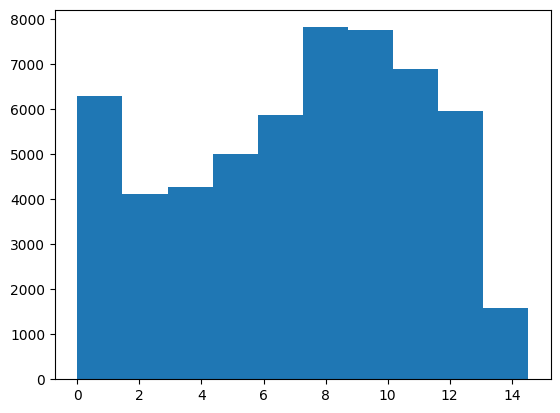

In [ ]:
plt.hist(weather_total['sol'])

In [ ]:
weather_total['sol'].describe()

count   55517.000
mean        7.158
std         3.856
min         0.000
25%         4.100
50%         7.717
75%        10.271
max        14.533
Name: sol, dtype: float64

In [ ]:
def codificar_sol(weather_file):
    #Based on the visualization of the data and the understaindg that we are talking about hours of sun (higher in summer, but high anyhow from 8 onwards):
    bins =    [0, 2.25, 4.50, 6.75, 9.00, 15.00]
    weather_file['sol_new'] = pd.cut(weather_file['sol'], bins = bins, labels = [1, 2, 3, 4, 5])
    weather_file = weather_file.drop(columns = 'sol', axis = 1)
    weather_file = weather_file.rename(columns = {'sol_new':'sol'})
    #We want it to be in numerical format
    weather_file['sol'] = weather_file['sol'].astype('float64')
    #It will return some NA valyes due to not be a closed intervals in btoh sides.    
    return weather_file

In [ ]:
weather_total = codificar_sol(weather_total)

In [ ]:
weather_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55517 entries, 0 to 55516
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               55517 non-null  datetime64[ns]
 1   comunidad_autonoma  55517 non-null  object        
 2   CODAUTO             55517 non-null  int64         
 3   tmed                55517 non-null  float64       
 4   prec                55517 non-null  float64       
 5   tmin                55517 non-null  float64       
 6   tmax                55517 non-null  float64       
 7   dir                 55517 non-null  float64       
 8   velmedia            55517 non-null  float64       
 9   racha               55517 non-null  float64       
 10  AGUA_TOTAL          55517 non-null  float64       
 11  AGUA_ACTUAL         55517 non-null  float64       
 12  sol                 54173 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), o

In [ ]:
#Let's consolidate all these steps into a function:

def consolidate_weather_codpro_embalses(weather_file, codpro_file, embalses_file):

    #Crossing files:
    weather_complete = pd.merge(weather_file, codpro_file, how = 'left', on= 'provincia')
    weather_complete = pd.merge(weather_complete, embalses_file, how = 'left', on = ['fecha', 'provincia'])

    #Replacing NAs for water info:
    weather_complete['AGUA_TOTAL'] = weather_complete['AGUA_TOTAL'].fillna(0)
    weather_complete['AGUA_ACTUAL'] = weather_complete['AGUA_ACTUAL'].fillna(0)

    #Reducing dimensionality to CCAA:
    weather_complete = weather_complete.groupby(['fecha', 'comunidad_autonoma', 'CODAUTO'], as_index = False).agg(
    {'tmed': 'mean',
     'prec': 'mean',
     'tmin': 'mean',
     'tmax': 'mean',
     'dir': 'mean',
     'velmedia': 'mean',
     'racha': 'mean',
     'sol': 'mean',
     'AGUA_TOTAL': 'sum',
     'AGUA_ACTUAL': 'sum',}).round(3)
    
    #filling pending NA values
    
    float_cols = weather_complete.select_dtypes(include=['float64']).columns
    weather_complete[float_cols] = weather_complete[float_cols].fillna(0)

    return weather_complete

Now we are matching this info with generation file. However, some names have to be modified in generation file, otherwise is not going to work.

In [ ]:
generation_dataframe.head(10)

fecha      comunidad_autonoma    Eólica  Hidráulica  \
0 2015-01-01               ANDALUCIA 10798.051    1066.442   
1 2015-01-01        REGION DE MURCIA  1053.468     213.288   
2 2015-01-01  PRINCIPADO DE ASTURIAS  1843.570    4194.670   
3 2015-01-01              PAIS VASCO   526.734    1635.210   
4 2015-01-01                LA RIOJA  2282.515     426.577   
5 2015-01-01          ISLAS BALEARES     0.000       0.000   
6 2015-01-01                 GALICIA 11675.941   21826.503   
7 2015-01-01             EXTREMADURA     0.000    1848.499   
8 2015-01-01    COMUNIDAD VALENCIANA  5706.287     782.057   
9 2015-01-01          ISLAS CANARIAS   702.312       0.000   

   Solar fotovoltaica  Solar térmica  inst_Eólica  inst_Hidráulica  \
0            3949.598       3932.111     3325.380          588.910   
1            2023.923         76.933      262.780           34.100   
2               0.000          0.000      518.450          804.980   
3              39.299          0.000      159.720          174.020   
4             255.447          0.000      448.120           52.430   
5             255.447          0.000        3.650            0.000   
6              39.299          0.000     3309.700         3685.500   
7            2534.817       2872.151        0.000         2277.360   
8            1395.132        222.250     1193.240          641.890   
9             687.741          0.000      152.280            1.520   

   inst_Solar fotovoltaica  inst_Solar_térmica  
0                  875.280            1000.020  
1                  437.860              31.400  
2                    0.790               0.000  
3                   26.620               0.000  
4                   85.600               0.000  
5                   78.080               0.000  
6                   16.470               0.000  
7                  563.860             849.000  
8                  347.960              49.900  
9                  167.660               0.000

In [ ]:
generation_dataframe['comunidad_autonoma'].unique() #(Ceuta is not there! we shoud remove it after)

array(['ANDALUCIA', 'REGION DE MURCIA', 'PRINCIPADO DE ASTURIAS',
       'PAIS VASCO', 'LA RIOJA', 'ISLAS BALEARES', 'GALICIA',
       'EXTREMADURA', 'COMUNIDAD VALENCIANA', 'ISLAS CANARIAS',
       'COMUNIDAD DE NAVARRA', 'COMUNIDAD DE MADRID', 'CATALUNA',
       'CASTILLA- LA MANCHA', 'CASTILLA Y LEON', 'CANTABRIA', 'ARAGON',
       'COMUNIDAD MELILLA'], dtype=object)

In [ ]:
weather_total['comunidad_autonoma'].unique()

array(['ANDALUCIA', 'ARAGON', 'CANARIAS', 'CANTABRIA', 'CASTILLA Y LEON',
       'CASTILLA-LA MANCHA', 'CATALUNA', 'CEUTA', 'COMUNIDAD DE MADRID',
       'COMUNIDAD FORAL DE NAVARRA', 'COMUNITAT VALENCIANA',
       'EXTREMADURA', 'GALICIA', 'ILLES BALEARS', 'LA RIOJA', 'MELILLA',
       'PAIS VASCO', 'PRINCIPADO DE ASTURIAS', 'REGION DE MURCIA'],
      dtype=object)

In [66]:
def REE_ccaa_rename(dataframe):
    dataframe['comunidad_autonoma'] = dataframe['comunidad_autonoma'].replace({'CASTILLA- LA MANCHA': 'CASTILLA-LA MANCHA',
                                                                                          'COMUNIDAD DE NAVARRA': 'COMUNIDAD FORAL DE NAVARRA',
                                                                                          'COMUNIDAD MELILLA':'MELILLA',
                                                                                          'COMUNIDAD VALENCIANA': 'COMUNITAT VALENCIANA',
                                                                                          'ISLAS BALEARES': 'ILLES BALEARS',
                                                                                          'ISLAS CANARIAS': 'CANARIAS',
                                                                                          })
    return dataframe

In [ ]:
generation_dataframe= REE_ccaa_rename(generation_dataframe)

In [ ]:
#Let's combine finally! weather and generation data:

def consolidatet_generation_weather(weather_total_file, generation_file):

    #Let's drop Ceuta values from weather file:

    weather_total_file = weather_total_file[weather_total_file['comunidad_autonoma'] != 'CEUTA']

    consolidated_df = pd.merge(weather_total_file, generation_file, how = 'left', on = ['fecha', 'comunidad_autonoma'])

    return consolidated_df

    

In [ ]:
consolidated_df = consolidatet_generation_weather(weather_total, generation_dataframe)

In [ ]:
consolidated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52595 entries, 0 to 52594
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fecha                    52595 non-null  datetime64[ns]
 1   comunidad_autonoma       52595 non-null  object        
 2   CODAUTO                  52595 non-null  int64         
 3   tmed                     52595 non-null  float64       
 4   prec                     52595 non-null  float64       
 5   tmin                     52595 non-null  float64       
 6   tmax                     52595 non-null  float64       
 7   dir                      52595 non-null  float64       
 8   velmedia                 52595 non-null  float64       
 9   racha                    52595 non-null  float64       
 10  AGUA_TOTAL               52595 non-null  float64       
 11  AGUA_ACTUAL              52595 non-null  float64       
 12  sol                      51351 n

In [ ]:
consolidated_df.head(20)

fecha          comunidad_autonoma  CODAUTO   tmed  prec   tmin   tmax  \
0  2015-01-01                   ANDALUCIA        1  8.434 0.000  1.429 15.422   
1  2015-01-01                      ARAGON        2  5.167 0.000 -2.033 12.383   
2  2015-01-01                    CANARIAS        5 17.250 0.000 15.012 19.519   
3  2015-01-01                   CANTABRIA        6  7.357 0.000  1.100 13.657   
4  2015-01-01             CASTILLA Y LEON        7  4.191 0.000 -3.507 11.926   
5  2015-01-01          CASTILLA-LA MANCHA        8  3.808 0.000 -4.004 11.616   
6  2015-01-01                    CATALUNA        9  5.164 0.000 -0.615 10.935   
7  2015-01-01         COMUNIDAD DE MADRID       13  4.682 0.000 -2.536 11.900   
8  2015-01-01  COMUNIDAD FORAL DE NAVARRA       15  5.883 0.000 -2.383 14.150   
9  2015-01-01        COMUNITAT VALENCIANA       10  7.670 0.000  1.302 14.046   
10 2015-01-01                 EXTREMADURA       11  6.156 0.000 -1.866 14.190   
11 2015-01-01                     GALICIA       12  6.403 0.000 -0.550 13.367   
12 2015-01-01               ILLES BALEARS        4  8.620 0.100  3.820 13.400   
13 2015-01-01                    LA RIOJA       17  7.900 0.000  1.900 13.900   
14 2015-01-01                     MELILLA       19  9.800 0.000  3.400 16.100   
15 2015-01-01                  PAIS VASCO       16  4.657 0.100 -2.482 11.777   
16 2015-01-01      PRINCIPADO DE ASTURIAS        3  8.080 0.000  2.540 13.630   
17 2015-01-01            REGION DE MURCIA       14  8.750 0.000  2.810 14.680   
18 2015-01-02                   ANDALUCIA        1  9.280 0.000  2.426 16.128   
19 2015-01-02                      ARAGON        2  5.898 0.000 -1.613 13.408   

      dir  velmedia  racha  ...  AGUA_ACTUAL   sol    Eólica  Hidráulica  \
0  22.818     2.400  8.297  ...       51.390 4.000 10798.051    1066.442   
1  29.417     1.818  8.428  ...     2006.580 4.000  9217.848    6469.745   
2  44.292     4.779 12.431  ...        0.000 2.000   702.312       0.000   
3  35.500     1.867  5.083  ...       73.410 4.000    87.789     853.153   
4  26.646     1.653  5.680  ...     4029.590 4.000 17821.173   17774.025   
5  17.677     1.124  5.523  ...      147.160 4.000 14924.135    1848.499   
6  40.854     1.715  6.598  ...      363.000 4.000  6408.599   10451.127   
7  22.667     0.878  5.722  ...        0.000 4.000     0.000     284.384   
8  37.200     1.600  9.900  ...       34.950 4.000  4740.608    1635.210   
9  19.722     1.805  6.128  ...      118.100 4.000  5706.287     782.057   
10 20.166     1.592  5.267  ...     3892.760 4.000     0.000    1848.499   
11 41.666     1.010  4.416  ...     1938.350 4.000 11675.941   21826.503   
12 15.900     2.300 10.070  ...        0.000 3.000     0.000       0.000   
13 27.000     3.100  8.300  ...        0.000 4.000  2282.515     426.577   
14  6.000     2.200  6.700  ...        0.000 5.000     0.000       0.000   
15 63.711     1.180  4.061  ...      223.180 4.000   526.734    1635.210   
16 20.222     1.920  6.078  ...      291.880 4.000  1843.570    4194.670   
17 22.875     1.525  6.600  ...        0.000 4.000  1053.468     213.288   
18 32.508     1.768  6.352  ...       50.700 4.000  6771.901    1528.352   
19 20.000     1.025  4.728  ...     2003.070 4.000  5780.891    9272.000   

    Solar fotovoltaica  Solar térmica  inst_Eólica  inst_Hidráulica  \
0             3949.598       3932.111     3325.380          588.910   
1              609.142          0.000     1904.820         1338.290   
2              687.741          0.000      152.280            1.520   
3                0.000          0.000       35.310           98.840   
4             1670.228          0.000     5556.380         4394.760   
5             4539.090       1384.787     3798.930          651.110   
6              825.289         51.288     1279.310         1918.640   
7              196.497          0.000        0.000          108.520   
8              609.142          0.000      983.200          237.700   

### 1.5 Demand Data

There is still one last target we want to predict, which is the energetic demand, in order to see  how much of that demand could be covered by the renovable production expected in accordance to our model.
It is possible to obtain demand data also from REE, and it would be useful to download it also by CCAA in order to have it in the same structure that the generation and weather data.

The demand files will include the information of the date (in a motnhly or daily basis) and the demand'Demanda b.C' in MWh, which means '"Demand at p.s. (power station bars)
Energy injected into the network from generation plants and imports, minus pumping consumption and exports."

In [64]:
#First of all, let's download the information related to the total demand in a daily basis:

def data_REE_demand(yearini, yearend): # -> REE API Only allows to extract data in a yearly basis

     #First we get the response from REE (It only allow us to see one year each time)

    years = range(yearini,yearend + 1)
    data_consolidated = pd.DataFrame(columns= ['value', 'percentage', 'datetime'])

    for year in years:

        demand = requests.get(f"https://apidatos.ree.es/es/datos/demanda/evolucion?start_date={year}-01-01T00:00&end_date={year}-12-31T23:59&time_trunc=day")

        #Data comes in a json with dictionaries inside. To access to the data we have to proccess it a little bit with json and dictionary methods.

        demand = demand.json()['included']
        demand = pd.DataFrame.from_dict(demand)['attributes']
        demand = pd.json_normalize(demand)
        demand = demand['values']

        #We create a for loop in order to access to all data in the dicionary and to get the complete list for all the energetic resources

        for value in demand:
    
            data = pd.DataFrame.from_dict(value)
            data_consolidated = pd.concat([data_consolidated, data])

    #Let's take the opportunity for already preparing the field 'month' in order to cross the file afterwards:

    data_consolidated['datetime'] = data_consolidated['datetime'].str[:10]
    data_consolidated['datetime'] = pd.to_datetime(data_consolidated['datetime'])
    data_consolidated['month'] = data_consolidated['datetime'].dt.to_period('M')

    return data_consolidated

In [ ]:
#demand_daily.to_csv('./Data/Demand/Demand_2015_2022.csv')

In [ ]:
demand_daily = drive_read_file(url_demand)


Downloading...
From: https://drive.google.com/uc?id=1f0VtPLUQtxXNr7M1YDWZtsiyecBy238P
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Demand_2015_2022.csv
100%|██████████| 104k/104k [00:00<00:00, 633kB/s]


In [ ]:
def transform_demand_daily(demand_daily_file):
    demand_daily_file = demand_daily_file.drop(columns = 'Unnamed: 0')
    demand_daily_file['datetime'] = pd.to_datetime(demand_daily_file['datetime'])
    demand_daily_file['month'] = demand_daily_file['datetime'].dt.to_period('M')
    return demand_daily_file



In [ ]:
demand_daily = transform_demand_daily(demand_daily)

In [ ]:
demand_daily.head()

value  percentage   datetime    month
0 603961.474           1 2015-01-01  2015-01
1 715038.679           1 2015-01-02  2015-01
2 698648.512           1 2015-01-03  2015-01
3 663533.254           1 2015-01-04  2015-01
4 714784.323           1 2015-01-05  2015-01

In [ ]:
demand_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   value       2922 non-null   float64       
 1   percentage  2922 non-null   int64         
 2   datetime    2922 non-null   datetime64[ns]
 3   month       2922 non-null   period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), period[M](1)
memory usage: 91.4 KB


In [ ]:
def data_REE_demand_by_CCAA(yearini, yearend): # -> REE API Only allows to extract data in a yearly basis

     #First we get the response from REE (It only allow us to see one year each time)

    years = range(yearini,yearend + 1)

    data_consolidated = pd.DataFrame(columns= ['comunidad_autonoma', 'month', 'demand_ccaa'])
    
    all_data = []

    
    for year in years:

        
        demand = requests.get(f"https://apidatos.ree.es/es/datos/demanda/evolucion?start_date={year}-01-01T00:00&end_date={year}-12-31T23:59&time_trunc=month&all_ccaa=allCcaa")

        #Data comes in a json with dictionaries inside. To access to the data we have to proccess it a little bit with json and dictionary methods.
        
        demand = demand.json()['included']
        for element in demand:
            comunidad_autonoma = element['community_name']
            
            for attribute in element['content']['attributes']['values']:
                month = attribute['datetime']
                demand_ccaa = attribute['value']
                all_data.append({
                    'comunidad_autonoma': comunidad_autonoma,
                    'month': month,
                    'demand_ccaa': demand_ccaa
                })
        time.sleep(3.0)
    # Create a DataFrame from all the collected data
    data_consolidated = pd.DataFrame(all_data)

    return data_consolidated

In [ ]:
#Let's get the information of the demand by CCAA for the years range we are interested in:
#demand_by_CCAA = data_REE_demand_by_CCAA(2015,2022) In case we do not have the file downloaded


In [ ]:
demand_by_CCAA = drive_read_file(url_demand_by_ccaa).drop(columns = 'Unnamed: 0')

Downloading...
From: https://drive.google.com/uc?id=1YGsqSUgKPtmJMe1Xch9A_C3rAMy0udSK
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Demand_by_ccaa.csv
100%|██████████| 116k/116k [00:00<00:00, 2.05MB/s]


In [ ]:
demand_by_CCAA.tail(20)

comunidad_autonoma                          month  demand_ccaa
1900         País Vasco  2022-05-01T00:00:00.000+02:00  1348281.478
1901         País Vasco  2022-06-01T00:00:00.000+02:00  1312495.187
1902         País Vasco  2022-07-01T00:00:00.000+02:00  1279878.110
1903         País Vasco  2022-08-01T00:00:00.000+02:00   994593.405
1904         País Vasco  2022-09-01T00:00:00.000+02:00  1226517.015
1905         País Vasco  2022-10-01T00:00:00.000+02:00  1278127.654
1906         País Vasco  2022-11-01T00:00:00.000+01:00  1280926.034
1907         País Vasco  2022-12-01T00:00:00.000+01:00  1200907.471
1908              Todas  2022-01-01T00:00:00.000+01:00 22729295.932
1909              Todas  2022-02-01T00:00:00.000+01:00 20168155.371
1910              Todas  2022-03-01T00:00:00.000+01:00 21475748.762
1911              Todas  2022-04-01T00:00:00.000+02:00 19589011.223
1912              Todas  2022-05-01T00:00:00.000+02:00 20301232.670
1913              Todas  2022-06-01T00:00:00.000+02:00 21330346.609
1914              Todas  2022-07-01T00:00:00.000+02:00 23635828.919
1915              Todas  2022-08-01T00:00:00.000+02:00 22011563.581
1916              Todas  2022-09-01T00:00:00.000+02:00 20309641.191
1917              Todas  2022-10-01T00:00:00.000+02:00 19330228.099
1918              Todas  2022-11-01T00:00:00.000+01:00 19351584.224
1919              Todas  2022-12-01T00:00:00.000+01:00 20283038.561

In [ ]:
demand_by_CCAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   comunidad_autonoma  1920 non-null   object 
 1   month               1920 non-null   object 
 2   demand_ccaa         1920 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.1+ KB


In [ ]:
#Let's transform demand_by_CCAA file in roder to match it with the other files as we have made with generation files:

def demand_by_CCAA_process(demand_by_CCAA_file):
    
    #We are not including the total 'todas' in the final df. Naames can be updated already:

    demand_by_CCAA_file = demand_by_CCAA_file[demand_by_CCAA_file['comunidad_autonoma'] != 'Todas']
    demand_by_CCAA_file['comunidad_autonoma'] = demand_by_CCAA_file['comunidad_autonoma'].apply(unidecode).str.upper()

    #First we need 'month' in a format we can match:
    demand_by_CCAA_file['month'] = demand_by_CCAA_file['month'].str[:10]
    demand_by_CCAA_file['month'] = pd.to_datetime(demand_by_CCAA_file['month'])
    demand_by_CCAA_file['month'] = demand_by_CCAA_file['month'].dt.to_period('M')

    #Now we create the column 'percentage' from the same dataframe, by dividing each CCAA per total for each month.

    demand_by_CCAA_file_A = demand_by_CCAA_file.groupby('month')['demand_ccaa'].sum()
    demand_by_CAA_total = pd.merge(demand_by_CCAA_file, demand_by_CCAA_file_A, how = 'left', on = 'month')
    demand_by_CAA_total['percentage'] = demand_by_CAA_total['demand_ccaa_x']/demand_by_CAA_total['demand_ccaa_y']


    return demand_by_CAA_total

In [ ]:
demand_by_CCAA_percent = demand_by_CCAA_process(demand_by_CCAA)
demand_by_CCAA_percent.head(13)

/tmp/ipykernel_4697/2639149916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_by_CCAA_file['comunidad_autonoma'] = demand_by_CCAA_file['comunidad_autonoma'].apply(unidecode).str.upper()
/tmp/ipykernel_4697/2639149916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_by_CCAA_file['month'] = demand_by_CCAA_file['month'].str[:10]
/tmp/ipykernel_4697/2639149916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

comunidad_autonoma    month  demand_ccaa_x  demand_ccaa_y  percentage
0           ANDALUCIA  2015-01    3485428.721   23850778.392       0.146
1           ANDALUCIA  2015-02    3167179.074   22079124.472       0.143
2           ANDALUCIA  2015-03    3150607.517   22320622.586       0.141
3           ANDALUCIA  2015-04    2809896.497   19913745.873       0.141
4           ANDALUCIA  2015-05    3047140.450   21024441.899       0.145
5           ANDALUCIA  2015-06    3184114.599   21582825.533       0.148
6           ANDALUCIA  2015-07    3923735.479   24945739.096       0.157
7           ANDALUCIA  2015-08    3621936.219   22320043.772       0.162
8           ANDALUCIA  2015-09    3034131.643   20847347.155       0.146
9           ANDALUCIA  2015-10    2956529.323   20958912.989       0.141
10          ANDALUCIA  2015-11    2921433.923   20962118.878       0.139
11          ANDALUCIA  2015-12    3236452.127   22002733.898       0.147
12             ARAGON  2015-01     903645.512   23850778.392       0.038

In [ ]:
demand_by_CCAA_percent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   comunidad_autonoma  1824 non-null   object   
 1   month               1824 non-null   period[M]
 2   demand_ccaa_x       1824 non-null   float64  
 3   demand_ccaa_y       1824 non-null   float64  
 4   percentage          1824 non-null   float64  
dtypes: float64(3), object(1), period[M](1)
memory usage: 71.4+ KB


In [ ]:
#Let's check if it has worked:
demand_by_CCAA_percent.groupby('month')['percentage'].sum()

month
2015-01   1.000
2015-02   1.000
2015-03   1.000
2015-04   1.000
2015-05   1.000
           ... 
2022-08   1.000
2022-09   1.000
2022-10   1.000
2022-11   1.000
2022-12   1.000
Freq: M, Name: percentage, Length: 96, dtype: float64

All the information related to demand is ready, it is only necessary to cross the files between them and, afterwards, to cross it with 'consolidated_df' file:

In [ ]:
def cross_demand_files (demand_file, demand_by_CCAA_file_processed):
    
    #We are creating a list with the information of the CCAA:
    

    ccaa_list =  list(demand_by_CCAA_file_processed['comunidad_autonoma'].unique())
    range_dates = pd.date_range(demand_file['datetime'].min(), demand_file['datetime'].max(), freq= 'd')

    #For each day we are creating a new dataframe with several rows based on CCAA:
    new_list = []

    for fecha in range_dates:
        for ccaa in ccaa_list:
            new_list.append({'datetime': fecha, 'comunidad_autonoma': ccaa})

    demand_total = pd.DataFrame(new_list)
    demand_total['datetime'] = pd.to_datetime(demand_total['datetime'])
    #It is not necessary to have 'percentage' or te values of the monthly demand on the files:

    demand_file = demand_file.drop(columns = 'percentage', axis = 1)
    demand_by_CCAA_file_processed = demand_by_CCAA_file_processed.drop(columns = ['demand_ccaa_x', 'demand_ccaa_y'], axis = 1)

    #The template with the columns to fulfilled has been created. Now we have to match it with the other files:

    demand_total = pd.merge(demand_total, demand_file, how = 'left', on = 'datetime')
    demand_total = pd.merge(demand_total, demand_by_CCAA_file_processed, how = 'left', on = ['comunidad_autonoma','month'])
    demand_total['value_ccaa'] = (demand_total['percentage']*demand_total['value']).round(3)
    

    #Let's clean a little bit the file:

    demand_total = demand_total.rename(columns = {'datetime':'fecha',
                                                  'value_ccaa': 'demand_ccaa'})   
    
    demand_total = demand_total.drop(columns = ['value', 'month', 'percentage'])

    #Let's create a binary column that indicates if the day is a weekday or not, as it can be important for the anaysis:

    demand_total['Weekday'] = demand_total['fecha'].dt.day_name().apply(lambda x:1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)
    

    return demand_total

In [ ]:
demand_total = cross_demand_files(demand_daily, demand_by_CCAA_percent)

In [ ]:
demand_total

fecha      comunidad_autonoma  demand_ccaa  Weekday
0     2015-01-01               ANDALUCIA    88259.789        1
1     2015-01-01                  ARAGON    22882.569        1
2     2015-01-01  PRINCIPADO DE ASTURIAS    24214.850        1
3     2015-01-01               CANTABRIA     9493.101        1
4     2015-01-01     CASTILLA- LA MANCHA    27083.707        1
...          ...                     ...          ...      ...
55513 2022-12-31                LA RIOJA     3574.873        0
55514 2022-12-31       COMUNIDAD MELILLA      418.708        0
55515 2022-12-31        REGION DE MURCIA    19444.388        0
55516 2022-12-31    COMUNIDAD DE NAVARRA    10734.124        0
55517 2022-12-31              PAIS VASCO    33112.761        0

[55518 rows x 4 columns]

In [ ]:
#We need to transform again 'comunidad_autontoma', otherwise it will fail. We can use a functionwe already created before for generation file:

demand_total = REE_ccaa_rename(demand_total)
demand_total

fecha          comunidad_autonoma  demand_ccaa  Weekday
0     2015-01-01                   ANDALUCIA    88259.789        1
1     2015-01-01                      ARAGON    22882.569        1
2     2015-01-01      PRINCIPADO DE ASTURIAS    24214.850        1
3     2015-01-01                   CANTABRIA     9493.101        1
4     2015-01-01          CASTILLA-LA MANCHA    27083.707        1
...          ...                         ...          ...      ...
55513 2022-12-31                    LA RIOJA     3574.873        0
55514 2022-12-31                     MELILLA      418.708        0
55515 2022-12-31            REGION DE MURCIA    19444.388        0
55516 2022-12-31  COMUNIDAD FORAL DE NAVARRA    10734.124        0
55517 2022-12-31                  PAIS VASCO    33112.761        0

[55518 rows x 4 columns]

In [ ]:
#For merging the file we can use a funciton that we already created for generation:

consolidated_df = consolidatet_generation_weather(consolidated_df, demand_total)

#### Now we finally have the full dataset we are going to work with :)

In [ ]:
consolidated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52595 entries, 0 to 52594
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fecha                    52595 non-null  datetime64[ns]
 1   comunidad_autonoma       52595 non-null  object        
 2   CODAUTO                  52595 non-null  int64         
 3   tmed                     52595 non-null  float64       
 4   prec                     52595 non-null  float64       
 5   tmin                     52595 non-null  float64       
 6   tmax                     52595 non-null  float64       
 7   dir                      52595 non-null  float64       
 8   velmedia                 52595 non-null  float64       
 9   racha                    52595 non-null  float64       
 10  AGUA_TOTAL               52595 non-null  float64       
 11  AGUA_ACTUAL              52595 non-null  float64       
 12  sol                      51351 n

In [ ]:
consolidated_df.head(15)

fecha          comunidad_autonoma  CODAUTO   tmed  prec   tmin   tmax  \
0  2015-01-01                   ANDALUCIA        1  8.434 0.000  1.429 15.422   
1  2015-01-01                      ARAGON        2  5.167 0.000 -2.033 12.383   
2  2015-01-01                    CANARIAS        5 17.250 0.000 15.012 19.519   
3  2015-01-01                   CANTABRIA        6  7.357 0.000  1.100 13.657   
4  2015-01-01             CASTILLA Y LEON        7  4.191 0.000 -3.507 11.926   
5  2015-01-01          CASTILLA-LA MANCHA        8  3.808 0.000 -4.004 11.616   
6  2015-01-01                    CATALUNA        9  5.164 0.000 -0.615 10.935   
7  2015-01-01         COMUNIDAD DE MADRID       13  4.682 0.000 -2.536 11.900   
8  2015-01-01  COMUNIDAD FORAL DE NAVARRA       15  5.883 0.000 -2.383 14.150   
9  2015-01-01        COMUNITAT VALENCIANA       10  7.670 0.000  1.302 14.046   
10 2015-01-01                 EXTREMADURA       11  6.156 0.000 -1.866 14.190   
11 2015-01-01                     GALICIA       12  6.403 0.000 -0.550 13.367   
12 2015-01-01               ILLES BALEARS        4  8.620 0.100  3.820 13.400   
13 2015-01-01                    LA RIOJA       17  7.900 0.000  1.900 13.900   
14 2015-01-01                     MELILLA       19  9.800 0.000  3.400 16.100   

      dir  velmedia  racha  ...    Eólica  Hidráulica  Solar fotovoltaica  \
0  22.818     2.400  8.297  ... 10798.051    1066.442            3949.598   
1  29.417     1.818  8.428  ...  9217.848    6469.745             609.142   
2  44.292     4.779 12.431  ...   702.312       0.000             687.741   
3  35.500     1.867  5.083  ...    87.789     853.153               0.000   
4  26.646     1.653  5.680  ... 17821.173   17774.025            1670.228   
5  17.677     1.124  5.523  ... 14924.135    1848.499            4539.090   
6  40.854     1.715  6.598  ...  6408.599   10451.127             825.289   
7  22.667     0.878  5.722  ...     0.000     284.384             196.497   
8  37.200     1.600  9.900  ...  4740.608    1635.210             609.142   
9  19.722     1.805  6.128  ...  5706.287     782.057            1395.132   
10 20.166     1.592  5.267  ...     0.000    1848.499            2534.817   
11 41.666     1.010  4.416  ... 11675.941   21826.503              39.299   
12 15.900     2.300 10.070  ...     0.000       0.000             255.447   
13 27.000     3.100  8.300  ...  2282.515     426.577             255.447   
14  6.000     2.200  6.700  ...     0.000       0.000               0.000   

    Solar térmica  inst_Eólica  inst_Hidráulica  inst_Solar fotovoltaica  \
0        3932.111     3325.380          588.910                  875.280   
1           0.000     1904.820         1338.290                  168.540   
2           0.000      152.280            1.520                  167.660   
3           0.000       35.310           98.840                    2.100   
4           0.000     5556.380         4394.760                  494.100   
5        1384.787     3798.930          651.110                  923.420   
6          51.288     1279.310         1918.640                  266.430   
7           0.000        0.000          108.520                   63.360   
8           0.000      983.200          237.700                  160.610   
9         222.250     1193.240          641.890                  347.960   
10       2872.151        0.000         2277.360                  563.860   
11          0.000     3309.700         3685.500                   16.470   
12          0.000        3.650            0.000                   78.080   
13          0.000      448.120           52.430                   85.600   
14          0.000        0.000            0.000                    0.060   

    inst_Solar_térmica  demand_ccaa  Weekday  
0             1000.020    88259.789        1  
1                0.000    22882.569        1  
2                0.000    18441.931        1  
3                0.000     9493.101        1  
4                0.000    

### 1.6 Data Visualization

After compilling and consolidating all the information from the different sources, it is time to use 'matplotlib' & 'seaborn' libraries to plot the data in order to achieve a better understanding of the figures we are analyzing.
It is going to be a good way to already identify which variables are the most relevant to explain the generation of each energetic technology, and also to see if 'demand' is dependant of some of teh weather variables that are included in the dataframe.
First of all, we are utilizing also 'pandas profiling' as a first step to watch the relation between the variables on the dataset.


In [ ]:
#Let's create the Pandas Profile to see if we can extract some conclusions:
#pandas_profiling.ProfileReport(consolidated_df)

The main conclussion that we can get from the 'Pandas Profile' is that the zero_values are so high in several generation target variables. This is due to the fact that we have included all the 'Comunidades Autónomas' for each day, but each technology is developed or focused on several CCAAs, not in all of them. A good procedure, then, would be to treate in different dataframes teh different technoglies from this point onwards as we were doing with the other notebooks as the first steps of teh project. That would help to better identify which variables have more impact for each technology, and would be easier to create the models.

Some conclusions related to the variables affecting to the production of each technology that can be extracted from the heat map from below of the Pandas Profile: :

    - Solar Fotovoltraica: Seems to be related tp 'sol' - that was expected-  an temperature variables, but it also has an interesting negative relation with prec and wind. Prec is obvious, but it is wind related to colienality or it is related to some topics like the pones explained in this article?: https://www.tecnicaindustrial.es/el-viento-principal-problema-al-que-se-enfrentan-las-plantas-fotovoltaicas/ We are maintaining wind variables.
    - SOlar Térmica: quite similar relations to Solar Fotovoltaica.
    - Eólica: Related to wind variables and 'prec'. We will have to analyze the picture per CCAA to have a better understanding.
    - Hidráulica: Directly related to the information we received ffrom the dams ('AGUA_ACTUAL' & AGUA_TOTAL') and temperature.
    - Demand: Related to temperature and also to 'weekday'

In [ ]:
#Firstly to check if 'solar térmica' productive CCAAs are included in 'solar fotovoltaica' productive CCAAs so we can just create one filter
consolidated_df[consolidated_df['Solar térmica'] != 0]['comunidad_autonoma'].unique()

array(['ANDALUCIA', 'CASTILLA-LA MANCHA', 'CATALUNA',
       'COMUNITAT VALENCIANA', 'EXTREMADURA', 'REGION DE MURCIA'],
      dtype=object)

In [ ]:
consolidated_df[consolidated_df['Solar fotovoltaica'] != 0]['comunidad_autonoma'].unique()

array(['ANDALUCIA', 'ARAGON', 'CANARIAS', 'CASTILLA Y LEON',
       'CASTILLA-LA MANCHA', 'CATALUNA', 'COMUNIDAD DE MADRID',
       'COMUNIDAD FORAL DE NAVARRA', 'COMUNITAT VALENCIANA',
       'EXTREMADURA', 'GALICIA', 'ILLES BALEARS', 'LA RIOJA',
       'PAIS VASCO', 'REGION DE MURCIA'], dtype=object)

In [ ]:
#Let's filter the data:

def filter_consolidated_df(consolidated_file):

    ccaa_solartermica = consolidated_file[consolidated_file['Solar térmica'] != 0]['comunidad_autonoma'].unique()
    ccaa_solarfotovoltaica = consolidated_file[consolidated_file['Solar fotovoltaica'] != 0]['comunidad_autonoma'].unique()
    ccaa_hidraulica = consolidated_file[consolidated_file['Eólica'] != 0]['comunidad_autonoma'].unique()
    ccaa_eolica = consolidated_file[consolidated_file['Hidráulica'] != 0]['comunidad_autonoma'].unique()

    #Based on the information provided by the Pndas Profile and the other notebooks, we can drop alredy some variables that we know are not relevant for each technology:
    
    df_solartermica = consolidated_file[consolidated_file['comunidad_autonoma'].isin(ccaa_solartermica)]
    df_solartermica = df_solartermica[['fecha', 'comunidad_autonoma','tmed','tmax','velmedia','sol','Solar térmica', 'inst_Solar_térmica']] \
        .rename(columns = {'Solar térmica':'generation'})
    df_solarfotovoltaica = consolidated_file[consolidated_file['comunidad_autonoma'].isin(ccaa_solarfotovoltaica)]
    df_solarfotovoltaica = df_solarfotovoltaica[['fecha', 'comunidad_autonoma','tmed','tmax','velmedia','sol','Solar fotovoltaica', 'inst_Solar fotovoltaica']] \
        .rename(columns = {'Solar fotovoltaica':'generation'}) \
        .dropna()
    df_hidraulica = consolidated_file[consolidated_file['comunidad_autonoma'].isin(ccaa_hidraulica)]
    df_hidraulica = df_hidraulica[['fecha','comunidad_autonoma','tmed','prec','AGUA_ACTUAL','AGUA_TOTAL', 'Hidráulica', 'inst_Hidráulica']] \
        .rename(columns = {'Hidráulica':'generation'})
    df_eolica = consolidated_file[consolidated_file['comunidad_autonoma'].isin(ccaa_eolica)]
    df_eolica = df_eolica[['fecha', 'comunidad_autonoma','tmed', 'prec', 'velmedia', 'racha', 'Eólica', 'inst_Eólica']] \
        .rename(columns = {'Eólica':'generation'})
    df_demand = consolidated_file[['fecha', 'comunidad_autonoma','tmed', 'sol', 'Weekday', 'prec', 'demand_ccaa']]

    return df_solartermica, df_solarfotovoltaica, df_hidraulica, df_eolica, df_demand


    

In [ ]:
df_solartermica, df_solarfotovoltaica, df_hidraulica, df_eolica, df_demand = filter_consolidated_df(consolidated_df)

In [ ]:
#As we can see there are many less values now.This wil help in the anaylisis:
df_solartermica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17532 entries, 0 to 52594
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               17532 non-null  datetime64[ns]
 1   comunidad_autonoma  17532 non-null  object        
 2   tmed                17532 non-null  float64       
 3   tmax                17532 non-null  float64       
 4   velmedia            17532 non-null  float64       
 5   sol                 17488 non-null  float64       
 6   generation          17532 non-null  float64       
 7   inst_Solar_térmica  17532 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.2+ MB


We are saving these dataframes in a directory of the project so we can use them in the streamlit app we are preparing and it is not necessary to process all the information when running it.

In [ ]:
#In case we nmake any changes in the dataframes we are using for streamlit:
#consolidated_df.to_csv('./Processed_Dataframes/complete_df.csv')
#df_solarfotovoltaica.to_csv('./Processed_Dataframes/solarfotovoltaica_df.csv')
#df_solartermica.to_csv('./Processed_Dataframes/solartermica_df.csv')
#df_eolica.to_csv('./Processed_Dataframes/eolica_df.csv')
#df_hidraulica.to_csv('./Processed_Dataframes/hidraulica_df.csv')
#df_demand.to_csv('./Processed_Dataframes/demand_df.csv')

#### 1.6.1 Solar Fotovoltaica

In [ ]:
df_solarfotovoltaica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42991 entries, 0 to 52594
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fecha                    42991 non-null  datetime64[ns]
 1   comunidad_autonoma       42991 non-null  object        
 2   tmed                     42991 non-null  float64       
 3   tmax                     42991 non-null  float64       
 4   velmedia                 42991 non-null  float64       
 5   sol                      42991 non-null  float64       
 6   generation               42991 non-null  float64       
 7   inst_Solar fotovoltaica  42991 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 3.0+ MB


In [ ]:
def plot_correlation(df):
    cols_not_to_plot = ['fecha', 'comunidad_autonoma']
    cols_to_plot = [col for col in df.columns if col not in cols_not_to_plot]
    sns.pairplot(df[cols_to_plot],diag_kind='hist')

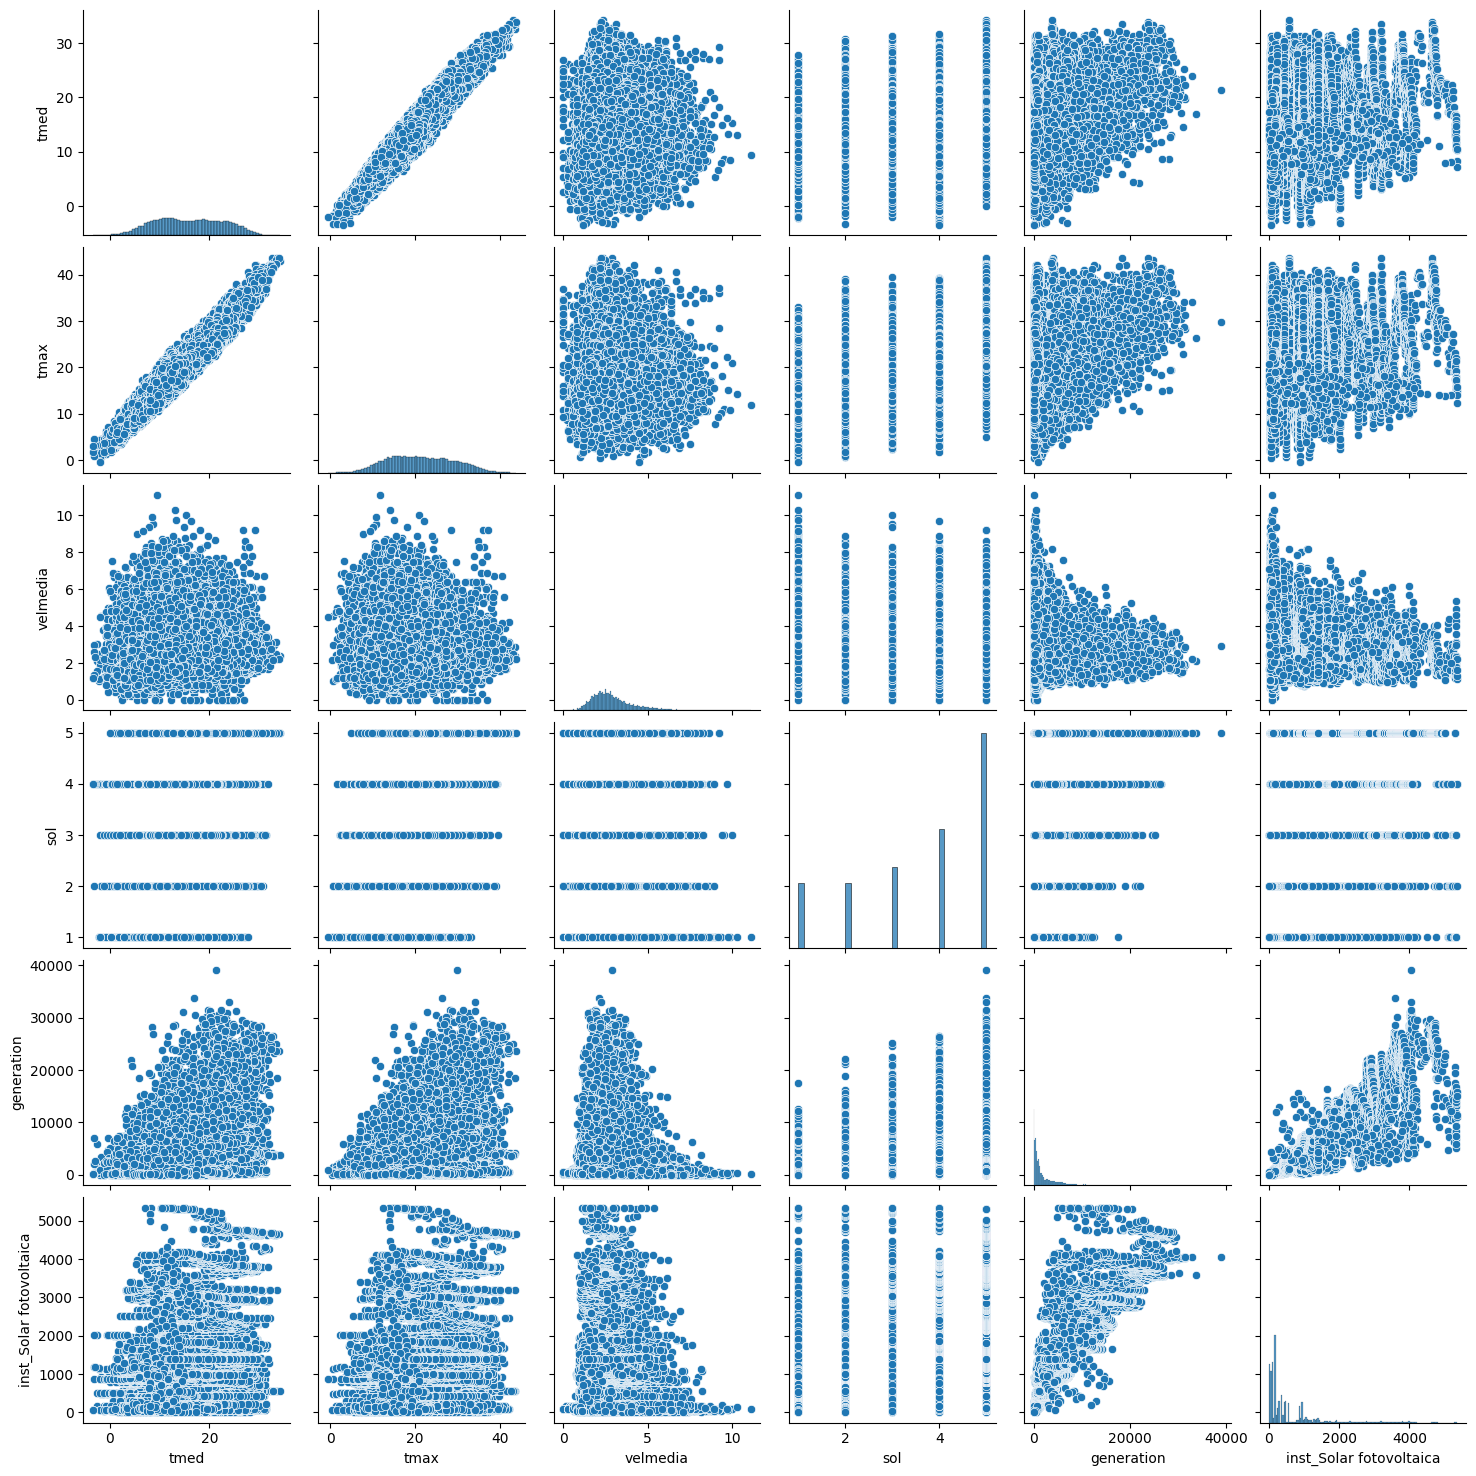

In [ ]:
plot_correlation(df_solarfotovoltaica)

It is a similar plot to the heat map we have seen in Pandas Profile. therefore, the conclusions 'apparently' were right and seems to be a correlation between the choosen variables. 
In some variables as 'generation' it seems to ne a -non normal- distribution. Besides that, there are differences between the dimensions in which the variables are represented: tmed is in Cª, generation in MW/H...Therefore it seems that it will be necessary to normalizae/escalate dataframes in order to have all the variables in the same way.

Let's replicate now the heatmap for this technology:

In [ ]:
def plot_heatmap(df):
    
    cols_not_to_plot = ['fecha', 'CODAUTO', 'comunidad_autonoma']
    cols_to_plot = [col for col in df.columns if col not in cols_not_to_plot]
    corr = df[cols_to_plot].corr()
    sns.heatmap(corr,
                cmap='crest',
                linewidth = .2)
    plt.show()

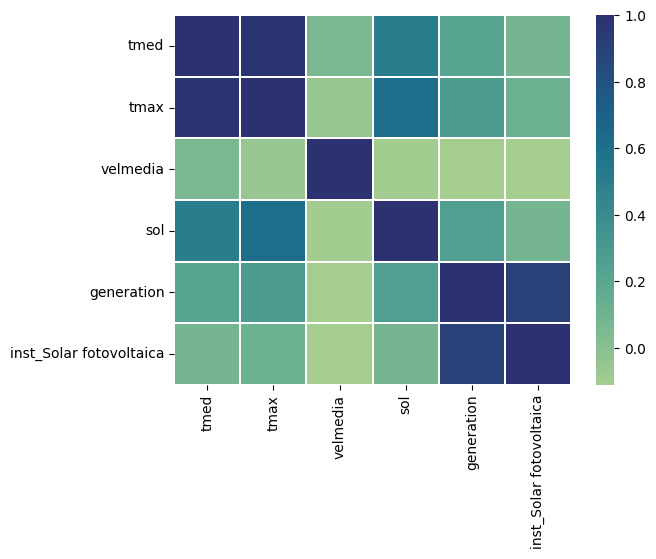

In [ ]:
plot_heatmap(df_solarfotovoltaica)

In [ ]:
f = df_solarfotovoltaica[df_solarfotovoltaica['fecha'].dt.year == 2015]
f.groupby(f['fecha'].dt.month)['generation'].sum()

fecha
1    514996.435
2    493102.118
3    706810.126
4    755020.354
5    923952.507
6    890984.637
7    934090.860
8    830365.214
9    716918.411
10   535219.148
11   526515.376
12   389029.532
Name: generation, dtype: float64

Let's see how the distribution of energetic production is during the years:

In [ ]:
def plot_generation_evolution(dataframe):

    years = dataframe['fecha'].dt.year.unique()

    plt.figure(figsize = (12,6))

    for year in years:
    
        year_data = dataframe[dataframe['fecha'].dt.year == year]
        year_monthly_sum = year_data.groupby(year_data['fecha'].dt.month)['generation'].sum()
        plt.plot(year_monthly_sum.index, year_monthly_sum.values, label=year)
    plt.xlabel('Month')
    plt.ylabel('Energetic production')
    plt.legend()
    plt.grid(True)
    plt.title(f'Evolution of generation', fontsize=16)
    plt.show()


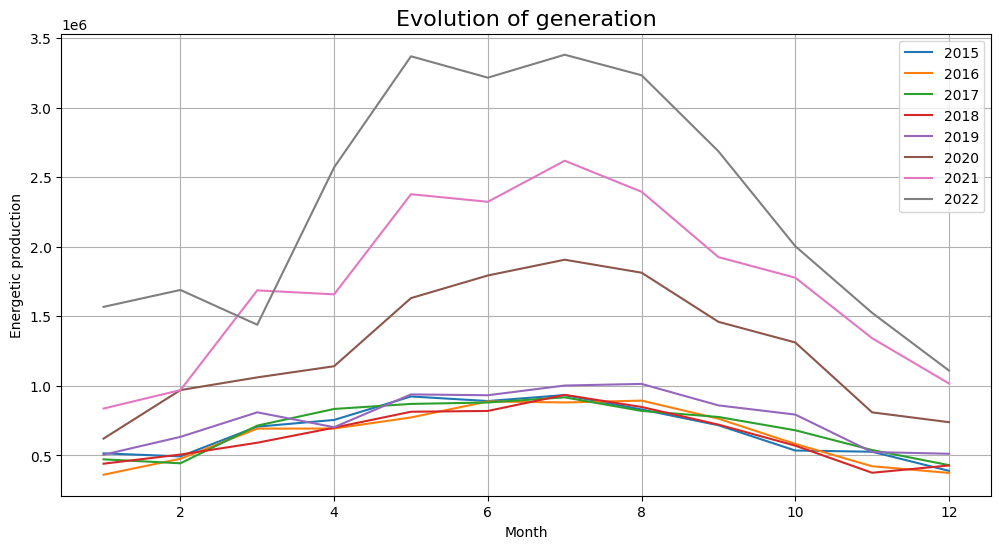

In [ ]:
plot_generation_evolution(df_solarfotovoltaica)

It is a good way to see how the evolution of the generation perform during the year and its specially high during the summer months.
The plot helps also to see how this energy has grown these last years.

In [ ]:
def plot_cca_by_year(dataframe):

    df_plot = dataframe.copy()

    fig, axs = plt.subplots(1,2, figsize = (20,8))

    df_plot['year'] = df_plot['fecha'].dt.year
    df_plot['month'] = df_plot['fecha'].dt.month
    sum_values = df_plot.groupby(['year','comunidad_autonoma'])['generation'].sum() \
                            .reset_index()
    
    
    sns.swarmplot( data = sum_values, x = 'year', y = 'generation', hue= 'comunidad_autonoma',ax = axs[0])
    axs[0].set_title('Generation by CCAA')
    axs[0].set_ylabel('generation MWh')

    sum_values = sum_values.replace({'CASTILLA Y LEON':'CYLE'}) #n order to avoid mixing it with the other 'Castilla' in the next step.
    sum_values['com_short'] = sum_values['comunidad_autonoma'].str[:4]
    sns.barplot( data = sum_values, x = 'com_short', y = 'generation', hue= 'year', ax = axs[1])
    axs[1].set_title('Generation by CCAA')
    axs[1].set_ylabel('generation MWh')

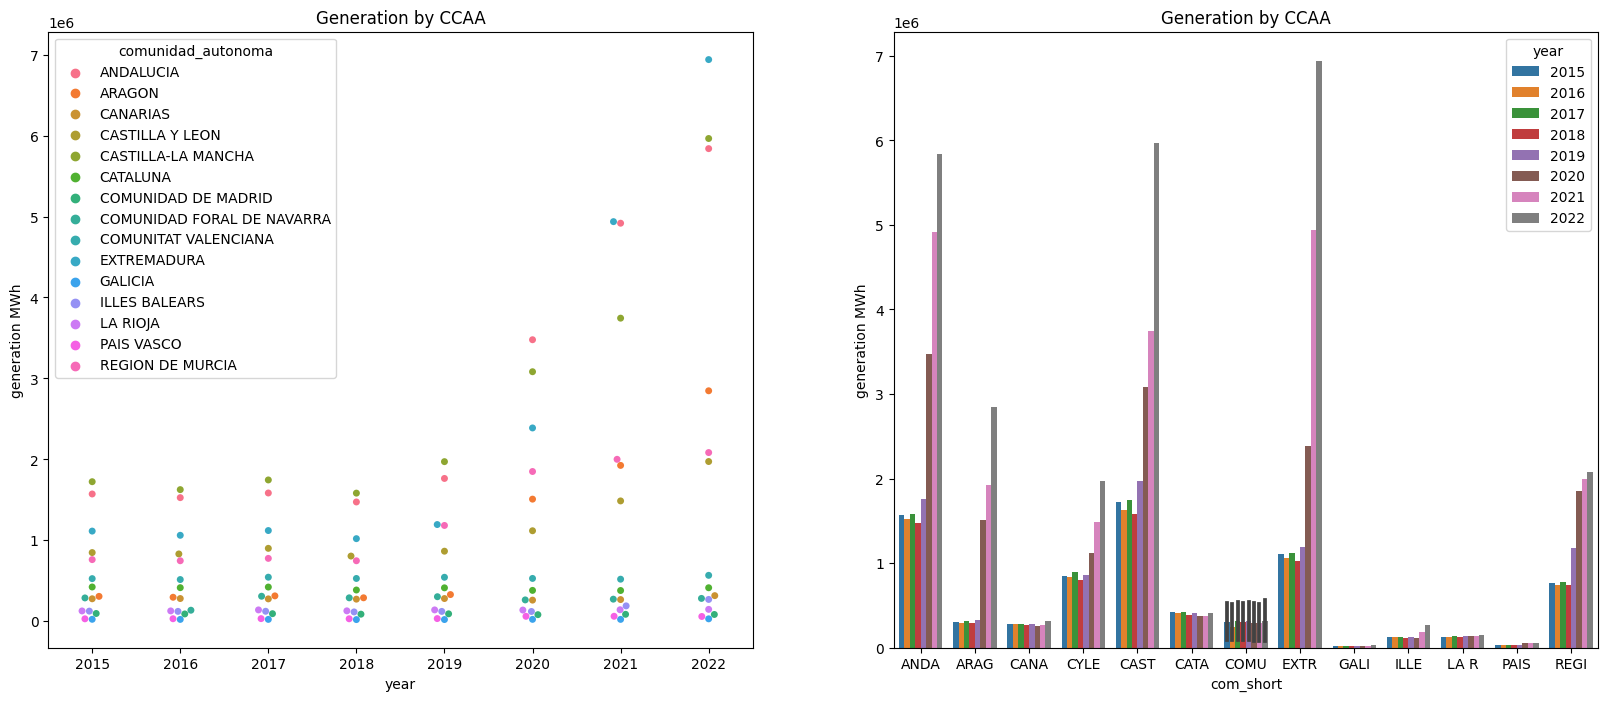

In [ ]:
plot_cca_by_year(df_solarfotovoltaica)

It is already possible to see which are the main CCAAs in terms of production: Andalucia, Castilla-lA Mancha and Extremadura ae the leaders, but Aragon is growing so fast also.

In [6]:
def read_gpd_file(url):
    file_id = url.split('/')[-2]
    url_total = 'https://drive.google.com/uc?export=download&id=' + file_id
    
    for retry in range(3):
        try:
            r = requests.get(url_total)
            r.raise_for_status() 
            
            if r.status_code == 200:
                
                temp_dir = tempfile.mkdtemp()
                with open(f"{temp_dir}/file.zip", "wb") as f:
                    f.write(r.content)
                with zipfile.ZipFile(f"{temp_dir}/file.zip", 'r') as zip_ref:
                    zip_ref.extractall(temp_dir)
                shapefile = [f for f in os.listdir(temp_dir) if f.endswith('.shp')][0]
                map_file = gpd.read_file(f"{temp_dir}/{shapefile}")
                shutil.rmtree(temp_dir)
                return map_file
            else:
                print("Server error. Trying again...")
                time.sleep(5.0)  # Wait for another retry
        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry
    
    
    print("Unable to download, server not working. Please try again later.")
    return None

In [7]:
spain= read_gpd_file(url_map)

In [8]:
spain

GID_1 GID_0 COUNTRY                      NAME_1  \
0    ESP.1_1   ESP   Spain                   Andalucía   
1    ESP.2_1   ESP   Spain                      Aragón   
2    ESP.3_1   ESP   Spain                   Cantabria   
3    ESP.4_1   ESP   Spain          Castilla-La Mancha   
4    ESP.5_1   ESP   Spain             Castilla y León   
5    ESP.6_1   ESP   Spain                    Cataluña   
6    ESP.7_1   ESP   Spain             Ceuta y Melilla   
7    ESP.8_1   ESP   Spain         Comunidad de Madrid   
8    ESP.9_1   ESP   Spain  Comunidad Foral de Navarra   
9   ESP.10_1   ESP   Spain        Comunidad Valenciana   
10  ESP.11_1   ESP   Spain                 Extremadura   
11  ESP.12_1   ESP   Spain                     Galicia   
12  ESP.13_1   ESP   Spain              Islas Baleares   
13  ESP.14_1   ESP   Spain              Islas Canarias   
14  ESP.15_1   ESP   Spain                    La Rioja   
15  ESP.16_1   ESP   Spain                  País Vasco   
16  ESP.17_1   ESP   Spain      Principado de Asturias   
17  ESP.18_1   ESP   Spain            Región de Murcia   

                           VARNAME_1 NL_NAME_1              TYPE_1  \
0   Andalousie|Andaluc¡a|Andalusien|        NA  Comunidad Autónoma   
1   Aragão|Aragó|Aragón|Aragona|Arag        NA  Comunidad Autónoma   
2   Cantàbria|Cantábria|Cantabrie|Ka        NA  Comunidad Autónoma   
3   Castela-La Mancha|Castela-Mancha        NA  Comunidad Autónoma   
4   Castile and Leon|Castela e Leão|        NA  Comunidad Autónoma   
5   Catalogna|Catalogne|Catalonia|Ca        NA  Comunidad Autónoma   
6                                 NA        NA     Ciudad Autónoma   
7   Madrid|Communauté de Madrid| Com        NA  Comunidad Autónoma   
8   Communauté forale de Navarre|Com        NA  Comunidad Autónoma   
9   Valencia|Communauté de Valence|C        NA  Comunidad Autónoma   
10           Estremadura|Estrémadure        NA  Comunidad Autónoma   
11  Galice|Gal¡cia|Galicien|Galiza|G        NA  Comunidad Autónoma   
12  Balearic Islands|Balearen|Balear        NA  Comunidad Autónoma   
13  Canarias|Canary Islands|Canárias        NA  Comunidad Autónoma   
14                             Rioja        NA  Comunidad Autónoma   
15  Basque Country|Baskenland|Basque        NA  Comunidad Autónoma   
16  Astúrias|Asturie|Asturien|Asturi        NA  Comunidad Autónoma   
17  Murcia|Região de Múrcia|Regió de        NA  Comunidad Autónoma   

               ENGTYPE_1 CC_1 HASC_1  ISO_1  \
0   Autonomous Community   01  ES.AN     NA   
1   Autonomous Community   15  ES.AR     NA   
2   Autonomous Community   06  ES.CB  ES-CB   
3   Autonomous Community   08  ES.CM  ES-CM   
4   Autonomous Community   07  ES.CL     NA   
5   Autonomous Community   09  ES.CT     NA   
6        Autonomous City   19  ES.ML     NA   
7   Autonomous Community   NA  ES.MD     NA   
8   Autonomous Community   15  ES.NA     NA   
9   Autonomous Community   10  ES.VC     NA   
10  Autonomous Community   11  ES.EX  ES-EX   
11  Autonomous Community   12  ES.GA  ES-GA   
12  Autonomous Community   04  ES.PM     NA   
13  Autonomous Community   05  ES.CN     NA   
14  Autonomous Community   17  ES.LO  ES-RI   
15  Autonomous Community   16  ES.PV     NA   
16  Autonomous Community   03  ES.AS     NA   
17  Autonomous Community   14  ES.MU     NA   

                                             geometry  
0   MULTIPOLYGON (((-3.03125 35.94069, -3.03125 35...  
1   POLYGON ((-0.81690 39.89858, -0.81272 39.89801...  
2   MULTIPOLYGON (((-3.93629 42.90813, -3.93672 42...  
3   MULTIPOLYGON (((-1.45231 38.58182, -1.46655 38...  
4   MULTIPOLYGON (((-5.62101 40.24145, -5.62189 40...  
5   MULTIPOLYGON (((0.43801 40.54708, 0.43587 40.5...  
6   MULTIPOLYGON (((-2.44014 35.18292, -2.43958 35...  
7   MULTIPOLYGON (((-3.87292 39.90904, -3.87628 39...  
8   POLYGON ((-1.61091 41.94654, -1.61681 41.95151...  
9   MULTIPOLYGON (((-0.75236 37.88653, -0.75236 37...  
10  POLYGON ((-6.06385 37.98960, -6.06518 37.98847...  
11  MUL

In [ ]:
def create_spain_map(spain_file):
    #To access to the geo data we are using geopandas library, which transforms data into readable dataframes:
    spain_file = spain_file.rename(columns = {'NAME_1': 'comunidad_autonoma', 'CC_1':'CODAUTO'})
    spain_file['comunidad_autonoma'] = (spain_file['comunidad_autonoma'].apply(unidecode, 'utf-8')).str.upper()
    spain_file['comunidad_autonoma'] = spain_file['comunidad_autonoma'].replace({'CEUTA Y MELILLA':'MELILLA',
                                                                    'COMUNIDAD VALENCIANA': 'COMUNITAT VALENCIANA',
                                                                    'ISLAS BALEARES': 'ILLES BALEARS',
                                                                    'ISLAS CANARIAS': 'CANARIAS'})
    
    #We don't need all the information from the file:

    spain_file = spain_file[['comunidad_autonoma', 'geometry']]

    return spain_file

In [ ]:
spain = create_spain_map(spain)

In [ ]:
#The result is a dataframe with several columns, specially importants two of them: 'comunidad_autonoma' & 'geometry'
spain.head()

comunidad_autonoma                                           geometry
0           ANDALUCIA  MULTIPOLYGON (((-3.03125 35.94069, -3.03125 35...
1              ARAGON  POLYGON ((-0.81690 39.89858, -0.81272 39.89801...
2           CANTABRIA  MULTIPOLYGON (((-3.93629 42.90813, -3.93672 42...
3  CASTILLA-LA MANCHA  MULTIPOLYGON (((-1.45231 38.58182, -1.46655 38...
4     CASTILLA Y LEON  MULTIPOLYGON (((-5.62101 40.24145, -5.62189 40...

In [ ]:
spain.info(9)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   comunidad_autonoma  18 non-null     object  
 1   geometry            18 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 416.0+ bytes


<Axes: >

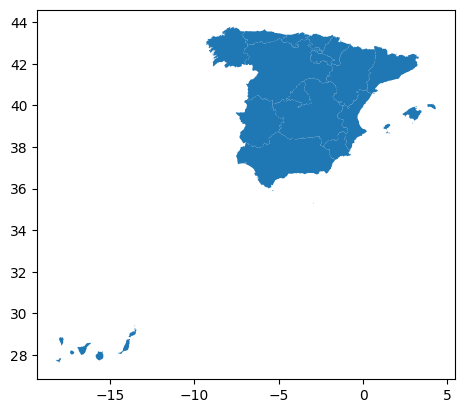

In [ ]:
#It will be useful for easily create a map of Spain. The only problem is that Canariasis going to appear so far and therefore the map wil  be smaller than we want. We are 'canarias' coordinates in order to solve it:
spain.plot()

In [ ]:
def translate_canarias(spain_file):
    
    # Apply translate to 'geometry' column based on condition
    spain['geometry'] = spain.apply(
    lambda row: translate(row['geometry'], xoff=3, yoff=6) if row['comunidad_autonoma'] == 'CANARIAS' else row['geometry'],
    axis=1
    )

    return spain_file


In [ ]:
spain = translate_canarias(spain)

/home/dsc/anaconda3/envs/EFAT_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/dsc/anaconda3/envs/EFAT_env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/dsc/anaconda3/envs/EFAT_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1594: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

<Axes: >

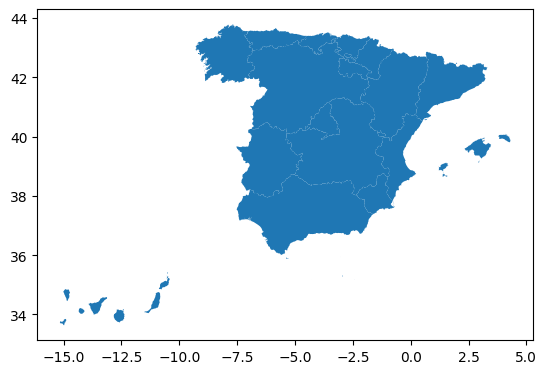

In [ ]:
#Let's quickly check:
spain.plot()

In [ ]:
def plot_map_generation(map_file, dataframe, year):

    dataframe = dataframe[dataframe['fecha'].dt.year == year]
    dataframe = dataframe.groupby('comunidad_autonoma')['generation'].sum()
    spain = pd.merge(map_file, dataframe, on='comunidad_autonoma', how='left').fillna(0)

    #Transform generation into GWh:

    spain['generation'] = spain['generation']/1000

    # Plot:
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot the boundaries between comunidades autónomas
    spain['geometry'].boundary.plot(ax=ax, linewidth=0.5, color='black')

    # Use ax parameter for both plots
    spain.plot(column='generation', legend=True, ax=ax, cmap = 'Blues')
    
    # Adjust the map limits
    ax.set_xlim(-16, 5) 
    ax.set_ylim(33, 45)

    plt.title(f'Generation of by CCAA in GWh, {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


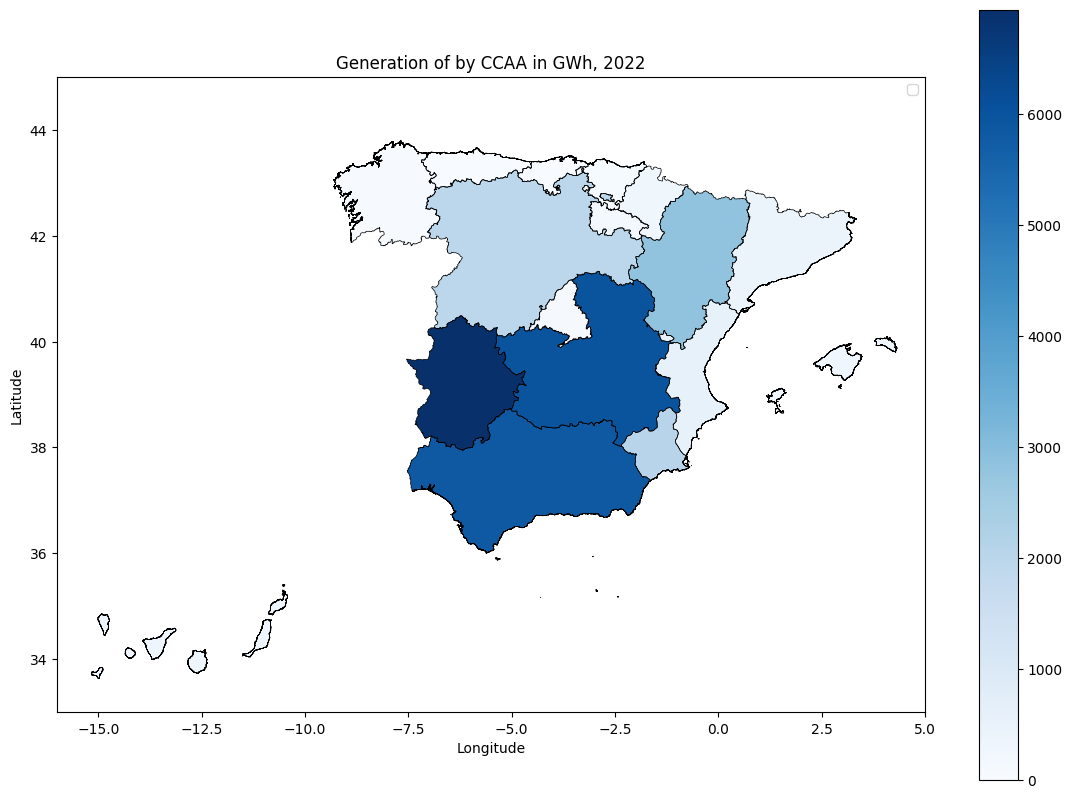

In [ ]:
plot_map_generation(spain, df_solarfotovoltaica, 2022)

It is always easier to visualize data on a map. The conclusion would be that tis technology is specially productive in the south of Spain - which obviously makes sense. We are creating now a plot to see the same map but with the other variables also to see if they are correlated.

In [ ]:
def plot_map_generation_withvariables(map_file, dataframe, year):

    cols_to_plot = [column for column in dataframe.columns if dataframe[column].dtype == 'float64']

    dataframe = dataframe[dataframe['fecha'].dt.year == year]
    dataframe = dataframe.groupby('comunidad_autonoma').mean()

    # Plot:
    nrows = (1 if 0 < len(cols_to_plot) < 3
             else 2 if 2 < len(cols_to_plot) < 5
             else 3)
    ncols = 2
    r = 0
    c = 0
    #Plots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))

    for i, column in enumerate(cols_to_plot):
            
        df = dataframe.groupby('comunidad_autonoma')[column].mean()
        df = pd.merge(map_file, df, on='comunidad_autonoma', how='left').fillna(0)
        

        # Plot the boundaries between comunidades autónomas
        df['geometry'].boundary.plot(ax=ax[i // ncols, i % ncols], linewidth=0.5, color='black')

        # Use ax parameter for both plots
        df.plot(column=column, legend=True, ax=ax[i // ncols, i % ncols], cmap='Blues')
            
        # Adjust the map limits
        ax[i // ncols, i % ncols].set_xlim(-16, 5) 
        ax[i // ncols, i % ncols].set_ylim(33, 45)

        ax[i // ncols, i % ncols].set_title(f'{column} by CCAA in {year}')
        ax[i // ncols, i % ncols].set_xlabel('Longitude')
        ax[i // ncols, i % ncols].set_ylabel('Latitude')
  
    if len(cols_to_plot) % 2 != 0:
        plt.delaxes(ax[nrows-1, ncols-1])
    plt.tight_layout()
    plt.show()


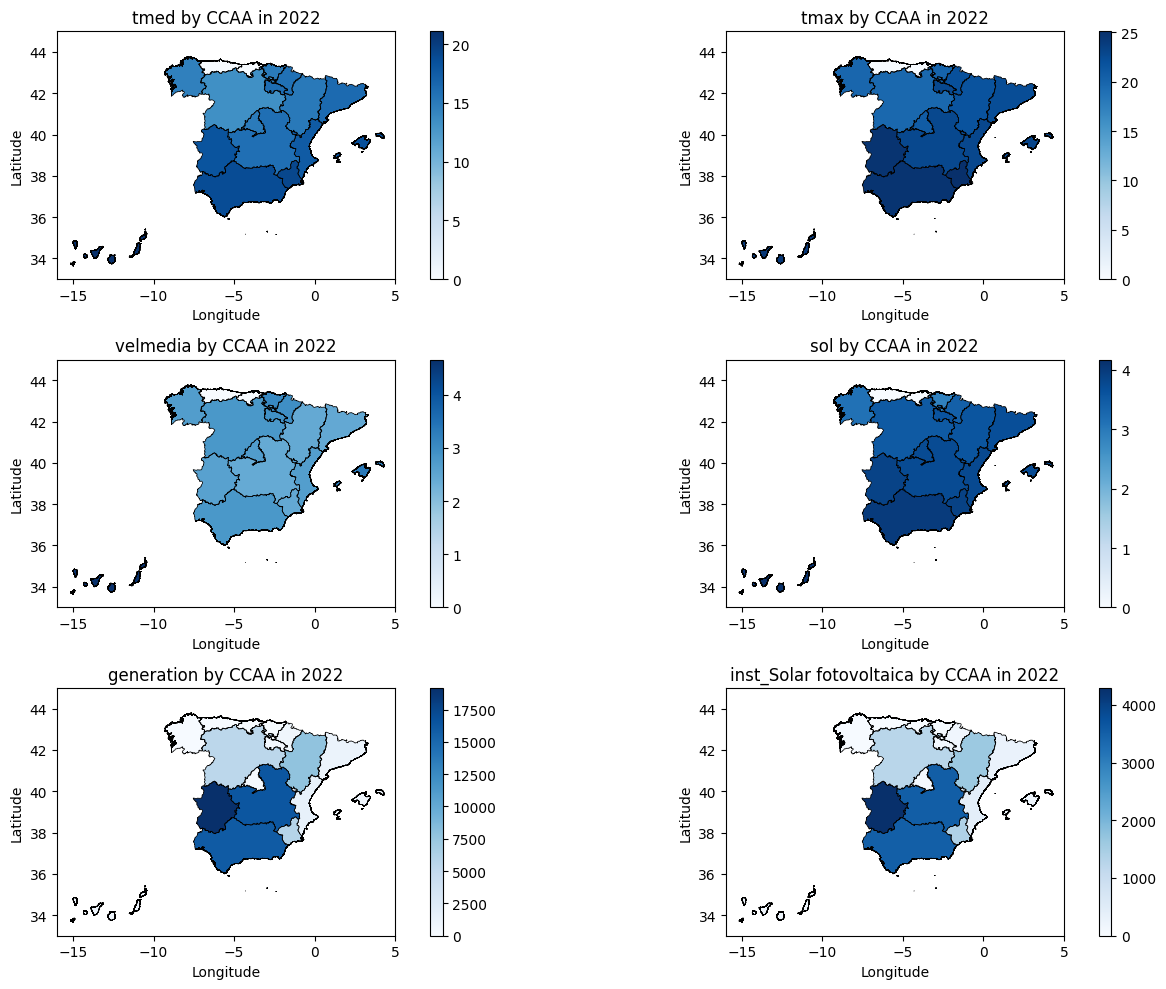

In [ ]:
plot_map_generation_withvariables(spain,df_solarfotovoltaica, 2022)

The plots seem to confirm at first sight the hypothesis we had: 'temperature' and 'sol' are variables highly correlated with photovoltaic solar generation. We will maintain also 'velmedoa' for the study as it seems to make sense also.

#### 1.6.2 Solar Térmica

'Solar térmica' has a smaller generation in Spain and the CCAA with production are fewer also. However, it's probably worthy to analyze it spearatrely from 'solar fotovoltaica' as the technolgy is different and therefore the variables affecting to the generation can vary or affect in a different manner in this case. \
We are inclusing here the same plots we have used for 'solar fotovoltaica'.

First of all, the correllation plots in order to confirm if the variables selected actually have an impact on generation:

In [ ]:
df_solartermica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17532 entries, 0 to 52594
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               17532 non-null  datetime64[ns]
 1   comunidad_autonoma  17532 non-null  object        
 2   tmed                17532 non-null  float64       
 3   tmax                17532 non-null  float64       
 4   velmedia            17532 non-null  float64       
 5   sol                 17488 non-null  float64       
 6   generation          17532 non-null  float64       
 7   inst_Solar_térmica  17532 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.2+ MB


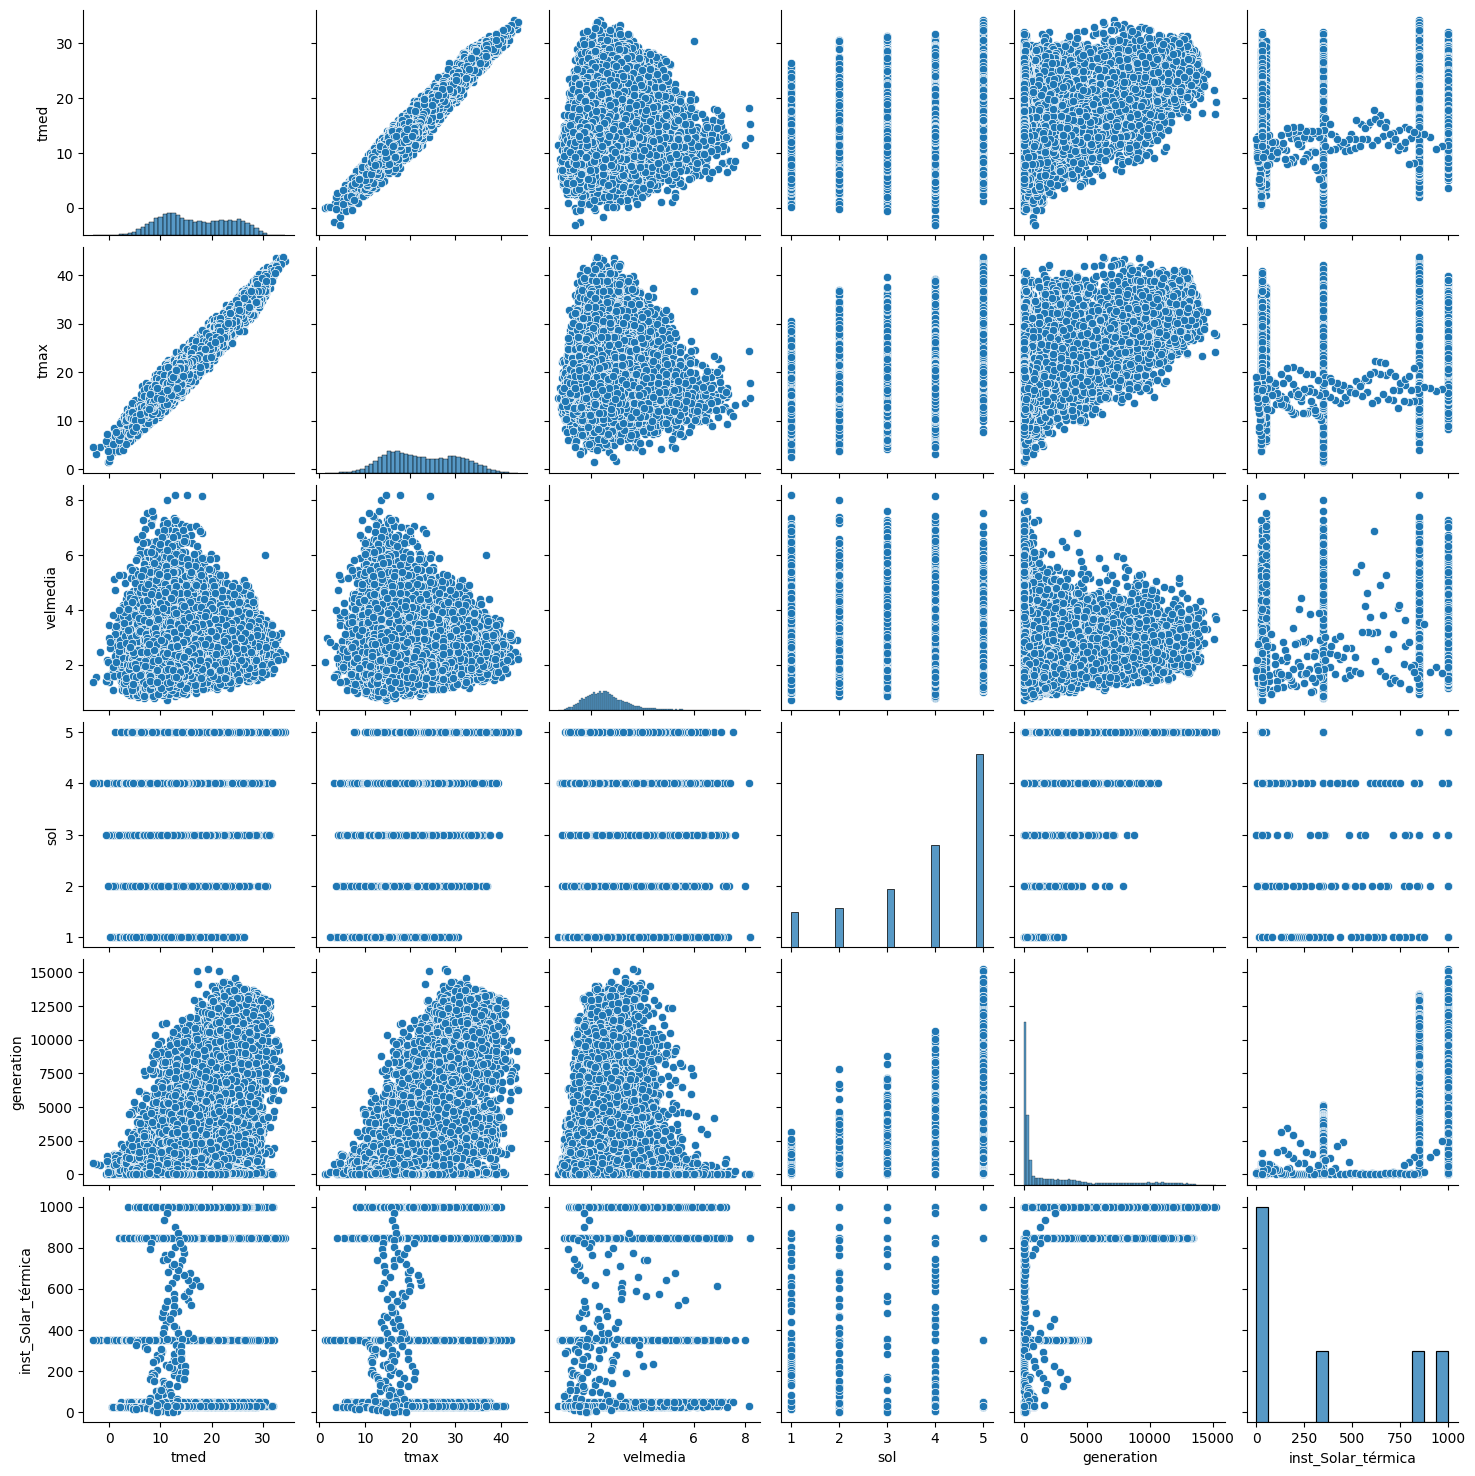

In [ ]:
plot_correlation(df_solartermica)

Velmedia is not really interesting here, it's probably worth it to drop it. For modelling purposes, it will ve also meaningfull just to have one temperature variable, 'tmed' as a reference. Otherwise those variables were going to affect the model as they are highly correlated (multicollinearity) 'Sol', as in the case of 'solar fotovoltaica' has a direct correlation also. Let's confirm this with the correlattion heatmap:

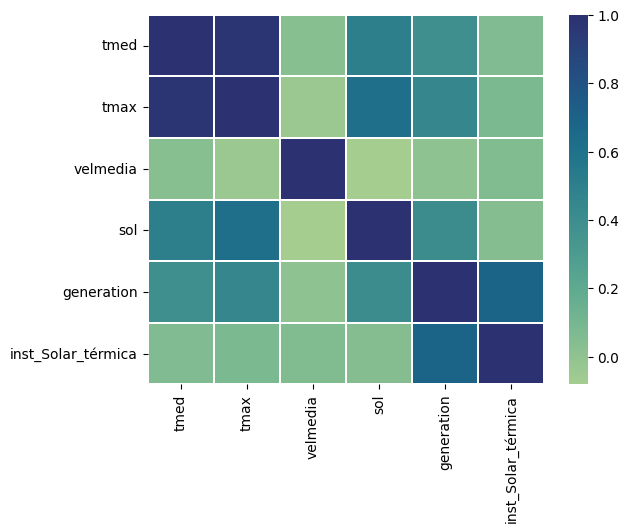

In [ ]:
plot_heatmap(df_solartermica)

It confirms that there are some variables that we can directly eliminate prior to the modelling:

In [ ]:
def transform_df_solartermica(solartermica_df):
    solartermica_df = solartermica_df.drop(columns = ['velmedia', 'tmax'], axis = 1)
    return solartermica_df


In [ ]:
df_solartermica = transform_df_solartermica(df_solartermica)

In [ ]:
df_solartermica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17532 entries, 0 to 52594
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               17532 non-null  datetime64[ns]
 1   comunidad_autonoma  17532 non-null  object        
 2   tmed                17532 non-null  float64       
 3   sol                 17488 non-null  float64       
 4   generation          17532 non-null  float64       
 5   inst_Solar_térmica  17532 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 958.8+ KB


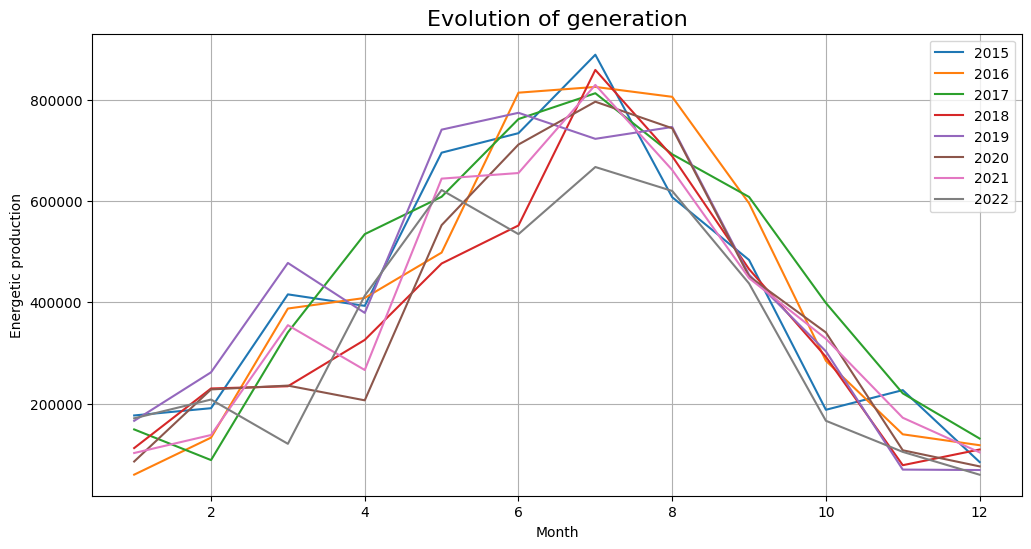

In [ ]:
#Let's see the evolution over the years and over a year:
plot_generation_evolution(df_solartermica)

It seems that the generation with 'solartermica' technology was speiclly low in the last year and that it's highly related to the heatest months of the year.

Let's plot now the other plots with geographical - or administrative -  information. The aim is to study or to easily see which CCAA are the ones that are generating more 'Solartermica' energy. \
Let's check how the productionby CCAA was last year:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


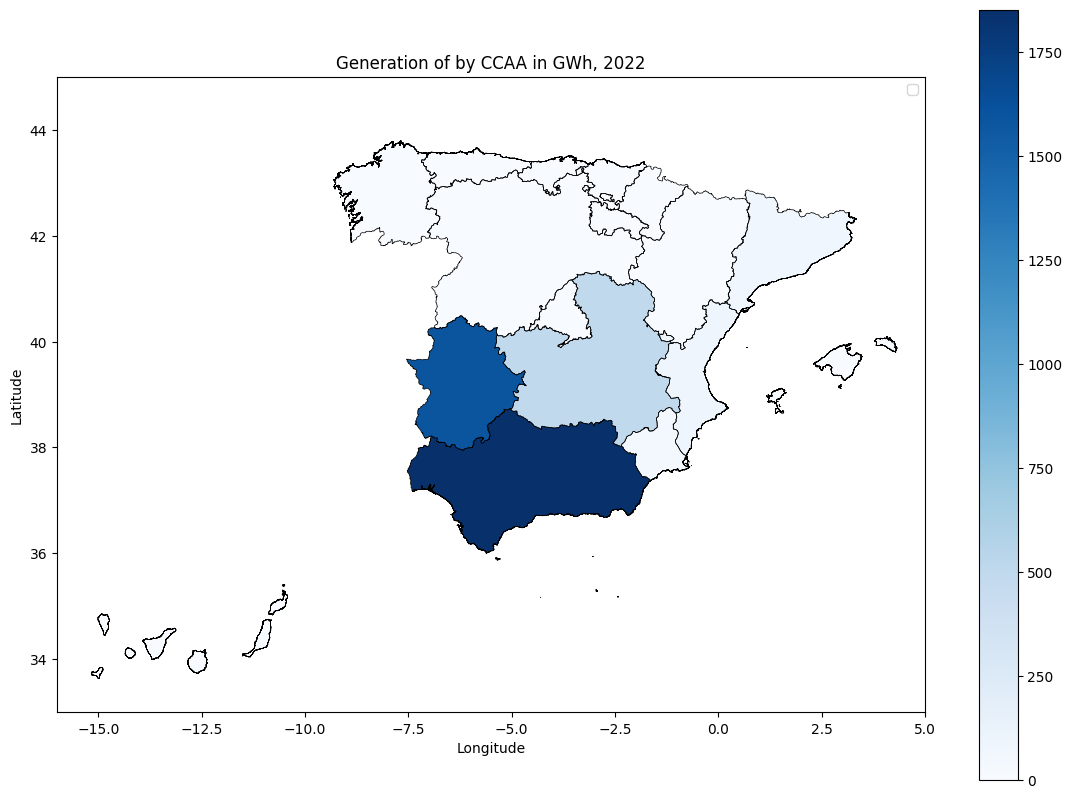

In [ ]:
plot_map_generation(spain, df_solartermica, 2022)

Time now to see the geographical information for the other variabes of teh dataframe to see the correlation also geographically:

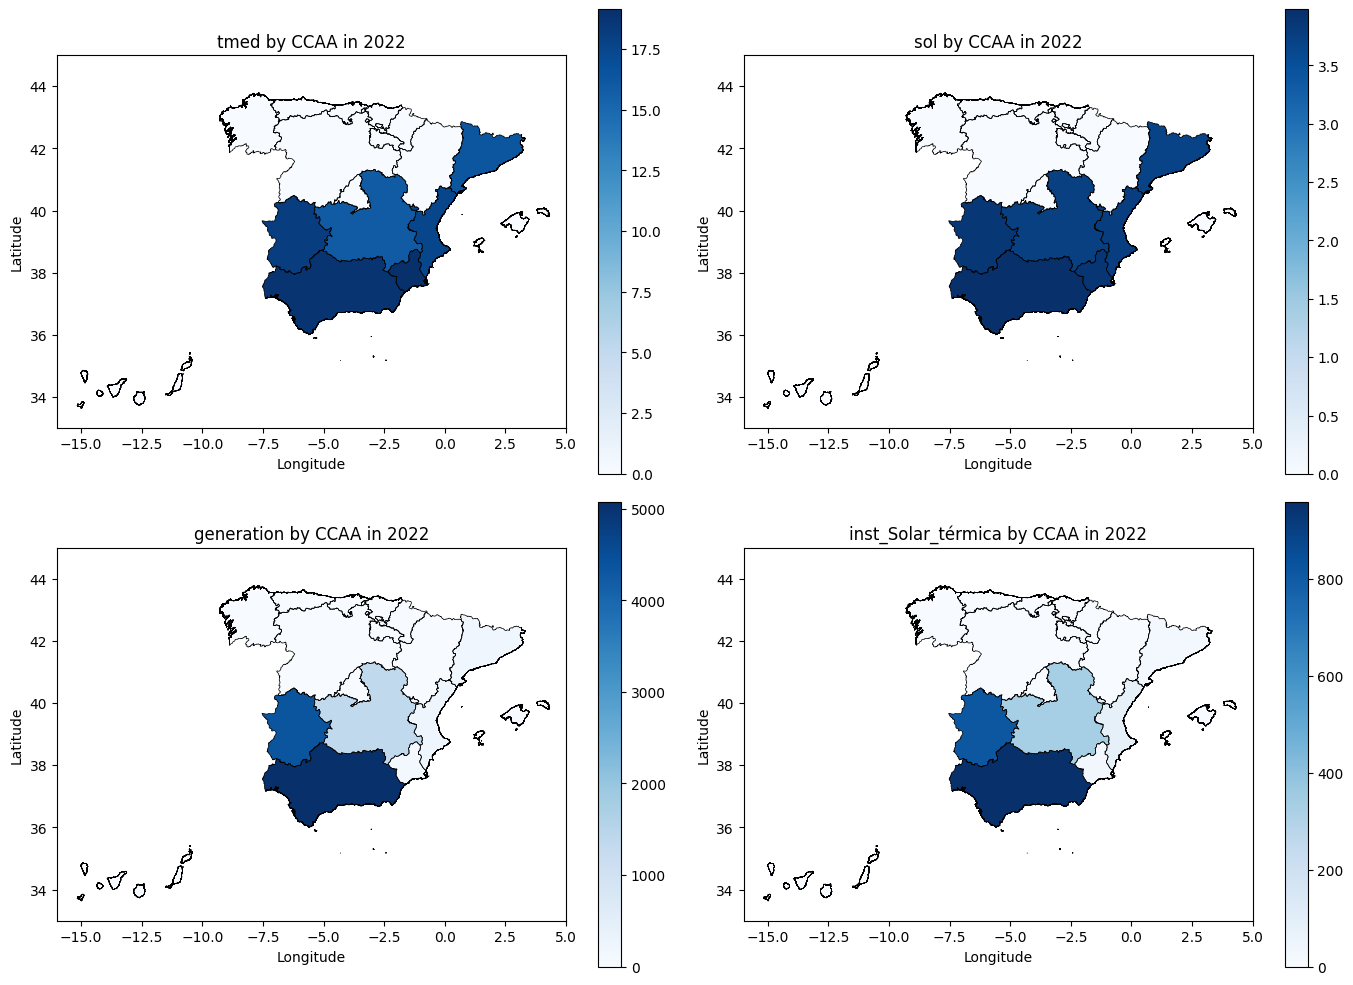

In [ ]:
plot_map_generation_withvariables(spain, df_solartermica, 2022)

'sol' and 'tmed' seem to be highly related witg 'generation. Probably because a lack of investment in other CCAAs the production is not that high as in Extremadura or Andalucia, as we see that there are also oher CCAAs that seem to be a good opportunity for 'solar termica' production.

#### 1.6.3 Eólica

For Eolic genetation we are considering variables related to the wind, but we are incling also variables related to prec, or temperature. These other variables can have muticolinearity, but there can be also responsible for eolic generation, as wind levels depend also of the changes in the temperature between areas, as it is explainded in the following article:https://www.windlogger.com/blogs/news/how-does-cold-weather-affect-wind-speed,  'Winds tend to be stronger during winter, and this can be explained with the uneven heating of the Earth’s surface'. Let's see if we can confirm this hypothesis analyzing the data we have extracted from AEMET.  \
First of all, let's check again the correlation between the variables inluded:

In [ ]:
df_eolica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43829 entries, 0 to 52594
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               43829 non-null  datetime64[ns]
 1   comunidad_autonoma  43829 non-null  object        
 2   tmed                43829 non-null  float64       
 3   prec                43829 non-null  float64       
 4   velmedia            43829 non-null  float64       
 5   racha               43829 non-null  float64       
 6   generation          43829 non-null  float64       
 7   inst_Eólica         43829 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 3.0+ MB


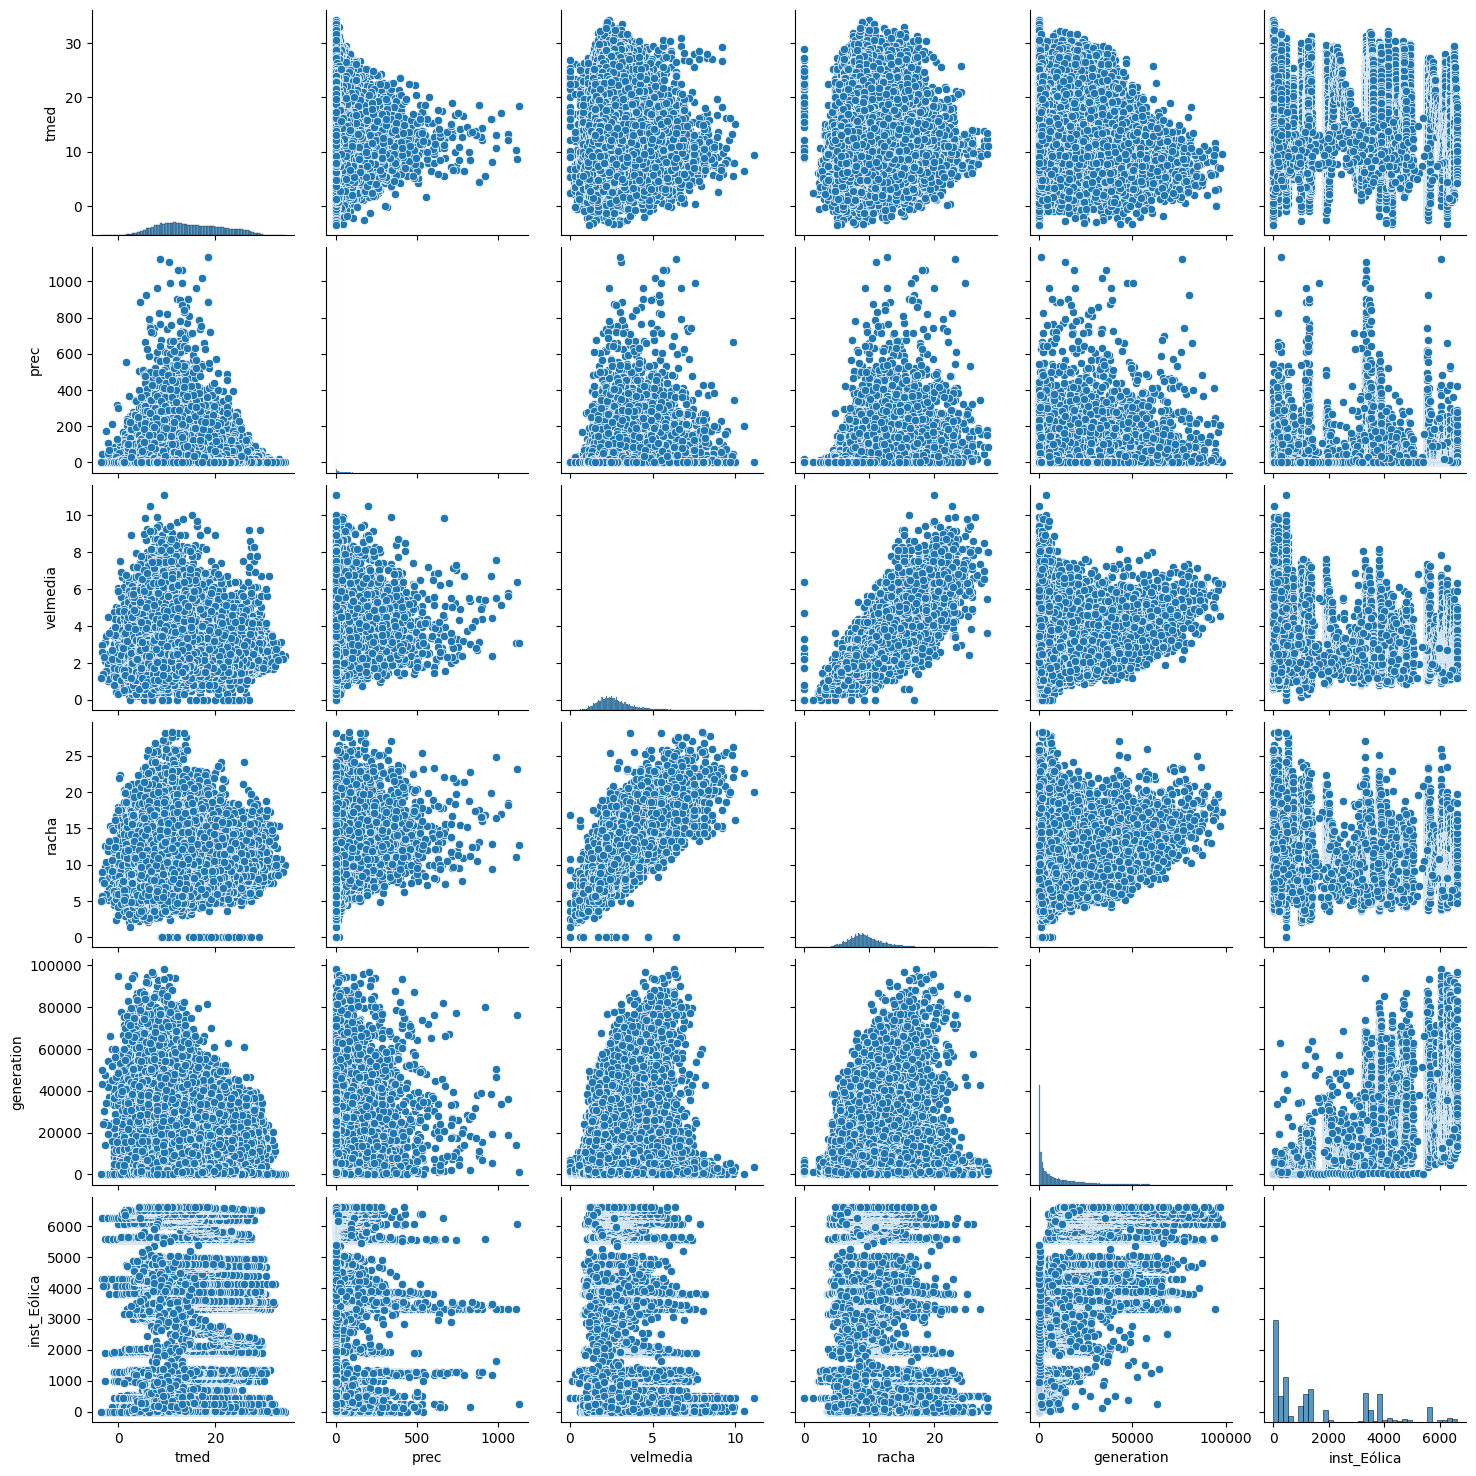

In [ ]:
plot_correlation(df_eolica)

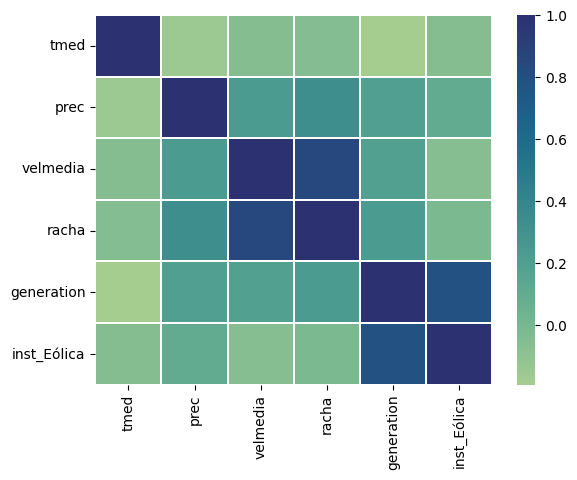

In [ ]:
#Let's see now the heatmap:
plot_heatmap(df_eolica)

It seems that most of the variables are highy related in the remain dataframe. Let's see the evolution over the years and over a single year:

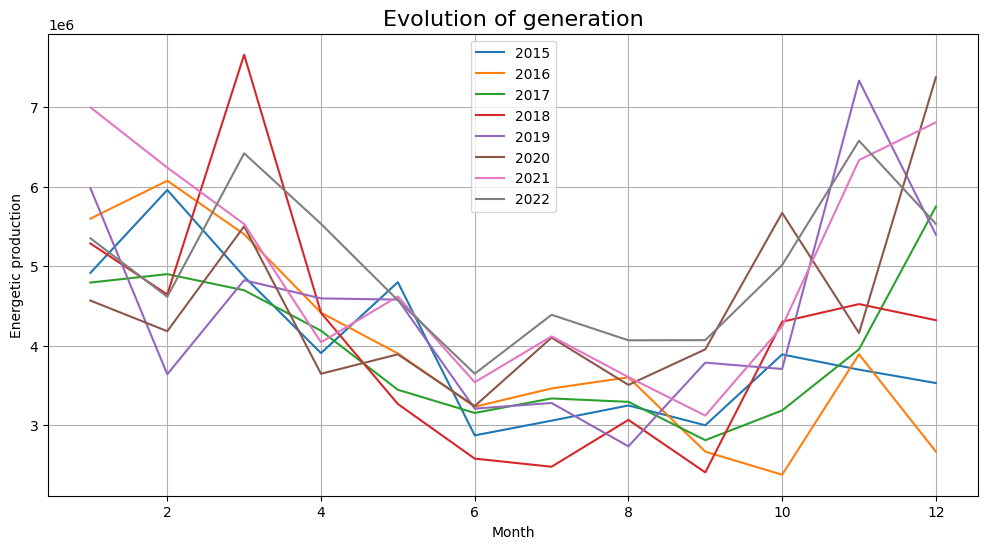

In [ ]:
plot_generation_evolution(df_eolica)

Generation is increasing over the last years due to a higher investment in this technology which is increasing it's capacity (4,9% in comparison with 2021, information provided by Re: https://www.sistemaelectrico-ree.es/informe-de-energias-renovables/viento/potencia-instalada-viento#:~:text=La%20e%C3%B3lica%20representa%20la%20principal,en%20todo%20el%20territorio%20espa%C3%B1ol.) \
Over a year it seems tohave the opposite relation to the 'solar ones': it is specially high during winter.
Let's see the produciton now with the geographical info in the last year:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


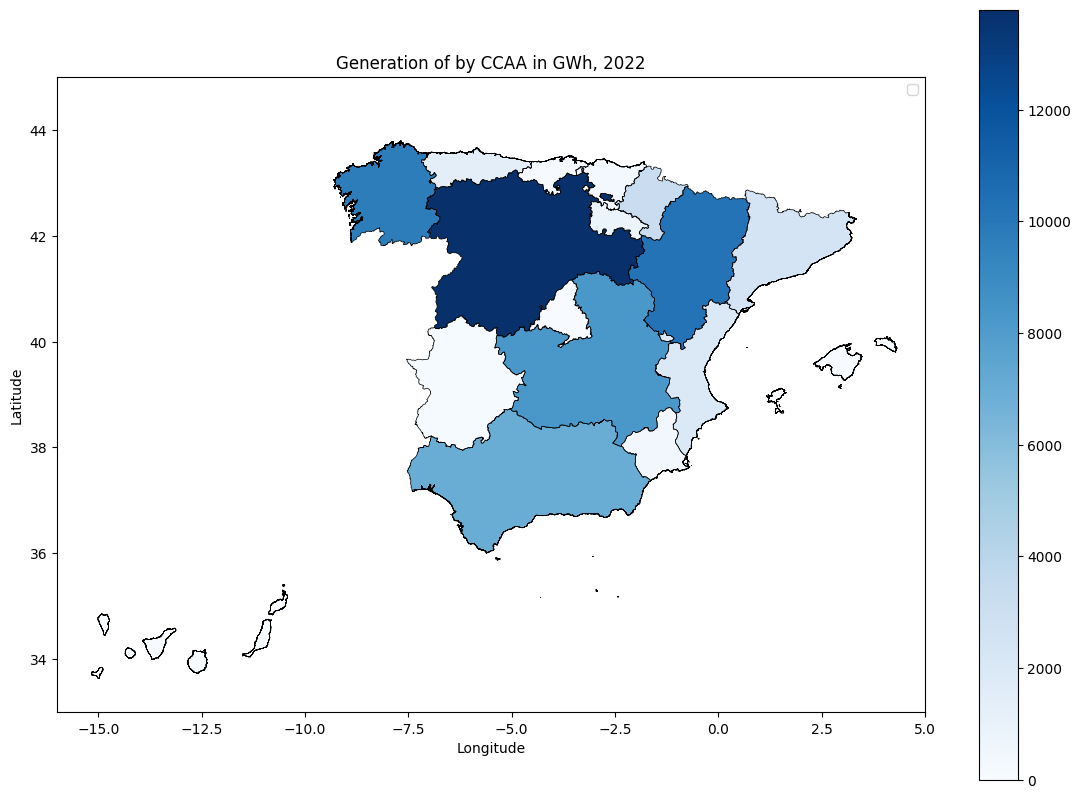

In [ ]:
plot_map_generation(spain,df_eolica,2022)

The provinces with the highest levels of production in 2022 were Galicia, Aragon and specially Castilla y León. Let's see now if it is related also geographically with the other variables:


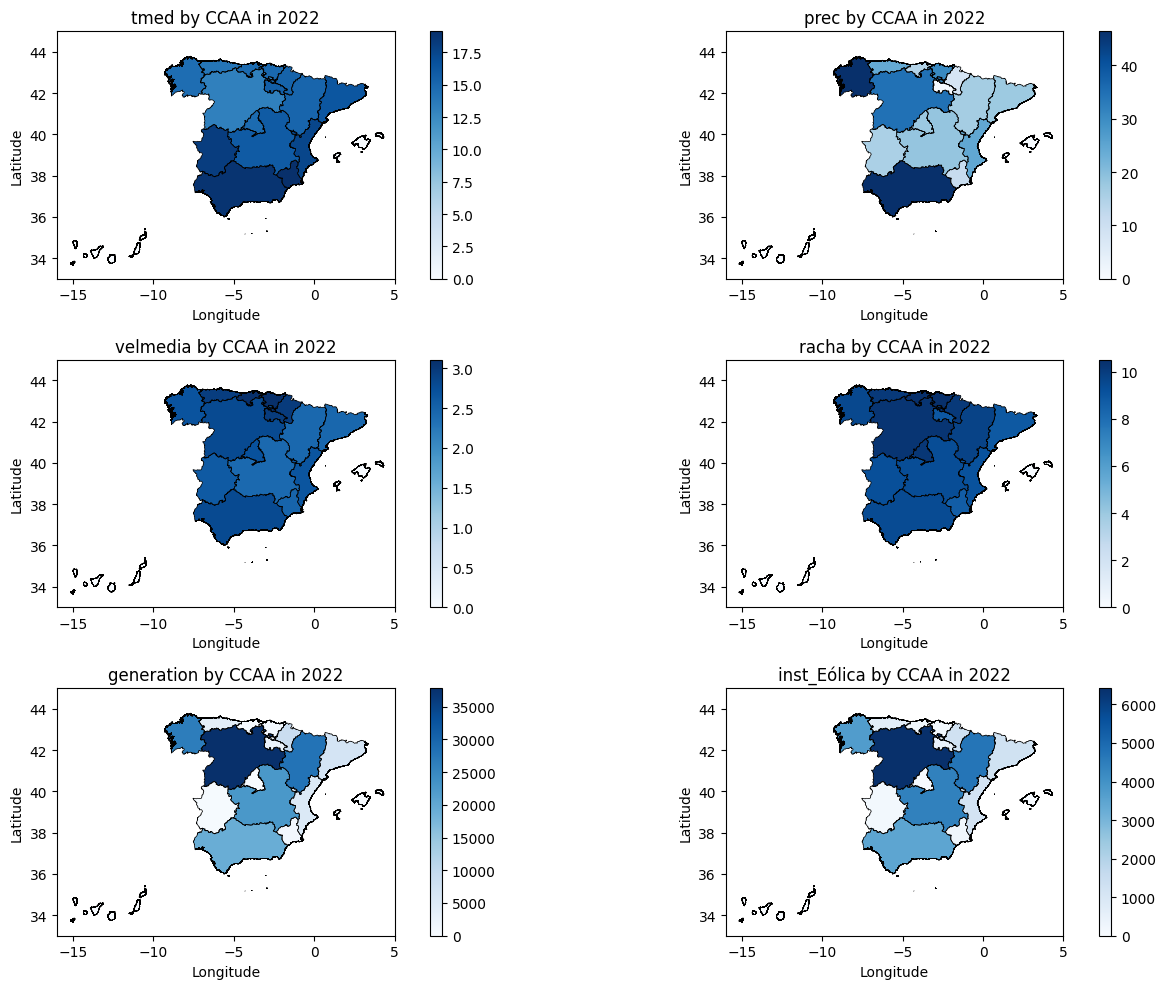

In [ ]:
plot_map_generation_withvariables(spain, df_eolica, 2022)

It seens that specially 'racha', which isthe highest speed of the day, could be really related to 'generation'. However, when doing the mean in trhe gorupbys we have probably lost some accuracy.

#### 1.6.4 Hidráulica

For hidraulica, we are including several weather variables, but it will always depend on the main variable that resume all the others: the level of water in the damd (AGUA_ACTUAL) as the generation will depend on goverment or energetic-companies decissions based on the 'hudraulic-stress' of an area or territory.

In [ ]:
df_hidraulica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43829 entries, 0 to 52594
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               43829 non-null  datetime64[ns]
 1   comunidad_autonoma  43829 non-null  object        
 2   tmed                43829 non-null  float64       
 3   prec                43829 non-null  float64       
 4   AGUA_ACTUAL         43829 non-null  float64       
 5   AGUA_TOTAL          43829 non-null  float64       
 6   generation          43829 non-null  float64       
 7   inst_Hidráulica     43829 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 3.0+ MB


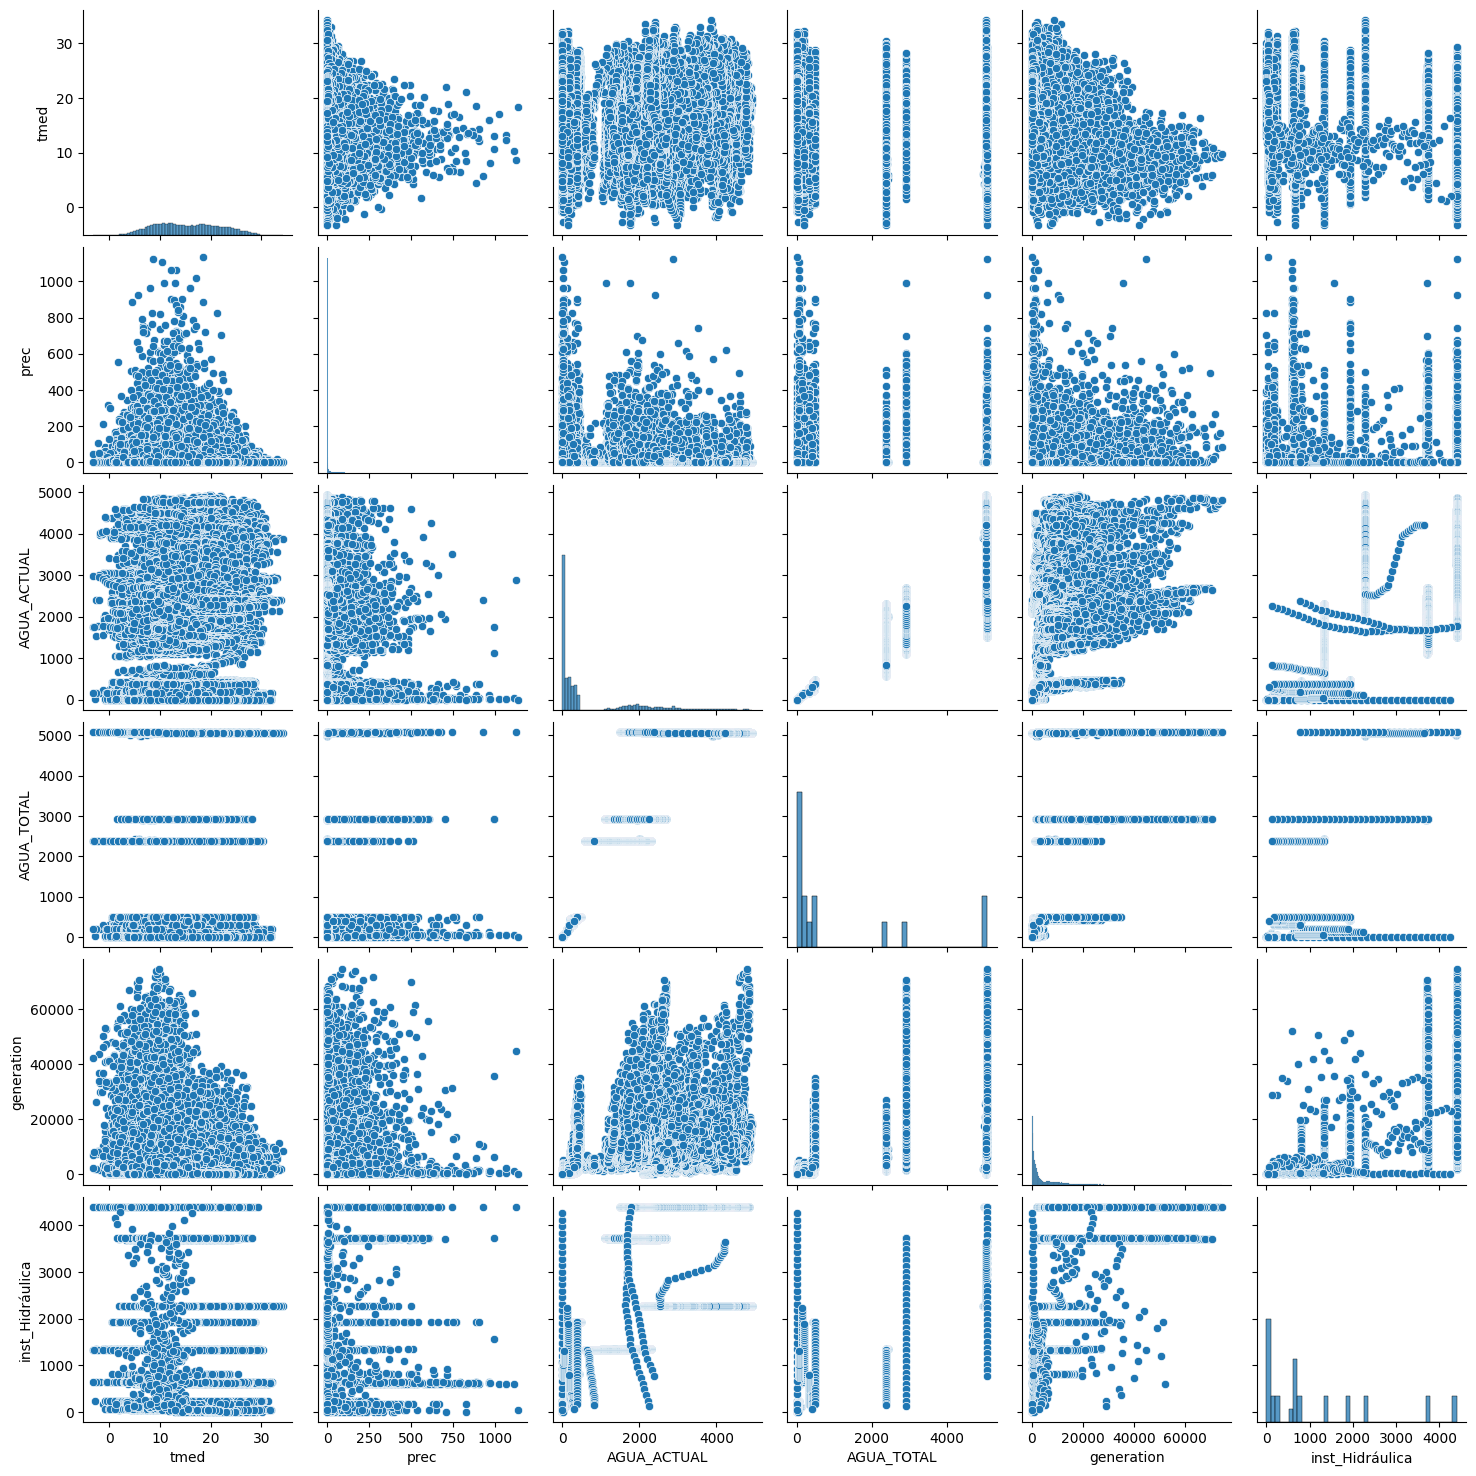

In [ ]:
plot_correlation(df_hidraulica)

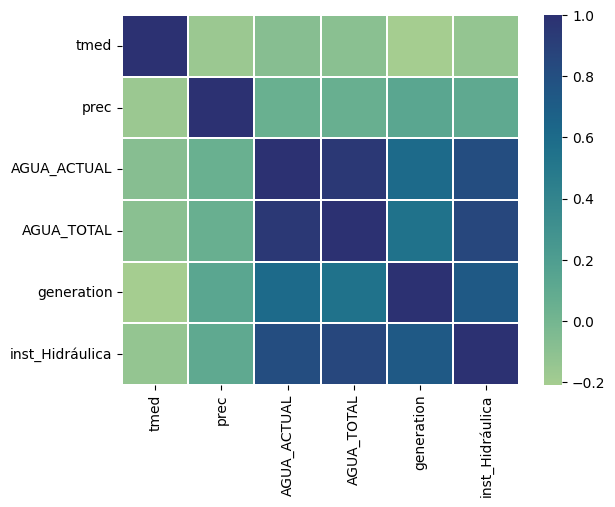

In [ ]:
plot_heatmap(df_hidraulica)

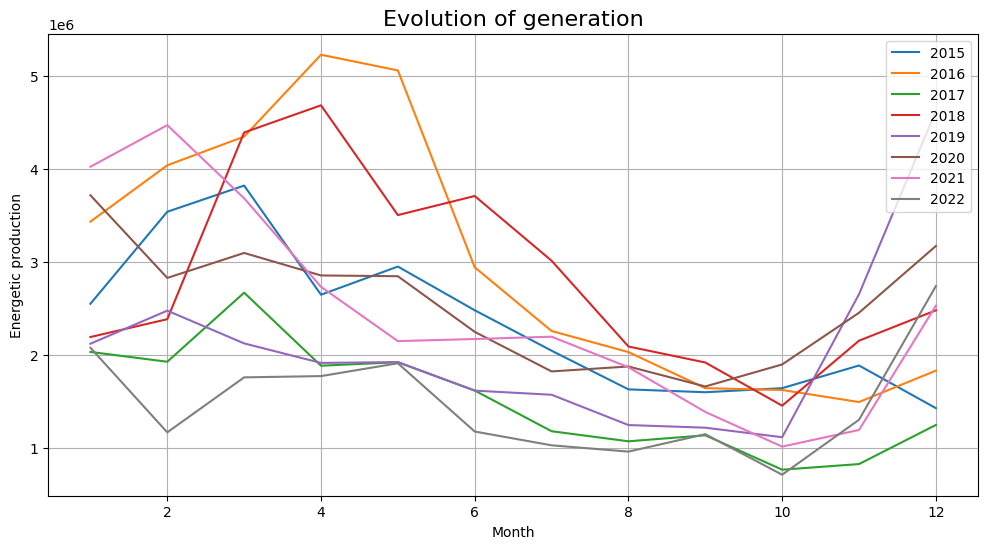

In [ ]:
#LET'S take a look at the generation over the years and on a single year:
plot_generation_evolution(df_hidraulica)

It is interesting to see how the generation start to increase in november when the rainy season has already started. Year 2022 has been a bad year for hidrualic generation, one of the lowest of the last years, as expected due to the lack of rain during the year.

It is true that hidraulic generation does not understand 'administrative' limits as the production and the dams, all the documentation related provided by the ministeries etc. Is split by the river basin and not in CCAAs. However, based on the location of the dams we have been able to alocate and relate all of them to a CCAA, so we can see the information in the same way we have for the other technologies:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


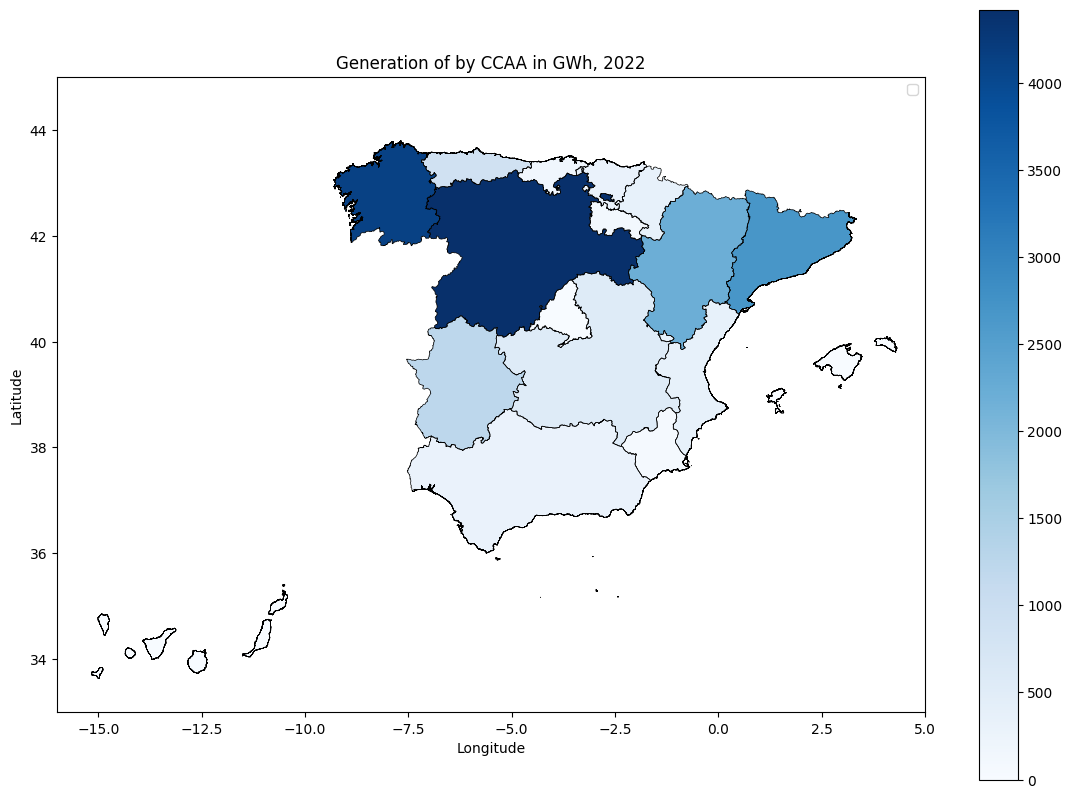

In [ ]:
plot_map_generation(spain,df_hidraulica, 2022)

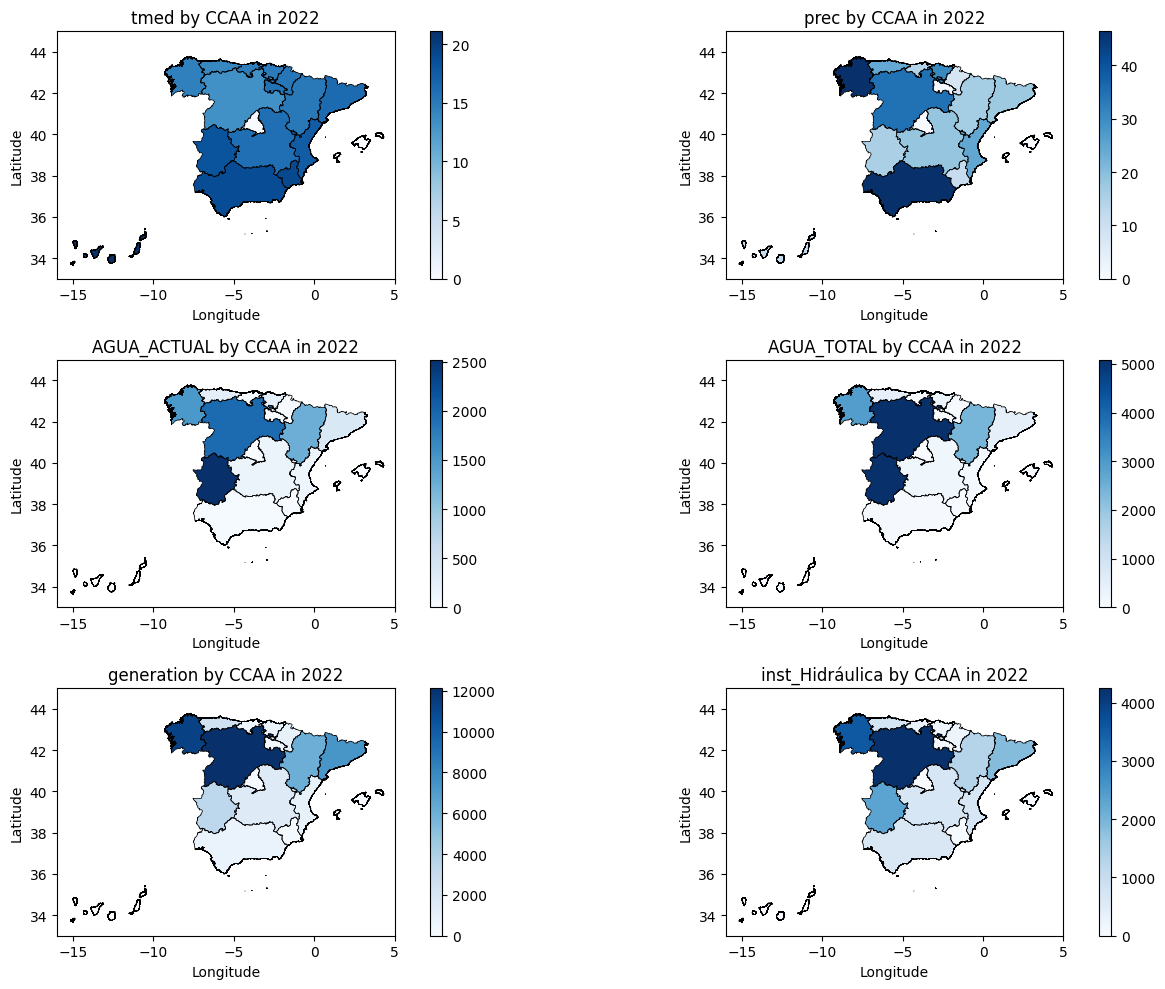

In [ ]:
plot_map_generation_withvariables(spain, df_hidraulica,2022)

This map is not only interesting because it gives us the view of the relation between variables (negative correlation with 'tmed') but also because it shows clearly the situation of hidrological resources in some autonomies like Cataluña.

#### 1.6.5 Demand

The ultimate goal of this project would be to understand the relation between demand and renewable energy genereation in order to see what % of demand can be fullfiled with the estimated generation based on weather forecast. This would help to have a better understaing and prediction of our energetic model and could help to save money to the 'common citizens' as renewable energy is cheaper in principle. \
Taking all this into consideration, it is makes specially relevant to understand how demand works and to see if it is something that can be predicted also based on weather forecast variables and depending on if it's a weekday or not. For sure there are some economical or sociopolitical variables that won't be part of the model and may affect to the demand, but the aim here is to really analyze if the model can work properly exclusively based on weather forecasting. Let's see if we can get some conclusions just visualizing the data of the 'demand dataframe':

In [ ]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52595 entries, 0 to 52594
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               52595 non-null  datetime64[ns]
 1   comunidad_autonoma  52595 non-null  object        
 2   tmed                52595 non-null  float64       
 3   sol                 51351 non-null  float64       
 4   Weekday             52595 non-null  int64         
 5   prec                52595 non-null  float64       
 6   demand_ccaa         52595 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
#We already have the dataframe filtered:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52595 entries, 0 to 52594
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               52595 non-null  datetime64[ns]
 1   comunidad_autonoma  52595 non-null  object        
 2   tmed                52595 non-null  float64       
 3   sol                 51351 non-null  float64       
 4   Weekday             52595 non-null  int64         
 5   prec                52595 non-null  float64       
 6   demand_ccaa         52595 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
#This is how it looks like:
df_demand.head()

fecha comunidad_autonoma   tmed   sol  Weekday  prec  demand_ccaa
0 2015-01-01          ANDALUCIA  8.434 4.000        1 0.000    88259.789
1 2015-01-01             ARAGON  5.167 4.000        1 0.000    22882.569
2 2015-01-01           CANARIAS 17.250 2.000        1 0.000    18441.931
3 2015-01-01          CANTABRIA  7.357 4.000        1 0.000     9493.101
4 2015-01-01    CASTILLA Y LEON  4.191 4.000        1 0.000    32044.289

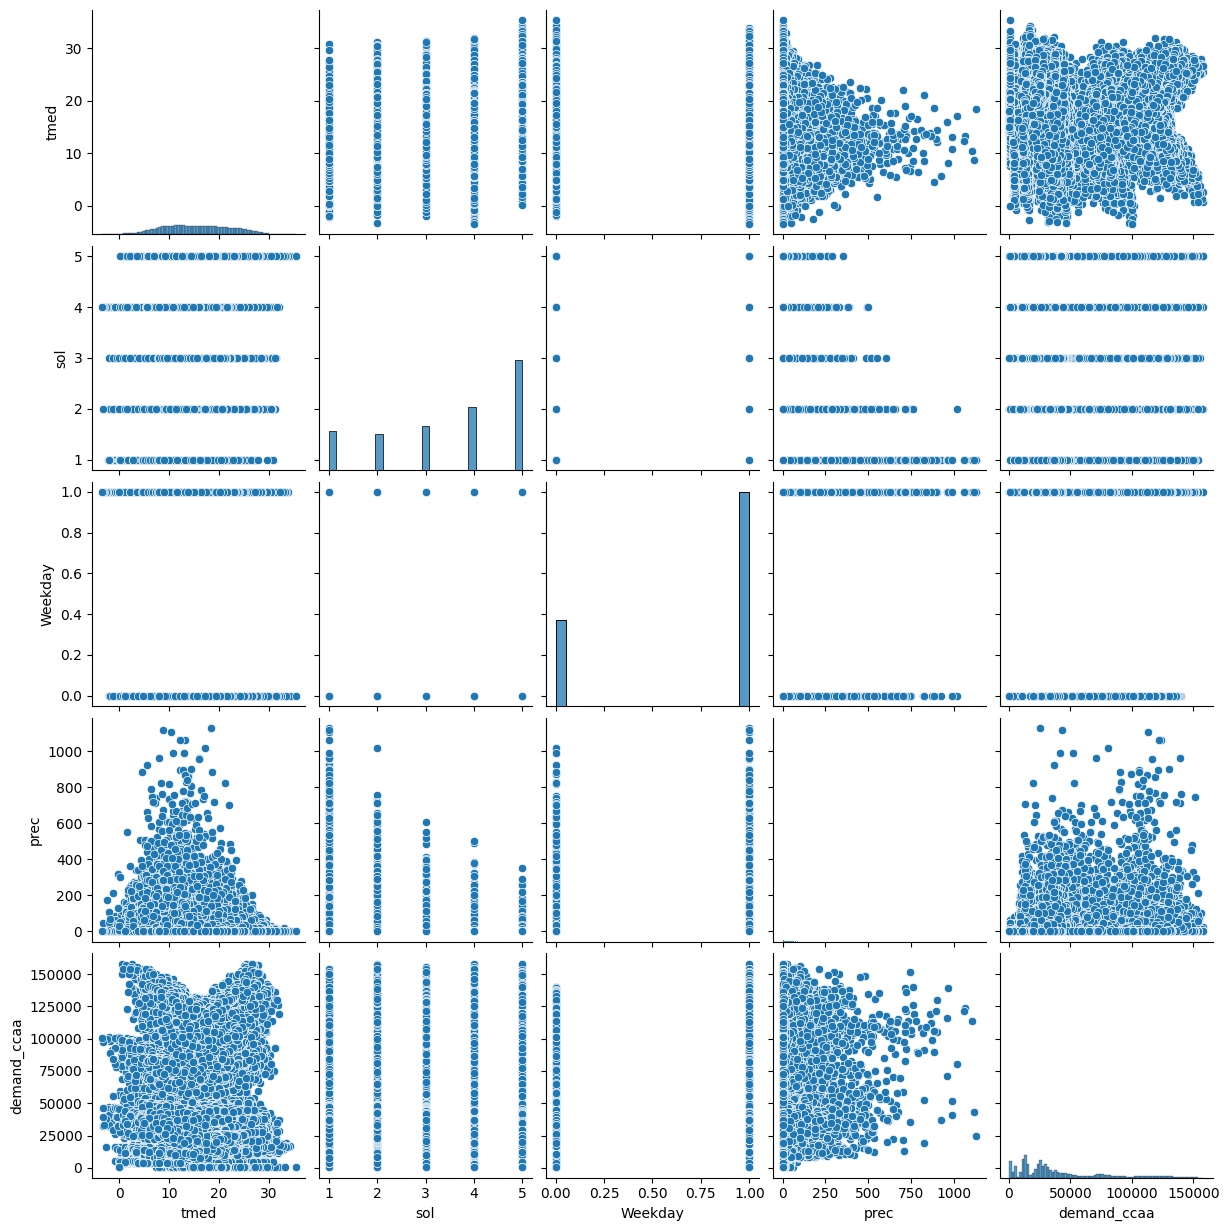

In [ ]:
plot_correlation(df_demand)

we are including 'weekday', 'tmed' (interesting to see how when the temperature it's about 15º the demand decreases).

In [ ]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52595 entries, 0 to 52594
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               52595 non-null  datetime64[ns]
 1   comunidad_autonoma  52595 non-null  object        
 2   tmed                52595 non-null  float64       
 3   sol                 51351 non-null  float64       
 4   Weekday             52595 non-null  int64         
 5   prec                52595 non-null  float64       
 6   demand_ccaa         52595 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.8+ MB


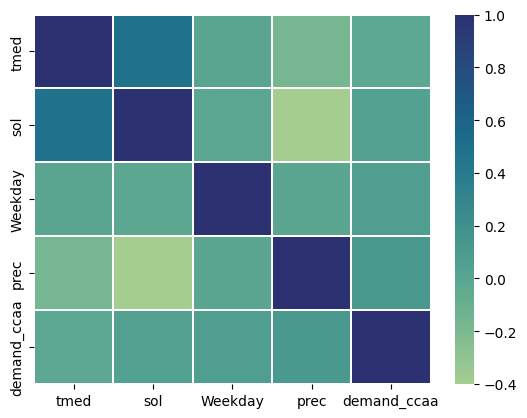

In [ ]:
plot_heatmap(df_demand)

We have to change a little bit some oif the functions we have used for 'generation' dataframes:

In [ ]:
def plot_demand_evolution(demand_dataframe):

    years = demand_dataframe['fecha'].dt.year.unique()

    plt.figure(figsize = (12,6))

    for year in years:
    
        year_data = demand_dataframe[demand_dataframe['fecha'].dt.year == year]
        year_monthly_sum = year_data.groupby(year_data['fecha'].dt.month)['demand_ccaa'].sum()
        plt.plot(year_monthly_sum.index, year_monthly_sum.values, label=year)
    plt.xlabel('Month')
    plt.ylabel('Energetic demand')
    plt.legend()
    plt.grid(True)
    plt.title(f'Evolution of demand', fontsize=16)
    plt.show()


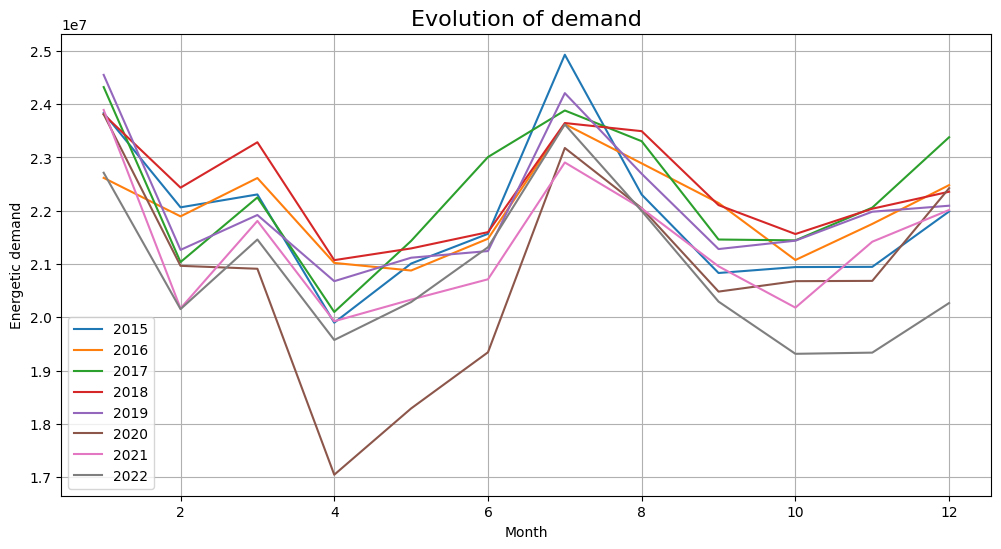

In [ ]:
plot_demand_evolution(df_demand)

The demand seems to be higher in summer -july and august- and in winter - december, january -  proabably related to the extreme temperatures at those months of the year.

In [ ]:
def plot_map_demand(map_file, dataframe, year):

    dataframe = dataframe[dataframe['fecha'].dt.year == year]
    dataframe = dataframe.groupby('comunidad_autonoma')['demand_ccaa'].sum()
    spain = pd.merge(map_file, dataframe, on='comunidad_autonoma', how='left').fillna(0)

    #Transform generation into GWh:

    spain['demand_ccaa'] = spain['demand_ccaa']/1000

    # Plot:
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot the boundaries between comunidades autónomas
    spain['geometry'].boundary.plot(ax=ax, linewidth=0.5, color='black')

    # Use ax parameter for both plots
    spain.plot(column='demand_ccaa', legend=True, ax=ax, cmap = 'Blues')
    
    # Adjust the map limits
    ax.set_xlim(-16, 5) 
    ax.set_ylim(33, 45)

    plt.title(f'Demand of by CCAA in GWh, {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


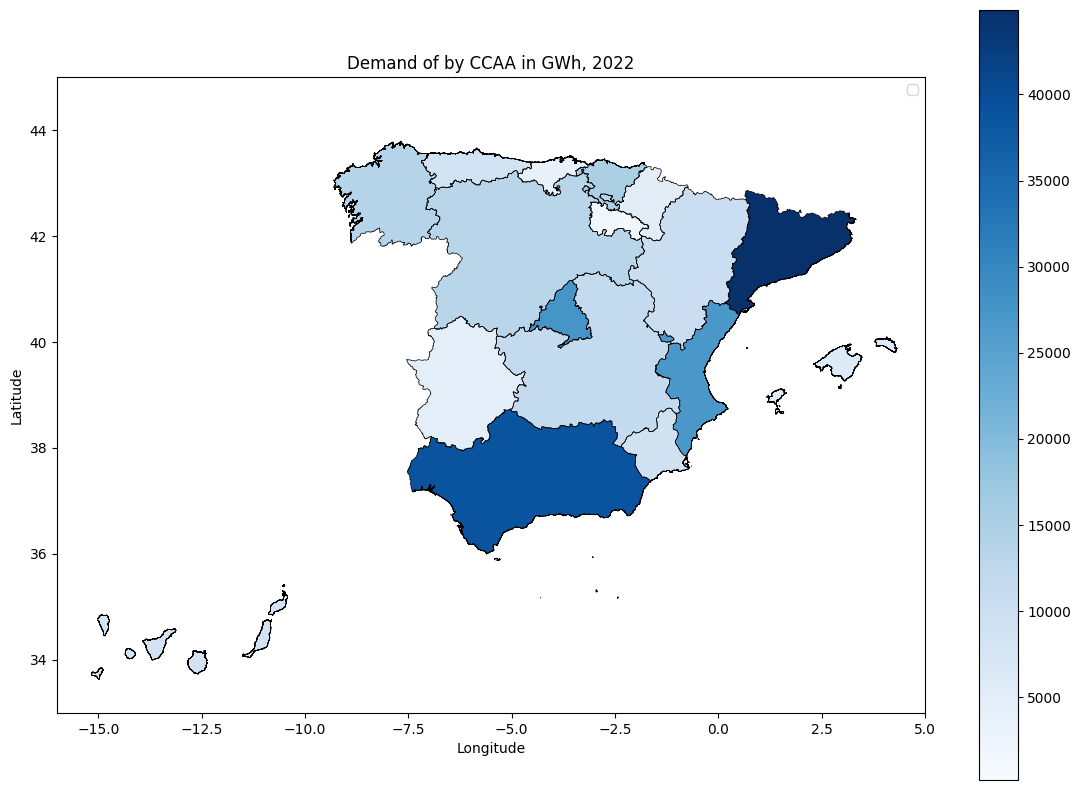

In [ ]:
plot_map_demand(spain, df_demand,2022)

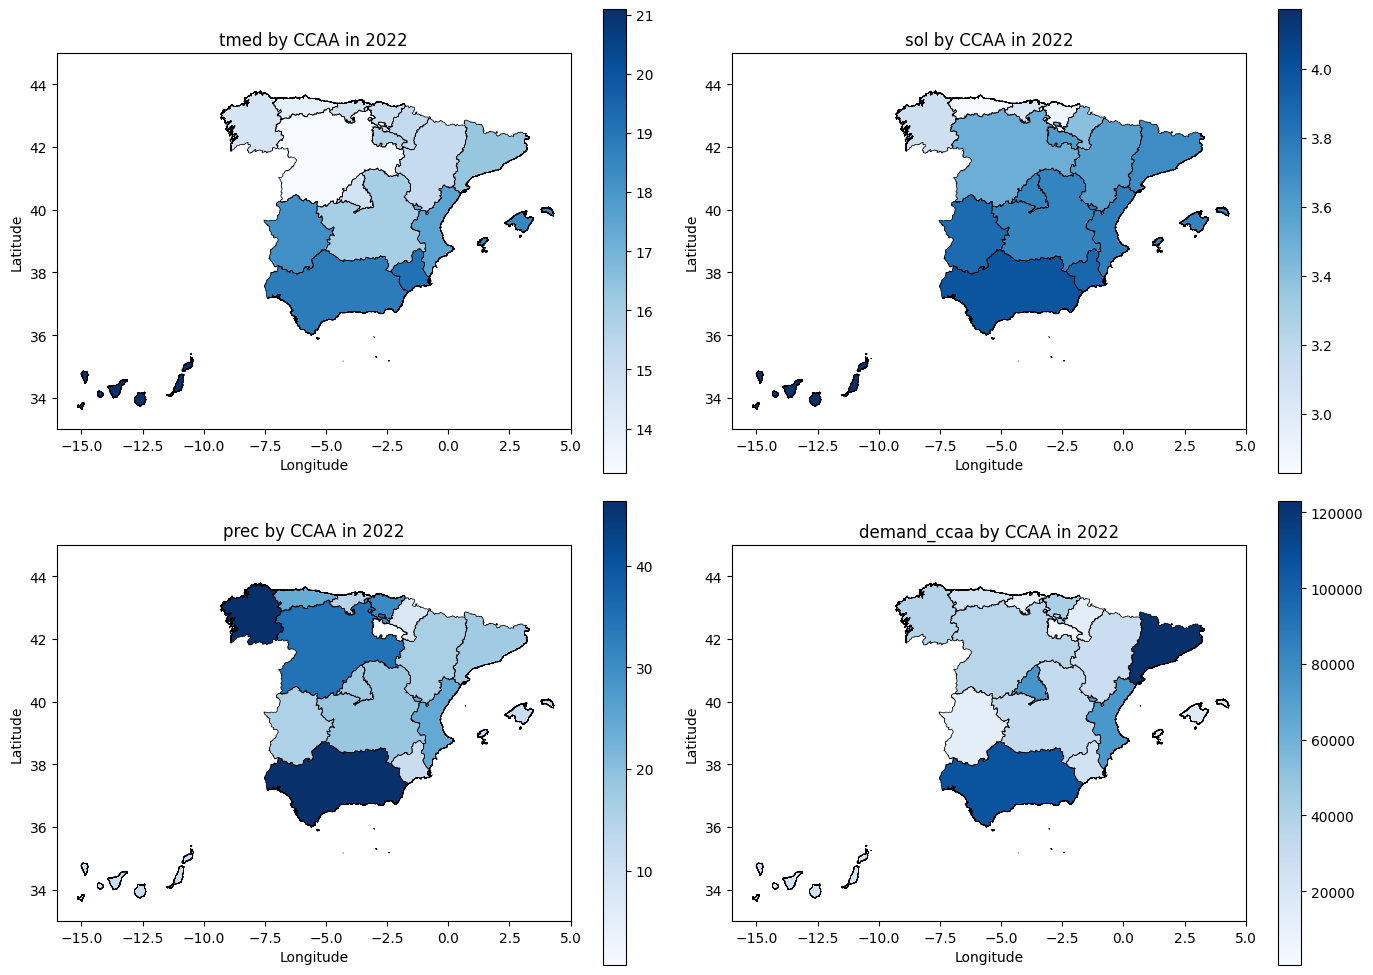

In [ ]:
plot_map_generation_withvariables(spain, df_demand, 2022)

## 2. Modelling

As it has been done along the whole project, the idea is to hace separate separate models for each techonology. The proccess for each techonology will be very similar, the models used will have similar parameters, but for each technology the variables affect in a different way. We willl include the picture of all of the models afterwards, but it is necessary to have them separated.
The models will be created using sklearn regression algorithms -we only need regression estimators for this project- and before creating the models two adjustments that have been commented already along the project have to be implemented for each dataframe: normalization and onehotencoder for the 'comunidad autonoma' variable.

In [2]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

We are creating now the function we  will use to standarize data and to recategorize 'comunidad_autonoma' in order to apply correctly the model. For standarization purpose we are using StandardScaler & Minmax scaler. Other possibilities such as applying logarithms have been tried inm other notebooks, but with lower perfomance as there are '0' values that can lead to an error.

In [3]:
#shortcut, can be omitted
#df_solarfotovoltaica = pd.read_csv('./Processed_Dataframes/solarfotovoltaica_df.csv').drop(columns = 'Unnamed: 0')
#df_solartermica = pd.read_csv('./Processed_Dataframes/solartermica_df.csv').drop(columns = 'Unnamed: 0')
#df_eolica = pd.read_csv('./Processed_Dataframes/eolica_df.csv').drop(columns = 'Unnamed: 0')
#df_hidraulica = pd.read_csv('./Processed_Dataframes/hidraulica_df.csv').drop(columns = 'Unnamed: 0')
#df_demand= pd.read_csv('./Processed_Dataframes/demand_df.csv').drop(columns = 'Unnamed: 0')


### 2.1 Scalers

We are going to train the model with both scalers: standard & MinMax to see which one bring the best results.
We are analyzing the formulas to use here, however, the scalation will be made inside the 'model' functions.

In [ ]:
#Let's test it with 'solar fotovolatica'
df_solarfotovoltaica.head()

fecha  comunidad_autonoma   tmed   tmax  velmedia   sol  generation  \
0  2015-01-01           ANDALUCIA  8.434 15.422     2.400 4.000    3949.598   
1  2015-01-01              ARAGON  5.167 12.383     1.818 4.000     609.142   
2  2015-01-01            CANARIAS 17.250 19.519     4.779 2.000     687.741   
3  2015-01-01     CASTILLA Y LEON  4.191 11.926     1.653 4.000    1670.228   
4  2015-01-01  CASTILLA-LA MANCHA  3.808 11.616     1.124 4.000    4539.090   

   inst_Solar fotovoltaica  
0                  875.280  
1                  168.540  
2                  167.660  
3                  494.100  
4                  923.420

In [ ]:
df_solarfotovoltaica.describe()

tmed      tmax  velmedia       sol  generation  \
count 43829.000 43829.000 43829.000 42991.000   43829.000   
mean     15.770    21.314     2.877     3.653    2412.677   
std       6.744     7.664     1.208     1.402    3860.570   
min      -3.492    -0.725     0.000     1.000       4.545   
25%      10.414    15.300     2.042     3.000     328.272   
50%      15.560    21.000     2.650     4.000     974.540   
75%      21.220    27.111     3.455     5.000    2844.573   
max      34.234    43.696    11.100     5.000   39044.841   

       inst_Solar fotovoltaica  
count                43829.000  
mean                   550.150  
std                    794.810  
min                      2.420  
25%                     85.600  
50%                    205.720  
75%                    585.660  
max                   5345.580

In [4]:
def standarization_standard_scaler (dataframe):

    dataframe_st = dataframe.copy()
    scaler = StandardScaler()
    #In order to standarize values of the dataframes and get better results in the model by removing the mean and scaling to unit variance.
    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in dataframe_st.columns if dataframe_st[col].dtype in ['int64', 'float64'] \
                          and col != ['generation','demand_ccaa', 'fecha'] \
                            and not col.startswith('comunidad')]

    for col in cols_to_standarize:
        dataframe_st[col] = scaler.fit_transform(dataframe_st[[col]])
    
    return dataframe_st

    


In [5]:
def standarization_minmax_scaler (dataframe):

    dataframe_st = dataframe.copy()
    scaler = MinMaxScaler()
    #It allows to scale data to range (0,1)
    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in dataframe_st.columns if dataframe_st[col].dtype in ['int64', 'float64'] \
                        and col != ['generation','demand_ccaa'] \
                        and not col.startswith('comunidad')]

    for col in cols_to_standarize:
        dataframe_st[col] = scaler.fit_transform(dataframe_st[[col]])
    
    return dataframe_st

In [ ]:
df_solarfotovoltaica_standard = standarization_standard_scaler(df_solarfotovoltaica)

In [ ]:
df_solarfotovoltaica_standard.describe()

tmed      tmax  velmedia       sol  generation  \
count 43829.000 43829.000 43829.000 42991.000   43829.000   
mean     -0.000     0.000     0.000    -0.000      -0.000   
std       1.000     1.000     1.000     1.000       1.000   
min      -2.856    -2.876    -2.381    -1.892      -0.624   
25%      -0.794    -0.785    -0.691    -0.465      -0.540   
50%      -0.031    -0.041    -0.188     0.248      -0.373   
75%       0.808     0.756     0.479     0.961       0.112   
max       2.738     2.921     6.806     0.961       9.489   

       inst_Solar fotovoltaica  
count                43829.000  
mean                    -0.000  
std                      1.000  
min                     -0.689  
25%                     -0.584  
50%                     -0.433  
75%                      0.045  
max                      6.033

In [ ]:
df_solarfotovoltaica_minmax = standarization_minmax_scaler(df_solarfotovoltaica)

In [ ]:
df_solarfotovoltaica_minmax.describe()

tmed      tmax  velmedia       sol  generation  \
count 43829.000 43829.000 43829.000 42991.000   43829.000   
mean      0.511     0.496     0.259     0.663       0.062   
std       0.179     0.173     0.109     0.351       0.099   
min       0.000     0.000     0.000     0.000       0.000   
25%       0.369     0.361     0.184     0.500       0.008   
50%       0.505     0.489     0.239     0.750       0.025   
75%       0.655     0.627     0.311     1.000       0.073   
max       1.000     1.000     1.000     1.000       1.000   

       inst_Solar fotovoltaica  
count                43829.000  
mean                     0.103  
std                      0.149  
min                      0.000  
25%                      0.016  
50%                      0.038  
75%                      0.109  
max                      1.000

### 2.2 OneHotEncoder

In [7]:
from sklearn.preprocessing import OneHotEncoder

One of the main purposes of the project is to analyze the weather information we have geographically (by 'comunidad autonoma' in this case). To do so it is necessary to recategorize 'comunidad_autonoma' value using OneHotEncoder. Pd_get_dummies could be another option, it could lead to problems aftwards when handling test data (see https://albertum.medium.com/preprocessing-onehotencoder-vs-pandas-get-dummies-3de1f3d77dcc). Encoding is basic, Otherwise the results would be poor or missundersating.

In [6]:
def onehotencoder_ccaa (dataframe):

    dataframe_enc = dataframe.copy()
    enc = OneHotEncoder() 
    encoded_feature = enc.fit_transform(dataframe_enc[['comunidad_autonoma']]).toarray() #it only works with arrays
    df_feature = pd.DataFrame(encoded_feature, columns = enc.get_feature_names_out(['comunidad_autonoma']))
    dataframe_enc = dataframe_enc.drop('comunidad_autonoma', axis = 1)
    dataframe_enc = dataframe_enc.reset_index(drop=True)
    df_encoded = pd.concat([dataframe_enc, df_feature], axis = 1)
    return df_encoded


In [ ]:
df_solarfotovoltaica_encoded = onehotencoder_ccaa(df_solarfotovoltaica)
df_solarfotovoltaica_encoded.head()

fecha   tmed   tmax  velmedia   sol  generation  \
0  2015-01-01  8.434 15.422     2.400 4.000    3949.598   
1  2015-01-01  5.167 12.383     1.818 4.000     609.142   
2  2015-01-01 17.250 19.519     4.779 2.000     687.741   
3  2015-01-01  4.191 11.926     1.653 4.000    1670.228   
4  2015-01-01  3.808 11.616     1.124 4.000    4539.090   

   inst_Solar fotovoltaica  comunidad_autonoma_ANDALUCIA  \
0                  875.280                         1.000   
1                  168.540                         0.000   
2                  167.660                         0.000   
3                  494.100                         0.000   
4                  923.420                         0.000   

   comunidad_autonoma_ARAGON  comunidad_autonoma_CANARIAS  ...  \
0                      0.000                        0.000  ...   
1                      1.000                        0.000  ...   
2                      0.000                        1.000  ...   
3                      0.000                        0.000  ...   
4                      0.000                        0.000  ...   

   comunidad_autonoma_CATALUNA  comunidad_autonoma_COMUNIDAD DE MADRID  \
0                        0.000                                   0.000   
1                        0.000                                   0.000   
2                        0.000                                   0.000   
3                        0.000                                   0.000   
4                        0.000                                   0.000   

   comunidad_autonoma_COMUNIDAD FORAL DE NAVARRA  \
0                                          0.000   
1                                          0.000   
2                                          0.000   
3                                          0.000   
4                                          0.000   

   comunidad_autonoma_COMUNITAT VALENCIANA  comunidad_autonoma_EXTREMADURA  \
0                                    0.000                           0.000   
1                                    0.000                           0.000   
2                                    0.000                           0.000   
3                                    0.000                           0.000   
4                                    0.000                           0.000   

   comunidad_autonoma_GALICIA  comunidad_autonoma_ILLES BALEARS  \
0                       0.000                             0.000   
1                       0.000                             0.000   
2                       0.000                             0.000   
3                       0.000                             0.000   
4                       0.000                             0.000   

   comunidad_autonoma_LA RIOJA  comunidad_autonoma_PAIS VASCO  \
0                        0.000                          0.000   
1                        0.000                          0.000   
2                        0.000                          0.000   
3                        0.000                          0.000   
4                        0.000                          0.000   

   comunidad_autonoma_REGION DE MURCIA  
0                                0.000  
1                                0.000  
2                                0.000  
3                                0.000  
4                                0.000  

[5 rows x 22 columns]

In [ ]:
df_solarfotovoltaica_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43829 entries, 0 to 43828
Data columns (total 22 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   fecha                                          43829 non-null  object 
 1   tmed                                           43829 non-null  float64
 2   tmax                                           43829 non-null  float64
 3   velmedia                                       43829 non-null  float64
 4   sol                                            42991 non-null  float64
 5   generation                                     43829 non-null  float64
 6   inst_Solar fotovoltaica                        43829 non-null  float64
 7   comunidad_autonoma_ANDALUCIA                   43829 non-null  float64
 8   comunidad_autonoma_ARAGON                      43829 non-null  float64
 9   comunidad_autonoma_CANARIAS                    438

Now that we have the main variables standarized and the 'comunidad_autonoma' encoded, we can start working on the models. The scaler to be used would be a parameter to take into consideration when making a param_grid to see which one fits the best.

### 2.3 Models

We are going to create and prepare several models to try with the dataframes we already have prepared for each technology. We will analyze afterwards which model fits better to each technology. Sklearn does already provide some of the most famous algorithms ready to be used easily, and that is what we are going to do.

#### 2.3.1 Linear Regression

In [ ]:
df_solarfotovoltaica_encoded.head()

fecha   tmed   tmax  velmedia   sol  generation  \
0  2015-01-01  8.434 15.422     2.400 4.000    3949.598   
1  2015-01-01  5.167 12.383     1.818 4.000     609.142   
2  2015-01-01 17.250 19.519     4.779 2.000     687.741   
3  2015-01-01  4.191 11.926     1.653 4.000    1670.228   
4  2015-01-01  3.808 11.616     1.124 4.000    4539.090   

   inst_Solar fotovoltaica  comunidad_autonoma_ANDALUCIA  \
0                  875.280                         1.000   
1                  168.540                         0.000   
2                  167.660                         0.000   
3                  494.100                         0.000   
4                  923.420                         0.000   

   comunidad_autonoma_ARAGON  comunidad_autonoma_CANARIAS  ...  \
0                      0.000                        0.000  ...   
1                      1.000                        0.000  ...   
2                      0.000                        1.000  ...   
3                      0.000                        0.000  ...   
4                      0.000                        0.000  ...   

   comunidad_autonoma_CATALUNA  comunidad_autonoma_COMUNIDAD DE MADRID  \
0                        0.000                                   0.000   
1                        0.000                                   0.000   
2                        0.000                                   0.000   
3                        0.000                                   0.000   
4                        0.000                                   0.000   

   comunidad_autonoma_COMUNIDAD FORAL DE NAVARRA  \
0                                          0.000   
1                                          0.000   
2                                          0.000   
3                                          0.000   
4                                          0.000   

   comunidad_autonoma_COMUNITAT VALENCIANA  comunidad_autonoma_EXTREMADURA  \
0                                    0.000                           0.000   
1                                    0.000                           0.000   
2                                    0.000                           0.000   
3                                    0.000                           0.000   
4                                    0.000                           0.000   

   comunidad_autonoma_GALICIA  comunidad_autonoma_ILLES BALEARS  \
0                       0.000                             0.000   
1                       0.000                             0.000   
2                       0.000                             0.000   
3                       0.000                             0.000   
4                       0.000                             0.000   

   comunidad_autonoma_LA RIOJA  comunidad_autonoma_PAIS VASCO  \
0                        0.000                          0.000   
1                        0.000                          0.000   
2                        0.000                          0.000   
3                        0.000                          0.000   
4                        0.000                          0.000   

   comunidad_autonoma_REGION DE MURCIA  
0                                0.000  
1                                0.000  
2                                0.000  
3                                0.000  
4                                0.000  

[5 rows x 22 columns]

In [ ]:
df_solarfotovoltaica_encoded.describe()

tmed      tmax  velmedia       sol  generation  \
count 43829.000 43829.000 43829.000 42991.000   43829.000   
mean     15.770    21.314     2.877     3.653    2412.677   
std       6.744     7.664     1.208     1.402    3860.570   
min      -3.492    -0.725     0.000     1.000       4.545   
25%      10.414    15.300     2.042     3.000     328.272   
50%      15.560    21.000     2.650     4.000     974.540   
75%      21.220    27.111     3.455     5.000    2844.573   
max      34.234    43.696    11.100     5.000   39044.841   

       inst_Solar fotovoltaica  comunidad_autonoma_ANDALUCIA  \
count                43829.000                     43829.000   
mean                   550.150                         0.067   
std                    794.810                         0.249   
min                      2.420                         0.000   
25%                     85.600                         0.000   
50%                    205.720                         0.000   
75%                    585.660                         0.000   
max                   5345.580                         1.000   

       comunidad_autonoma_ARAGON  comunidad_autonoma_CANARIAS  \
count                  43829.000                    43829.000   
mean                       0.067                        0.067   
std                        0.249                        0.249   
min                        0.000                        0.000   
25%                        0.000                        0.000   
50%                        0.000                        0.000   
75%                        0.000                        0.000   
max                        1.000                        1.000   

       comunidad_autonoma_CASTILLA Y LEON  ...  comunidad_autonoma_CATALUNA  \
count                           43829.000  ...                    43829.000   
mean                                0.067  ...                        0.067   
std                                 0.249  ...                        0.249   
min                                 0.000  ...                        0.000   
25%                                 0.000  ...                        0.000   
50%                                 0.000  ...                        0.000   
75%                                 0.000  ...                        0.000   
max                                 1.000  ...                        1.000   

       comunidad_autonoma_COMUNIDAD DE MADRID  \
count                               43829.000   
mean                                    0.067   
std                                     0.249   
min                                     0.000   
25%                                     0.000   
50%                                     0.000   
75%                                     0.000   
max                                     1.000   

       comunidad_autonoma_COMUNIDAD FORAL DE NAVARRA  \
count                                      43829.000   
mean                                           0.067   
std                                            0.249   
min                                            0.000   
25%                                            0.000   
50%                                            0.000   
75%                                            0.000   
max                                            1.000   

       comunidad_autonoma_COMUNITAT VALENCIANA  \
count                                43829.000   
mean                                     0.067   
std                                      0.249   
min                                      0.000   
25%                                      0.000   
50%                                      0.000   
75%                                      0.000   
max                                      1.000   

       comunidad_autonoma_EXTREMADURA  comunidad_autonoma_GALICIA  \
count                       43829.000                   43829.000   
mean                            0.067             

In [8]:
def model_lr (dataframe, scaler):

    #It is necessary to filter previously to get the desired columns and avoid the small number of 'na'.
    dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    dataframe = dataframe.dropna()

    #'prec' is not available on AEMET predictions and is not actually highly related to any tech.

    if 'prec' in dataframe.columns:
        dataframe = dataframe.drop(columns=['prec'])
        
    if 'generation' in dataframe.columns:

        X = dataframe.drop('generation', axis = 1)
        y = dataframe['generation']
    else:
        X = dataframe.drop('demand_ccaa', axis = 1)
        y = dataframe['demand_ccaa']

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] \
                        and not col.startswith('comunidad')]
    
    #We only want to scalate some values
    X_train_scaled_values = scaler.fit_transform(X_train[cols_to_standarize])
    X_test_scaled_values = scaler.transform(X_test[cols_to_standarize])

    X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=cols_to_standarize, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=cols_to_standarize, index=X_test.index)

    # CLet's merge again the data
    X_train_scaled = pd.concat([X_train_scaled_df, X_train.drop(cols_to_standarize, axis=1) ], axis=1)
    X_test_scaled = pd.concat([X_test_scaled_df, X_test.drop(cols_to_standarize, axis=1) ], axis=1)
    
    #Estimator would be LR from sklearn

    reg = LinearRegression()

    #Fit in order to train the data
    reg.fit(X_train_scaled,y_train)

    #Metrics of the model we want to know

    predictions = np.round(reg.predict(X_test_scaled),3)
    MAE = np.round(mean_absolute_error(y_test, predictions),3)
    r2 = np.round(r2_score(y_test, predictions),3)
    MSE = np.round(mean_squared_error(y_test,predictions, squared = True),3)
    RMSE = np.round(mean_squared_error(y_test,predictions, squared = False),3)

    #Crossvalidation

    cv = cross_val_score(reg, X_train_scaled, y_train, cv = 5, scoring = 'r2')
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)
    
    results = {
    'MAE': MAE,
    'MSE': MSE,
    'r2': cv_mean,
    'RMSE': RMSE,
    'best_params': None,
    'best_estimator': None,
    'best_alpha': None,
    'best_l1ratio_': None}

    return results, predictions, reg

In [ ]:
model_lr(df_solarfotovoltaica_encoded, StandardScaler())

({'MAE': 842.013,
  'MSE': 2214716.314,
  'r2': 0.854,
  'RMSE': 1488.192,
  'best_params': None,
  'best_estimator': None,
  'best_alpha': None,
  'best_l1ratio_': None},
 array([20538.158,  -962.032,  5648.717, ...,  1414.044,  5902.19 ,
         -155.224]),
 LinearRegression())

#### 2.3.2 KNeighbors

In [9]:
from sklearn.model_selection import GridSearchCV

Using GridSearchCV, from sklearn, the model will find which parameter (nº of neighbors) would be better for the model. It allows us to test for several parameters which one obtains the best results in the model we are working with.

In [10]:
def model_knn (dataframe, scaler):

    #It is necessary to filter previously to get the desired columns and avoid the small number of 'na'.
    dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    dataframe = dataframe.dropna()
    

    #'prec' is not available on AEMET predictions and is not actually highly related to any tech.

    if 'prec' in dataframe.columns:
        dataframe = dataframe.drop(columns=['prec'])
        

    if 'generation' in dataframe.columns:

        X = dataframe.drop('generation', axis = 1)
        y = dataframe['generation']
    else:
        X = dataframe.drop('demand_ccaa', axis = 1)
        y = dataframe['demand_ccaa']

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] \
                        and not col.startswith('comunidad')]
    
    #We only want to scalate some values
    X_train_scaled_values = scaler.fit_transform(X_train[cols_to_standarize])
    X_test_scaled_values = scaler.transform(X_test[cols_to_standarize])

    X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=cols_to_standarize, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=cols_to_standarize, index=X_test.index)

    # CLet's merge again the data
    X_train_scaled = pd.concat([X_train_scaled_df, X_train.drop(cols_to_standarize, axis=1) ], axis=1)
    X_test_scaled = pd.concat([X_test_scaled_df, X_test.drop(cols_to_standarize, axis=1) ], axis=1)


    #Estimator would be KNN from sklearn

    reg = KNeighborsRegressor()

    #We are using GridSearchCV to get the best model possible according to the nº of neighbors included as param:

    param_grid = {'n_neighbors': [3,5,7,10,12]}
    
    #We define the GridSearchObject:

    grid = GridSearchCV(reg, param_grid, cv = 5)

    #Fit in order to train the data
    grid.fit(X_train_scaled,y_train)

    #Best estimator would be:

    reg = grid.best_estimator_

    #Metrics of the model we want to know

    predictions = np.round(reg.predict(X_test_scaled),3)
    MAE = np.round(mean_absolute_error(y_test, predictions),3)
    r2 = np.round(r2_score(y_test, predictions),3)
    MSE = np.round(mean_squared_error(y_test,predictions, squared = True),3)
    RMSE = np.round(mean_squared_error(y_test,predictions, squared = False),3)

    results = {
    'MAE': MAE,
    'MSE': MSE,
    'r2': r2,
    'RMSE': RMSE,
    'best_params': grid.best_params_,
    'best_estimator': reg,
    'best_alpha': None,
    'best_l1ratio_': None}

    return results, predictions, reg

In [ ]:
model_knn(df_solarfotovoltaica_encoded, StandardScaler())

({'MAE': 362.321,
  'MSE': 563296.161,
  'r2': 0.961,
  'RMSE': 750.531,
  'best_params': {'n_neighbors': 7},
  'best_estimator': KNeighborsRegressor(n_neighbors=7),
  'best_alpha': None,
  'best_l1ratio_': None},
 array([21340.802,    33.457,  3711.991, ...,  1603.287,  5937.326,
          344.222]),
 KNeighborsRegressor(n_neighbors=7))

#### 2.3.3 RandomForestRegressor

In [11]:
def model_random_forest (dataframe, scaler):

    #It is necessary to filter previously to get the desired columns and avoid the small number of 'na'.
    dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    dataframe = dataframe.dropna()

    #'prec' is not available on AEMET predictions and is not actually highly related to any tech.

    if 'prec' in dataframe.columns:
        dataframe = dataframe.drop(columns=['prec'])

    if 'generation' in dataframe.columns:

        X = dataframe.drop('generation', axis = 1)
        y = dataframe['generation']
    else:
        X = dataframe.drop('demand_ccaa', axis = 1)
        y = dataframe['demand_ccaa']

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] \
                        and not col.startswith('comunidad')]
    
    #We only want to scalate some values
    X_train_scaled_values = scaler.fit_transform(X_train[cols_to_standarize])
    X_test_scaled_values = scaler.transform(X_test[cols_to_standarize])

    X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=cols_to_standarize, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=cols_to_standarize, index=X_test.index)

    # CLet's merge again the data
    X_train_scaled = pd.concat([X_train_scaled_df, X_train.drop(cols_to_standarize, axis=1) ], axis=1)
    X_test_scaled = pd.concat([X_test_scaled_df, X_test.drop(cols_to_standarize, axis=1) ], axis=1)
    
    #Estimator would be Rforest from sklearn

    reg = RandomForestRegressor()

    #We are using GridSearchCV to get the best model possible according to:

    param_grid = {'n_estimators': [50,100], #nº of trees (default = 100)
                  #'min_samples_split' : [2,3,], #(default 2) we do not include it in order to acelerate the model
                  'min_samples_leaf' : [1,2,]}  #(default =1)
    
    #We define the GridSearchObject:

    grid = GridSearchCV(reg, param_grid, cv = 5)

    #Fit in order to train the data
    grid.fit(X_train_scaled,y_train)

    #Best estimator would be:

    reg = grid.best_estimator_

    #Metrics of the model we want to know

    predictions = np.round(reg.predict(X_test_scaled),3)
    MAE = np.round(mean_absolute_error(y_test, predictions),3)
    r2 = np.round(r2_score(y_test, predictions),3)
    MSE = np.round(mean_squared_error(y_test,predictions, squared = True),3)
    RMSE = np.round(mean_squared_error(y_test,predictions, squared = False),3)

    results = {
    'MAE': MAE,
    'MSE': MSE,
    'r2': r2,
    'RMSE': RMSE,
    'best_params': grid.best_params_,
    'best_estimator': reg,
    'best_alpha': None,
    'best_l1ratio_': None}

    return results, predictions, reg

In [ ]:
model_random_forest(df_solarfotovoltaica_encoded, StandardScaler())

({'MAE': 291.096,
  'MSE': 371884.271,
  'r2': 0.974,
  'RMSE': 609.823,
  'best_params': {'min_samples_leaf': 1, 'n_estimators': 100},
  'best_estimator': RandomForestRegressor(),
  'best_alpha': None,
  'best_l1ratio_': None},
 array([17788.398,    32.692,  4166.49 , ...,  1665.013,  6155.073,
          279.001]),
 RandomForestRegressor())

#### 2.3.4 Ridge

As we have seen, the results of the models are promising. But they are extremnely promising probably. The results are so optimistic and it can be related to colineality between variables or relation between them. We are trying to use now other models that include data penalization. It includes regularization in the variables we have selected. By doing this we will achieve a better performance of the model, less biased and giving less importance to variables that are not actually quite related to the target.
Information related to the most common ones can be found in the following link (https://cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python)and in sklearn website.

These models will allow us to create also a CV and or GridCV to adjust and try several parameters related to the impact of the regularization into the model.

In [12]:
from sklearn import linear_model

In [13]:
def model_ridge(dataframe, scaler):

    #It is necessary to filter previously to get the desired columns and avoid the small number of 'na'.
    dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    dataframe = dataframe.dropna()

    #'prec' is not available on AEMET predictions and is not actually highly related to any tech.

    if 'prec' in dataframe.columns:
        dataframe = dataframe.drop(columns=['prec'])

    if 'generation' in dataframe.columns:

        X = dataframe.drop('generation', axis = 1)
        y = dataframe['generation']
    else:
        X = dataframe.drop('demand_ccaa', axis = 1)
        y = dataframe['demand_ccaa']

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] \
                        and not col.startswith('comunidad')]
    
    #We only want to scalate some values
    X_train_scaled_values = scaler.fit_transform(X_train[cols_to_standarize])
    X_test_scaled_values = scaler.transform(X_test[cols_to_standarize])

    X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=cols_to_standarize, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=cols_to_standarize, index=X_test.index)

    # CLet's merge again the data
    X_train_scaled = pd.concat([X_train_scaled_df, X_train.drop(cols_to_standarize, axis=1) ], axis=1)
    X_test_scaled = pd.concat([X_test_scaled_df, X_test.drop(cols_to_standarize, axis=1) ], axis=1)
    
    #Estimator would be Ridge from sklearn

    reg = linear_model.RidgeCV(alphas = [0.01, 0.1, 1,10])

    #Fit in order to train the data
    reg.fit(X_train_scaled,y_train)

    #Metrics of the model we want to know

    predictions = np.round(reg.predict(X_test_scaled),3)
    MAE = np.round(mean_absolute_error(y_test, predictions),3)
    r2 = np.round(r2_score(y_test, predictions),3)
    MSE = np.round(mean_squared_error(y_test,predictions, squared = True),3)
    RMSE = np.round(mean_squared_error(y_test,predictions, squared = False),3)

    results = {
    'MAE': MAE,
    'MSE': MSE,
    'r2': r2,
    'RMSE': RMSE,    
    'best_params': None,
    'best_estimator': None,
    'best_alpha' : reg.alpha_,
    'best_l1ratio_': None}

    return results, predictions, reg

In [ ]:
model_ridge(df_solarfotovoltaica_encoded, StandardScaler())

({'MAE': 841.977,
  'MSE': 2214687.159,
  'r2': 0.846,
  'RMSE': 1488.183,
  'best_params': None,
  'best_estimator': None,
  'best_alpha': 1.0,
  'best_l1ratio_': None},
 array([20537.544,  -961.795,  5648.606, ...,  1413.723,  5901.767,
         -154.59 ]),
 RidgeCV(alphas=[0.01, 0.1, 1, 10]))

One of the main models that include regularization is Lasso. However, due to it's tendency to remove features not so relevants -and there are not that many variables in our case- we are going to implement a similar solution: elastic-net. \
Elastic-net mixes both models, Ridge and Lasso, so it can be useful to reduce variance without directly eliminating the variables. Let's see how does it work.

In [14]:
def model_elastic_net(dataframe, scaler):

    #It is necessary to filter previously to get the desired columns and avoid the small number of 'na'.
    dataframe = dataframe.select_dtypes(include=['int64', 'float64'])
    dataframe = dataframe.dropna()

    #'prec' is not available on AEMET predictions and is not actually highly related to any tech.

    if 'prec' in dataframe.columns:
        dataframe = dataframe.drop(columns=['prec'])


    if 'generation' in dataframe.columns:

        X = dataframe.drop('generation', axis = 1)
        y = dataframe['generation']
    else:
        X = dataframe.drop('demand_ccaa', axis = 1)
        y = dataframe['demand_ccaa']

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

    #We don't want to apply standarization to target value or categorical features as it may have an impact on the result:

    cols_to_standarize = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64'] \
                        and not col.startswith('comunidad')]
    
    #We only want to scalate some values
    X_train_scaled_values = scaler.fit_transform(X_train[cols_to_standarize])
    X_test_scaled_values = scaler.transform(X_test[cols_to_standarize])

    X_train_scaled_df = pd.DataFrame(X_train_scaled_values, columns=cols_to_standarize, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled_values, columns=cols_to_standarize, index=X_test.index)

    # CLet's merge again the data
    X_train_scaled = pd.concat([X_train_scaled_df, X_train.drop(cols_to_standarize, axis=1) ], axis=1)
    X_test_scaled = pd.concat([X_test_scaled_df, X_test.drop(cols_to_standarize, axis=1) ], axis=1)
    
    #Estimator would be ElasticNet from sklearn

    reg = linear_model.ElasticNetCV(cv = 5, 
                                    alphas = [0.01, 0.1, 1,10],
                                    l1_ratio=[0.1, 0.25, 0.5,0.75, 0.9])

    #Fit in order to train the data
    reg.fit(X_train_scaled,y_train)

    #Metrics of the model we want to know

    predictions = np.round(reg.predict(X_test_scaled),3)
    MAE = np.round(mean_absolute_error(y_test, predictions),3)
    r2 = np.round(r2_score(y_test, predictions),3)
    MSE = np.round(mean_squared_error(y_test,predictions, squared = True),3)
    RMSE = np.round(mean_squared_error(y_test,predictions, squared = False),3)

    results = {
    'MAE': MAE,
    'MSE': MSE,
    'r2': r2,
    'RMSE': RMSE,
    'best_params': None,
    'best_estimator': None,
    'best_alpha' : reg.alpha_,
    'best_l1ratio_':reg.l1_ratio_}

    return results, predictions, reg

In [ ]:
model_elastic_net(df_solarfotovoltaica_encoded, StandardScaler())

({'MAE': 840.918,
  'MSE': 2213992.17,
  'r2': 0.847,
  'RMSE': 1487.949,
  'best_params': None,
  'best_estimator': None,
  'best_alpha': 0.01,
  'best_l1ratio_': 0.9},
 array([20516.247,  -954.331,  5644.47 , ...,  1404.217,  5887.429,
         -134.259]),
 ElasticNetCV(alphas=[0.01, 0.1, 1, 10], cv=5,
              l1_ratio=[0.1, 0.25, 0.5, 0.75, 0.9]))

As we have commented, it seems that the lower is the l1 ratio, the better is the model.

#### 2.3.5 Model Selection

As for this project it is going to be necessary to repeat all the models created for all the techonolgies to select which is the best one for each technology, it would be great to resume all that process in just a few lines of coding. It will be useful in terms of computational and time consumptions. In order to do so, we are using a function that will help us to understand which model fits the best to each technology.

In [15]:
def model_selection(dataframe_file):

    dataframe = dataframe_file.copy()

    #We are creating a df for storaging and analyzing the results and a dictionary to save the models:

    scores = pd.DataFrame(columns= ['scaler','model','predictions','MAE','MSE','r2','RMSE','best_alpha','best_l1ratio_'])

    trained_models = {}

    scalers = {'StandardScaler': StandardScaler(),
           'MinMaxScaler': MinMaxScaler()}
    
    models = {'LinearRegression': model_lr,
    'KNeighborsRegressor': model_knn,
    'RandomForestRegressor': model_random_forest,
    'RidgeRegressor': model_ridge,
    'model_elastic_net': model_elastic_net}

    dataframe = onehotencoder_ccaa(dataframe)

    
        
        #We are iterating over the models we have created and the two scalers we have selected:

    for model_name, model in models.items():

            for scaler_name, scaler in scalers.items():
                results, predictions, reg = model(dataframe, scaler)
                
                model_score = pd.DataFrame([results])
                model_score['predictions'] = [predictions]
                model_score['scaler'] = scaler_name
                model_score['model'] = model_name

                #Let's append the scores and the model:
                scores = pd.concat([scores, model_score], ignore_index = True)
                trained_models[f'{model_name}_{scaler_name}'] = reg

    scores = scores.sort_values(by='r2', ascending = False, ignore_index=True)

    return scores , trained_models


        

In [16]:
from joblib import dump, load

#We are saving now the trained models so we can use it afterwards without having to process all the model from the begining.

In [ ]:
#solar_resume, solar_models = model_selection(df_solarfotovoltaica)
#dump(solar_models, './Models/solar_models.joblib')
#solar_resume

scaler                  model  \
0  StandardScaler  RandomForestRegressor   
1    MinMaxScaler  RandomForestRegressor   
2  StandardScaler    KNeighborsRegressor   
3    MinMaxScaler    KNeighborsRegressor   
4  StandardScaler       LinearRegression   
5    MinMaxScaler       LinearRegression   
6  StandardScaler      model_elastic_net   
7  StandardScaler         RidgeRegressor   
8    MinMaxScaler         RidgeRegressor   
9    MinMaxScaler      model_elastic_net   

                                         predictions     MAE         MSE  \
0  [18363.899, 31.008, 4250.885, 2429.072, 649.55... 290.405  370234.918   
1  [17584.82, 30.869, 4088.937, 2434.403, 697.178... 292.017  370826.264   
2  [21340.802, 33.457, 3711.991, 2664.008, 652.83... 362.321  563296.161   
3  [19002.914, 29.943, 3535.163, 2405.349, 677.02... 366.252  578139.054   
4  [20538.158, -962.032, 5648.717, 2162.078, 620.... 842.013 2214716.314   
5  [20538.158, -962.032, 5648.717, 2162.078, 620.... 842.013 2214716.314   
6  [20516.247, -954.331, 5644.47, 2167.192, 607.4... 840.918 2213992.170   
7  [20537.544, -961.795, 5648.606, 2162.244, 620.... 841.977 2214687.159   
8  [20537.812, -961.927, 5648.658, 2162.155, 620.... 842.001 2214705.398   
9  [19386.253, -864.915, 5415.928, 2272.677, 493.... 843.104 2249580.680   

     r2     RMSE  best_alpha  best_l1ratio_  \
0 0.974  608.469         NaN            NaN   
1 0.974  608.955         NaN            NaN   
2 0.961  750.531         NaN            NaN   
3 0.960  760.355         NaN            NaN   
4 0.854 1488.192         NaN            NaN   
5 0.854 1488.192         NaN            NaN   
6 0.847 1487.949       0.010          0.900   
7 0.846 1488.183       1.000            NaN   
8 0.846 1488.189       0.010            NaN   
9 0.844 1499.860       0.010          0.900   

                                    best_params  \
0  {'min_samples_leaf': 1, 'n_estimators': 100}   
1  {'min_samples_leaf': 1, 'n_estimators': 100}   
2                            {'n_neighbors': 7}   
3                            {'n_neighbors': 5}   
4                                          None   
5                                          None   
6                                          None   
7                                          None   
8                                          None   
9                                          None   

                                      best_estimator  
0  (DecisionTreeRegressor(max_features=1.0, rando...  
1  (DecisionTreeRegressor(max_features=1.0, rando...  
2                 KNeighborsRegressor(n_neighbors=7)  
3                              KNeighborsRegressor()  
4                                               None  
5                                               None  
6                                               None  
7                                               None  
8                                               None  
9                                               None

### 2.4 Apply model selection for each tech & demand

We have prepared several models with several parameters for each to test, different ways of scalling values... It is now time to apply all those elements to the training data for each techonology and for the demand to see which model works the best for each. 

In order to save the models we are creating the function below:

In [18]:
def save_models(models_dict, tech):
    for model_name_scaler, model_obj in models_dict.items():
        dump(model_obj, f'./Models/{tech}_models_{model_name_scaler}.joblib')


#### 2.4.1 Solar fotovoltaica

In [ ]:
solar_resume, solar_models = model_selection(df_solarfotovoltaica)

solar_resume
#save_models(solar_models, 'solar_foto')

#### 2.4.2 Solar térmica

In [ ]:
df_solartermica.describe()

tmed      tmax  velmedia       sol  generation  inst_Solar_térmica
count 17532.000 17532.000 17532.000 17488.000   17532.000           17532.000
mean     16.879    22.809     2.623     3.880    2193.915             382.804
std       6.760     7.632     0.912     1.300    3399.375             399.516
min      -3.176     1.326     0.711     1.000       0.000               0.780
25%      11.392    16.483     2.004     3.000     115.271              31.400
50%      16.221    22.094     2.500     4.000     368.212             180.195
75%      22.677    29.179     3.048     5.000    2968.436             849.000
max      34.234    43.696     8.200     5.000   15223.496            1000.020

In [ ]:
termica_resume, termica_models = model_selection(df_solartermica)
#dump(termica_models, './Models/termica_models.joblib')
#save_models(termica_models, 'solar_term')

In [ ]:
termica_resume

scaler                  model  \
0  StandardScaler  RandomForestRegressor   
1    MinMaxScaler  RandomForestRegressor   
2    MinMaxScaler    KNeighborsRegressor   
3  StandardScaler    KNeighborsRegressor   
4  StandardScaler         RidgeRegressor   
5    MinMaxScaler         RidgeRegressor   
6  StandardScaler      model_elastic_net   
7  StandardScaler       LinearRegression   
8    MinMaxScaler       LinearRegression   
9    MinMaxScaler      model_elastic_net   

                                         predictions      MAE         MSE  \
0  [1652.968, 66.55, 299.677, 95.975, 134.12, 301...  518.973  974614.466   
1  [1663.668, 71.022, 335.374, 74.174, 118.851, 3...  523.199  992128.627   
2  [1496.6, 99.843, 261.665, 95.108, 89.383, 3185...  531.901 1045601.231   
3  [1362.049, 105.023, 234.276, 179.52, 82.015, 3...  538.175 1060912.627   
4  [1319.867, -214.361, -1178.95, -1330.583, 702.... 1390.764 3318801.870   
5  [1320.592, -214.9, -1178.044, -1330.007, 701.2... 1390.762 3318826.909   
6  [1378.96, -254.94, -1105.63, -1278.495, 581.24... 1390.560 3321994.954   
7  [1319.404, -214.039, -1179.527, -1330.999, 703... 1390.780 3318819.064   
8  [1319.404, -214.039, -1179.527, -1330.999, 703... 1390.780 3318819.064   
9  [1702.593, -480.366, -680.393, -996.007, -142.... 1429.976 3491072.377   

     r2     RMSE  best_alpha  best_l1ratio_  \
0 0.911  987.226         NaN            NaN   
1 0.909  996.057         NaN            NaN   
2 0.905 1022.546         NaN            NaN   
3 0.903 1030.006         NaN            NaN   
4 0.697 1821.758       0.100            NaN   
5 0.697 1821.765       0.010            NaN   
6 0.697 1822.634       0.010          0.900   
7 0.691 1821.763         NaN            NaN   
8 0.691 1821.763         NaN            NaN   
9 0.682 1868.441       0.010          0.900   

                                    best_params  \
0  {'min_samples_leaf': 2, 'n_estimators': 100}   
1  {'min_samples_leaf': 2, 'n_estimators': 100}   
2                           {'n_neighbors': 12}   
3                           {'n_neighbors': 12}   
4                                          None   
5                                          None   
6                                          None   
7                                          None   
8                                          None   
9                                          None   

                                      best_estimator  
0  (DecisionTreeRegressor(max_features=1.0, min_s...  
1  (DecisionTreeRegressor(max_features=1.0, min_s...  
2                KNeighborsRegressor(n_neighbors=12)  
3                KNeighborsRegressor(n_neighbors=12)  
4                                               None  
5                                               None  
6                                               None  
7                                               None  
8                                               None  
9                                               None

#### 2.4.3 Eólica

In [ ]:
df_eolica.describe()

tmed      prec  velmedia     racha  generation  inst_Eólica
count 43829.000 43829.000 43829.000 43829.000   43829.000    43829.000
mean     15.036    23.791     2.764     9.756    9520.556     1646.311
std       6.607    65.254     1.135     3.184   13067.491     1793.480
min      -3.492     0.000     0.000     0.000       0.000        0.000
25%       9.871     0.000     2.001     7.672     665.268      159.810
50%      14.400     0.300     2.560     9.200    4050.075      992.430
75%      20.030    14.200     3.290    11.292   13443.777     3327.180
max      34.234  1131.800    11.100    28.269   98078.041     6617.170

In [ ]:
eolica_resume, eolica_models = model_selection(df_eolica)
#dump(eolica_models, './Models/eolica_models.joblib')
#save_models(eolica_models, 'eolic')

In [ ]:
eolica_resume

scaler                  model  \
0    MinMaxScaler    KNeighborsRegressor   
1  StandardScaler    KNeighborsRegressor   
2  StandardScaler  RandomForestRegressor   
3    MinMaxScaler  RandomForestRegressor   
4  StandardScaler         RidgeRegressor   
5    MinMaxScaler         RidgeRegressor   
6  StandardScaler      model_elastic_net   
7    MinMaxScaler      model_elastic_net   
8  StandardScaler       LinearRegression   
9    MinMaxScaler       LinearRegression   

                                         predictions      MAE          MSE  \
0  [22888.809, 302.86, 9266.404, 3401.804, 0.0, 2... 2668.464 24591491.444   
1  [24046.736, 325.165, 8988.288, 3608.01, 0.0, 2... 2680.093 24850416.505   
2  [21389.773, 417.917, 9874.025, 3592.564, 0.0, ... 2743.539 25772223.302   
3  [19187.617, 377.684, 9335.215, 3346.783, 0.0, ... 2743.594 25844654.790   
4  [26034.606, 54.046, 11732.898, 4396.446, -3134... 4614.158 49801597.955   
5  [25892.108, 53.326, 11734.49, 4387.547, -3138.... 4614.511 49806061.108   
6  [26291.034, 51.834, 11696.286, 4452.857, -3070... 4603.818 49809321.984   
7  [24334.521, 93.115, 11581.968, 4357.652, -2963... 4571.864 50022955.458   
8  [25965.477, 52.947, 11738.533, 4389.061, -3143... 4615.713 49802318.216   
9  [25965.477, 52.947, 11738.533, 4389.061, -3143... 4615.713 49802318.216   

     r2     RMSE  best_alpha  best_l1ratio_  \
0 0.860 4958.981         NaN            NaN   
1 0.859 4985.019         NaN            NaN   
2 0.854 5076.635         NaN            NaN   
3 0.853 5083.764         NaN            NaN   
4 0.717 7057.025      10.000            NaN   
5 0.717 7057.341       1.000            NaN   
6 0.717 7057.572       0.010          0.750   
7 0.716 7072.691       0.010          0.900   
8 0.708 7057.076         NaN            NaN   
9 0.708 7057.076         NaN            NaN   

                                    best_params  \
0                           {'n_neighbors': 12}   
1                           {'n_neighbors': 12}   
2  {'min_samples_leaf': 1, 'n_estimators': 100}   
3  {'min_samples_leaf': 1, 'n_estimators': 100}   
4                                          None   
5                                          None   
6                                          None   
7                                          None   
8                                          None   
9                                          None   

                                      best_estimator  
0                KNeighborsRegressor(n_neighbors=12)  
1                KNeighborsRegressor(n_neighbors=12)  
2  (DecisionTreeRegressor(max_features=1.0, rando...  
3  (DecisionTreeRegressor(max_features=1.0, rando...  
4                                               None  
5                                               None  
6                                               None  
7                                               None  
8                                               None  
9                                               None

#### 2.4.4 Hidráulica

In [ ]:
df_hidraulica.describe()

tmed      prec  AGUA_ACTUAL  AGUA_TOTAL  generation  \
count 43829.000 43829.000    43829.000   43829.000   43829.000   
mean     15.494    23.090      741.171    1141.778    4993.596   
std       6.501    64.771     1143.489    1765.921    8316.879   
min      -3.266     0.000        0.000       0.000       0.000   
25%      10.362     0.000        6.000      12.000     482.387   
50%      15.200     0.300      157.000     201.000    1534.325   
75%      20.500    12.900     1375.000    2392.000    6265.270   
max      34.234  1131.800     4931.000    5083.000   74437.158   

       inst_Hidráulica  
count        43829.000  
mean          1130.368  
std           1330.069  
min              1.520  
25%             98.910  
50%            641.890  
75%           1921.580  
max           4397.560

In [ ]:
hidro_resume, hidro_models = model_selection(df_hidraulica)
#dump(hidro_models, './Models/hidro_models.joblib')
#save_models(hidro_models, 'hidro')
hidro_resume


scaler                  model  \
0    MinMaxScaler  RandomForestRegressor   
1  StandardScaler  RandomForestRegressor   
2    MinMaxScaler    KNeighborsRegressor   
3  StandardScaler    KNeighborsRegressor   
4  StandardScaler         RidgeRegressor   
5    MinMaxScaler         RidgeRegressor   
6  StandardScaler      model_elastic_net   
7  StandardScaler       LinearRegression   
8    MinMaxScaler       LinearRegression   
9    MinMaxScaler      model_elastic_net   

                                         predictions      MAE          MSE  \
0  [5328.319, 9265.044, 1228.827, 2608.021, 12268... 1285.516  8048788.950   
1  [5102.369, 9195.822, 1204.149, 2638.136, 12683... 1284.767  8104314.622   
2  [5735.579, 10239.22, 1615.576, 3079.1, 14791.6... 1584.992 10961778.414   
3  [6085.504, 10239.22, 1435.73, 3104.293, 14791.... 1609.399 11179725.144   
4  [7449.544, 15094.647, 2334.79, 3970.422, 10705... 2507.780 23068553.627   
5  [7449.662, 15093.403, 2334.716, 3984.538, 1067... 2507.721 23068171.437   
6  [7523.254, 15002.826, 2353.027, 4170.032, 1016... 2507.557 23237604.623   
7  [7449.573, 15095.422, 2334.82, 3933.58, 10790.... 2507.908 23070011.097   
8  [7449.573, 15095.422, 2334.82, 3933.58, 10790.... 2507.908 23070011.097   
9  [7728.281, 13210.869, 2285.007, 4213.539, 1016... 2478.276 23579933.008   

     r2     RMSE  best_alpha  best_l1ratio_  \
0 0.890 2837.039         NaN            NaN   
1 0.889 2846.808         NaN            NaN   
2 0.850 3310.858         NaN            NaN   
3 0.847 3343.610         NaN            NaN   
4 0.685 4802.973       0.010            NaN   
5 0.685 4802.934       0.010            NaN   
6 0.683 4820.540       0.010          0.900   
7 0.678 4803.125         NaN            NaN   
8 0.678 4803.125         NaN            NaN   
9 0.678 4855.917       0.010          0.900   

                                    best_params  \
0  {'min_samples_leaf': 2, 'n_estimators': 100}   
1  {'min_samples_leaf': 2, 'n_estimators': 100}   
2                           {'n_neighbors': 12}   
3                           {'n_neighbors': 12}   
4                                          None   
5                                          None   
6                                          None   
7                                          None   
8                                          None   
9                                          None   

                                      best_estimator  
0  (DecisionTreeRegressor(max_features=1.0, min_s...  
1  (DecisionTreeRegressor(max_features=1.0, min_s...  
2                KNeighborsRegressor(n_neighbors=12)  
3                KNeighborsRegressor(n_neighbors=12)  
4                                               None  
5                                               None  
6                                               None  
7                                               None  
8                                               None  
9                                               None

#### 2.4.5 Demand

In [ ]:
df_demand.describe()

tmed       sol   Weekday      prec  demand_ccaa
count 52595.000 51351.000 52595.000 52595.000    52595.000
mean     15.741     3.583     0.714    21.143    39630.721
std       6.551     1.429     0.452    61.468    34813.662
min      -3.492     1.000     0.000     0.000      366.101
25%      10.600     2.000     0.000     0.000    14036.951
50%      15.525     4.000     1.000     0.200    28256.302
75%      20.836     5.000     1.000    10.300    52033.890
max      35.400     5.000     1.000  1131.800   157900.465

In [17]:
demand_resume, demand_models = model_selection(df_demand)
#dump(demand_models, './Models/demand_models.joblib')

demand_resume

NameError: name 'save_models' is not defined

In [19]:
#save_models(demand_models, 'demand')





